# Appendix C: measure the quality of imputation in terms of RSS gain

The purpose of this appendix is to better understand how the methods for imputing values set out in appendices A and B might affect the residual sum of squares (RSS)---the sum of the squared differences between the actual, unobserved values and our imputed values.  For the actual imputations, we cannot know the RSS.  But if we artificially censor median_house_value at 300K, we can impute values for the censored records and then compare the imputed values against the actual values in the range 300K - 490K.  Similarly, if we artificially censor housing_median_age at 38, we can get an RSS score for the imputed values in the range 38-51.  These tests should give us some insight into the RSS scores we are likely to see for the actual imputations done in appendices A and B.


                                        * * * * *
                                        

As we saw in appendices A and B, we can improve upon the output from the Gibbs sampler by adjusting the mean and distribution of the imputed values.  We want the mean of the imputed values to be the same as the expected mean (our prediction for the mean of the actual, unobserved values).  And we want the distribution of the imputed values to resemble the expected distribution.  But any adjustments to the Gibbs output to meet these expectations are enhancements only if the **RSS gain**---the percent reduction in the noise found in the capped values---that we see with the raw Gibbs output is maintained or exceeded.

Why is the shape of the distribution of imputed values important?  We aim for the models we build with the imputed values to be as close to what they would be like if we had the actual data; this should improve our chances of making good predictions with these models, including predictions in the range of imputation.  (It is possible, of course, that we might get better predictions below the cap and/or above the cap when our imputed values have a shape that we would never expect the actual values to have.  This inquiry, which I have pursued to a degree, is beyond the scope of this appendix.)  More importantly, perhaps, *we want the relationships between variables in the range of imputation to closely mimic what we would see if we had the actual data*.  One such relationship would be distances between points in n-space.  

One would like it to be the case that, on average, the imputed values more accurately predict the actual values if the distribution of the former resembles the distribution of the latter.  We will see, however, that the best RSS gain among the distributions considered below is obtained when we set all imputed values to the predicted mean (assuming our prediction for the mean is accurate).  Among other things, this means that the more the mean of the raw output from the Gibbs sampler differs from the actual mean, the greater the RSS is likely to be.  In Appendix B, the difference between the mean of the raw Gibbs sampler output and the predicted mean was \\$25K.  Assuming that the predicted mean is close to the real mean, the 25K difference is an error of around 4\%.  The 4\% difference may not seem like much, but the more we rely on the raw output predictions in the range of imputation, the more likely we are to be off, on average, by 25 thousand dollars (1990 dollars).  In Appendix A, the difference between the mean of the raw Gibbs output and the predicted mean was 6 years, an error of around 10\% of the predicted mean.

\[**Note:**  I have been distinguishing between the mean of the imputed values and the distribution of the imputed values and will continue to make this distinction.  But it is important to note that one might conflate the two and simply talk about the **mode** of the distribution.  We want the mode of our imputed values (i.e., the region of highest density) to align with the  mode (region of highest density) of the actual, unobserved values.  This alignment is more important than an alignment of the means if we want our imputed values to have a low RSS.  But because I am working with normally distributed predictions from the Gibbs sampler, the mean is at the mode or very close to it (the output is constrained oftentimes in a way that leads to some divergence).  Also, it is much easier to get a prediction for the mean than the mode.\]


                                       * * * * *
                                       
                                       
In Section 1 below, I impute values for a subset of the housing_median_age values of the California housing dataset.  I artificially censor the data at age 38.  With the artificially censored data I can measure the accuracy of the imputed values.  The lower the RSS, the better the imputation IF the shape of the distribution of imputed values also resembles the shape of the distribution of actual values.  This qualification is needed because, more often than not, the smallest RSS is obtained by setting all imputed values to the predicted mean.  For the type of imputation I am interested in here, this is not what we want.  I want the shape of the distribution of imputed values to match, or approximate, the shape of the distribution of actual, unobserved values.  In this artificial setup we know exactly what the shape of that distribution is because we have the actual values for the range of imputation.



                                       * * * * *



In Section 2 below, I impute values for a subset of the median house values.  I artificially censor the values at \\$300K and remove all median house values > \\$490K.  I then get analogous measurements to those taken in Section 1.


                                         * * * * *
                                         
  


# Section 1: Compare RSS gain for the different outputs of Appendix A

In Appendix A I created three different sets of imputed age values: one was the raw Gibbs output; another (referred to as Approach 1) adjusts the mean of this raw output; and the third (referred to as Approach 2) adjusts both the mean and the distributional shape of the raw output.

In what follows, I measure the *RSS gain* for each of these methods when imputing values for records for which we already have the actual data.  I.e., I get RSS scores for artificially censored data.  I assume that these scores give us some insight into the RSS scores we would obtain for the real imputation scenario of Appendix A.    

We compute the RSS gain as follows: 1 - RSS_predicted/RSS_raw, where RSS_predicted is the sum of the squared differences between the imputed values and the actual values, and RSS_raw is the sum of the squared differences between the capped values and the actual values.

## Age data: Construct model for use with the Gibbs sampler

In [ ]:
# Load some of the required packages.

require(repr)    # allows us to resize the plots
require(stringr)
require(ggplot2)
require(car)     # needed for diagnostic tools
require(arm)     # needed for Gibbs sampling used in imputation


In [2]:
options(digits = 5, show.signif.stars = F, 
        mc.cores=parallel::detectCores())


In [3]:
# Start with the 20.6K records in housing_cleaned_v02.csv.  This
# is the data I start with at the beginning of Section 2 of Part01.

dat <- read.csv("/home/greg/Documents/stat/Geron_ML/datasets/housing/housing_cleaned_v02.csv",
                header=TRUE, row.names=1,
                colClasses= c("character", rep("numeric", 9), "character",
                              rep("numeric", 5)))
dim(dat)


[1] 20603    15

In [4]:
# Remove all records with a housing_median_age >= 52.

dat_noCap <- dat[which(dat$housing_median_age <= 51),]
nrow(dat_noCap)


[1] 19335

In [5]:
# Keep only the columns we need.

required_cols <- c("median_house_value","latitude","long_transf",
                   "housing_median_age","HHdens_ln","households")

dat_noCap <- dat_noCap[, required_cols]
dim(dat_noCap)


[1] 19335     6

In [6]:
# Create a dataset with censored housing_median_ages.  Censor at age 38.
# Refer to Figure 1 in Appendix A.  I am choosing an age level 
# beyond which the general trend in the counts for each age level
# is generally decreasing.  This downward trend is what I expect to
# see for the counts for age levels >= 52.  The more this artificial
# setup resembles the real-case scenario, the more likely it is 
# that the scores we see here will be like the scores we would see
# if we could obtain measurements for the real-case scenario.

censored_rows <- rownames(dat_noCap[which(dat_noCap$housing_median_age >= 38),])
length(censored_rows)

dat_wCap <- dat_noCap
dat_wCap[censored_rows,]$housing_median_age <- 38

# We have 3,665 records which will need an imputed value.


[1] 3665

In [7]:
# How much of the data is censored?

round(length(censored_rows)/nrow(dat_wCap), 3)
# 19 percent


[1] 0.19

In [8]:
# Number of records in dat_wCap that are not capped:

nrow(dat_wCap) - length(censored_rows)
# 15,670


[1] 15670

## Age data: Get prediction for the mean of the actual, unobserved values

In [9]:
# Rename dat_wCap to dat since this is the dataset we will be mostly
# working with.

dat <- dat_wCap


### Hypothesized distribution

In [10]:
table(as.factor(dat[which(dat$housing_median_age >=30),]$housing_median_age))



  30   31   32   33   34   35   36   37   38 
 476  458  565  614  688  824  859  537 3665 

In [ ]:
### COMMENT:

# Unlike in Appendix A, we cannot learn much from the
# series of numbers (in this case between ages 30 and
# 37) to help us understand what the trend of the 
# counts will look like between ages 38 and 51.  But
# as already noted, I have chosen the point of censoring
# to be such that the counts from age 38 to age 51 are
# generally decreasing.  It is this "knowledge" that I
# will use to help me construct a hypothetical distri-
# bution for this imputation range.


In [11]:
# 51 - 38 + 1 = 14.  We need counts for 14 bins, or cells.

# I am not sure how low the counts go, although I know that
# there are 1268 records at age 52 and above, and that most
# of those records will be found in [52, 65], which yields
# an average of almost 100 records per cell.  So here I 
# should probably stay above 100 in the last cell.

hypdist <- c(470, 425, 380, 340, 310, 280, 250, 225, 200,
             180, 160, 155, 150, 140)
sum(hypdist)
sum(hypdist) == 3665


[1] 3665

[1] TRUE

In [12]:
names(hypdist) <- as.character(38:51)


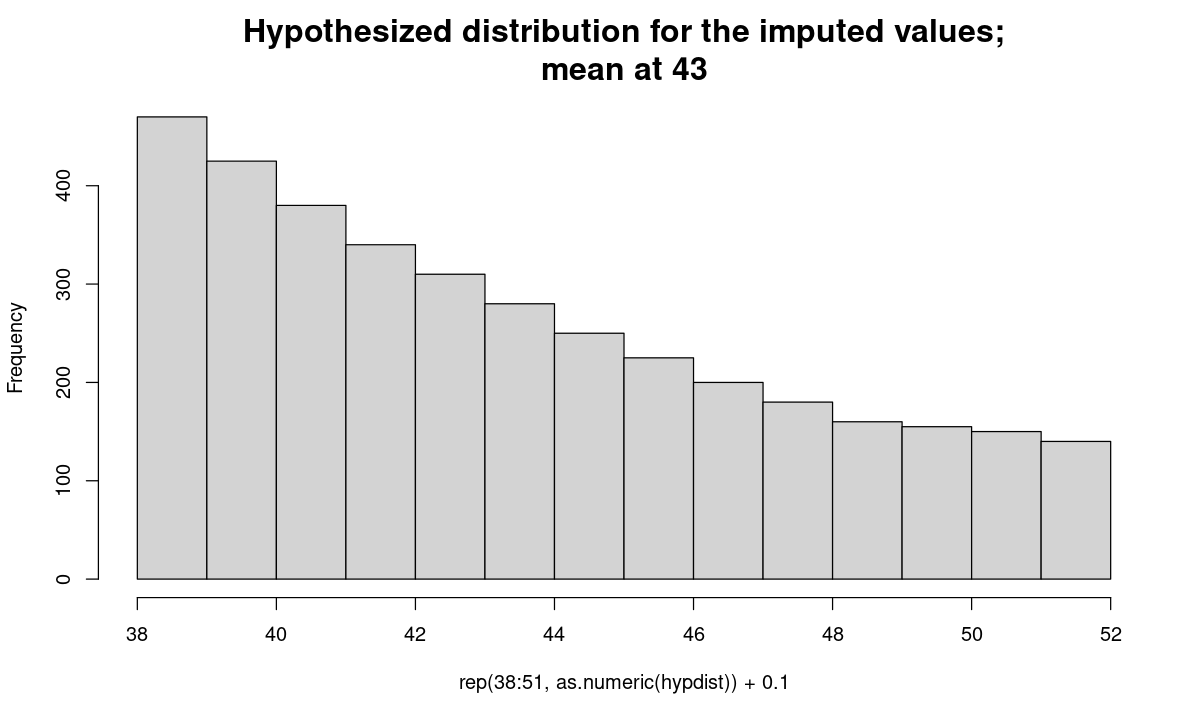

In [13]:
options(repr.plot.width= 10, repr.plot.height= 6)

hist(rep(38:51, as.numeric(hypdist)) + 0.1, 
     main="Hypothesized distribution for the imputed values;
mean at 43",
     cex.main= 1.6)


In [14]:
# Compute a FIRST PREDICTION for the mean and median 
# of our hypothetical distribution.

round(mean(rep(38:51, as.numeric(hypdist))), 1)
# 42.9 = 43

round(median(rep(38:51, as.numeric(hypdist))), 1)
# 42


[1] 42.9

[1] 42

### Age data: 2nd prediction for the mean, model-based

Using a 15-year window, compute shift-increment ratios.  Then model these ratios to obtain a 2nd prediction of the mean with a 95% prediction interval.  We can change the window size if this prediction interval does not cover our first prediction for the mean (43).  I start with a window span of 15 years because this span will cover the range of imputation when the start point is age 38, and yet not extend too far beyond the range of imputation.

In [15]:
# Combine the counts from the hypothesized distribution with the
# counts <= age 37.  

all_age_vals <- c(dat[which(dat$housing_median_age <= 37), c("housing_median_age")],
                        rep(38:51, as.numeric(hypdist)))
(all_counts <- table(as.factor(all_age_vals)))



  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19  20 
  4  58  62 190 243 160 175 204 205 264 253 238 302 411 512 766 697 570 500 465 
 21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40 
446 398 446 478 564 618 488 471 461 476 458 565 614 688 824 859 537 470 425 380 
 41  42  43  44  45  46  47  48  49  50  51 
340 310 280 250 225 200 180 160 155 150 140 

In [16]:
# Get means of the age values, looking out 10 years.  Make
# partial use of the hypothetical distribution.
# (I had to reduce the window span in order to get a 
# prediction consistent with the 42.9 prediction we
# have from the hypothetical distribution.)

span <- 10
uprlmt <- 33

mean_ratios <- means <- rcd_count <- rep(NA, length(6:uprlmt))

for(cur_age in 6:uprlmt) {
    
    agevals <- rep(cur_age:(span + cur_age), 
                   as.numeric(all_counts[cur_age:(span + cur_age)]))
    rcd_count[cur_age - 5] <- length(agevals)
    
    # Compute mean.
    age_mean <- round(mean(agevals), 5)
    mean_ratios[cur_age - 5] <- round(age_mean/cur_age, 3)
    means[cur_age - 5] <- age_mean
}

paste0("These are the 10-year shift increments for the means: ")
names(mean_ratios) <- as.character(6:uprlmt)
print(mean_ratios)


df_rat02 <- rep(NA, 4*length(mean_ratios))
dim(df_rat02) <- c(length(mean_ratios), 4)
df_rat02 <- as.data.frame(df_rat02)
colnames(df_rat02) <- c("age", "rcds","mean","mean_ratio")
df_rat02$age <- 6:uprlmt
df_rat02$rcds <- rcd_count
df_rat02$mean_ratio <- mean_ratios
df_rat02$mean <- means


[1] "These are the 10-year shift increments for the means: "

    6     7     8     9    10    11    12    13    14    15    16    17    18 
2.080 1.931 1.794 1.680 1.583 1.507 1.437 1.380 1.337 1.310 1.294 1.288 1.280 
   19    20    21    22    23    24    25    26    27    28    29    30    31 
1.268 1.255 1.241 1.232 1.222 1.216 1.214 1.214 1.205 1.191 1.177 1.162 1.148 
   32    33 
1.133 1.121 


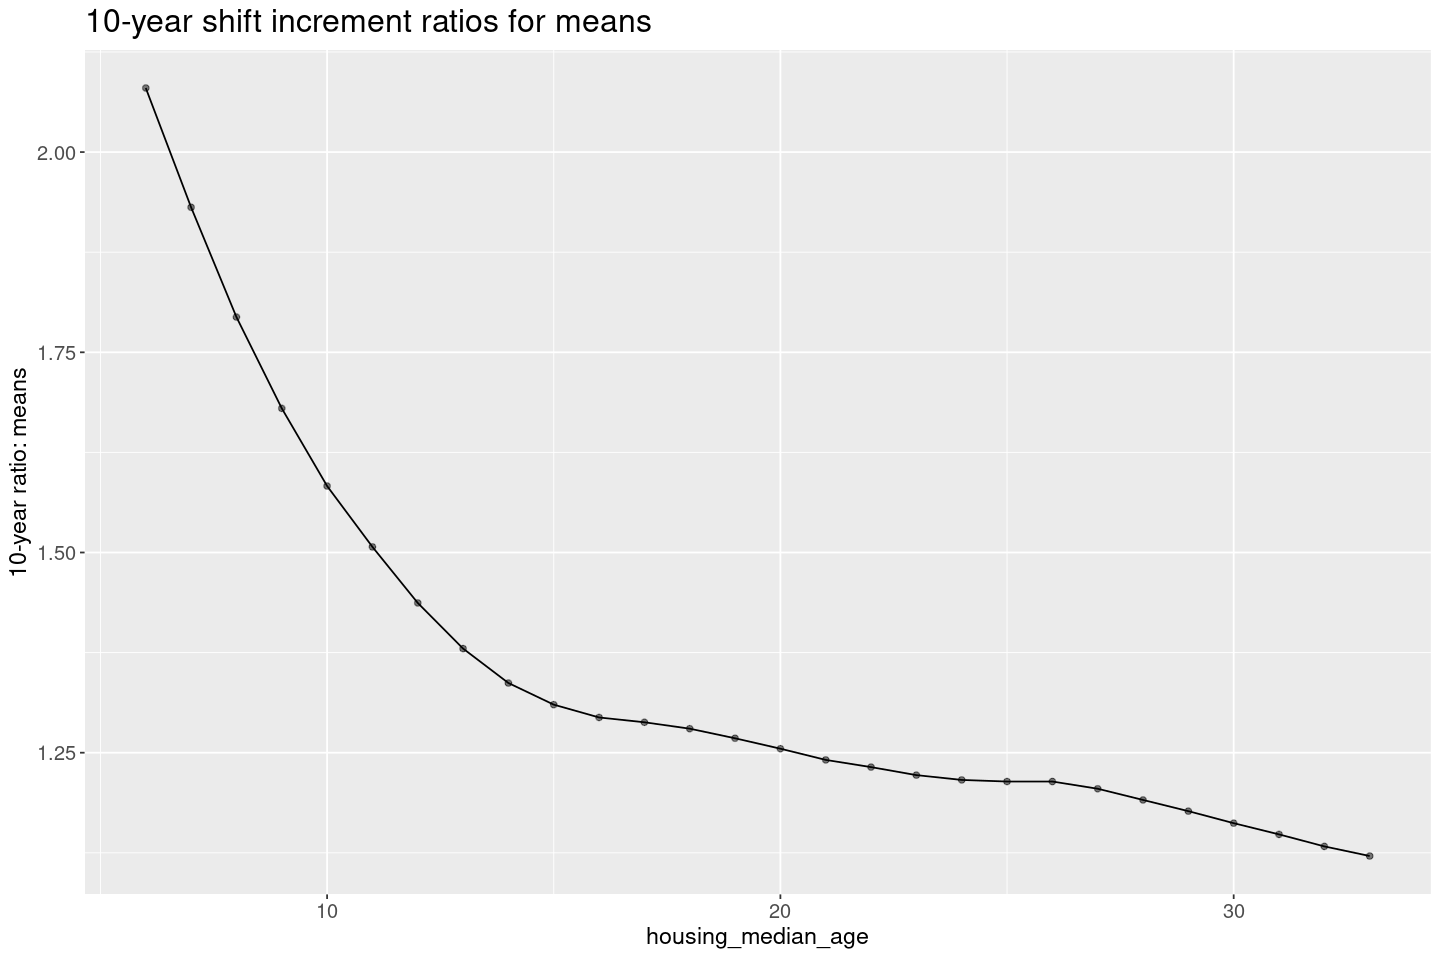

In [17]:
options(repr.plot.width= 12, repr.plot.height= 8)

p <- ggplot(df_rat02, aes(age, mean_ratio)) +
  geom_point(alpha= 0.5) + xlab("housing_median_age") + 
  ylab("10-year ratio: means") +
  geom_line() +
  ggtitle("10-year shift increment ratios for means") +
  theme(axis.text= element_text(size = 12)) +
  theme(axis.title= element_text(size= 14)) +
  theme(title= element_text(size= 16))
p


In [ ]:
### COMMENT:

# The above curve would be much smoother and exponential-like
# if the span were 15 years.


In [203]:
# Model for predicting mean_ratio at age = 38.

g01 <- lm(I(mean_ratio^-0.01) ~ I(age^0.03) + I((age^0.03)^2), 
          data= df_rat02, weights=(df_rat02$rcds)^0.45)
ans <- summary(g01)
ans[[1]] <- ""; ans



Call:
""

Weighted Residuals:
      Min        1Q    Median        3Q       Max 
-0.001743 -0.000870 -0.000365  0.000989  0.002482 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)
(Intercept)       -1.108      0.171   -6.48  8.6e-07
I(age^0.03)        3.781      0.315   12.01  7.0e-12
I((age^0.03)^2)   -1.697      0.145  -11.71  1.2e-11

Residual standard error: 0.00123 on 25 degrees of freedom
Multiple R-squared:  0.988,	Adjusted R-squared:  0.987 
F-statistic: 1.02e+03 on 2 and 25 DF,  p-value: <2e-16


In [204]:
ncvTest(g01)


Non-constant Variance Score Test 
Variance formula: ~ fitted.values 
Chisquare = 1.1326, Df = 1, p = 0.287

In [205]:
residualPlots(g01, plot=FALSE)


                Test stat Pr(>|Test stat|)
I(age^0.03)         -0.47             0.64
I((age^0.03)^2)     -0.38             0.71
Tukey test          -0.55             0.59


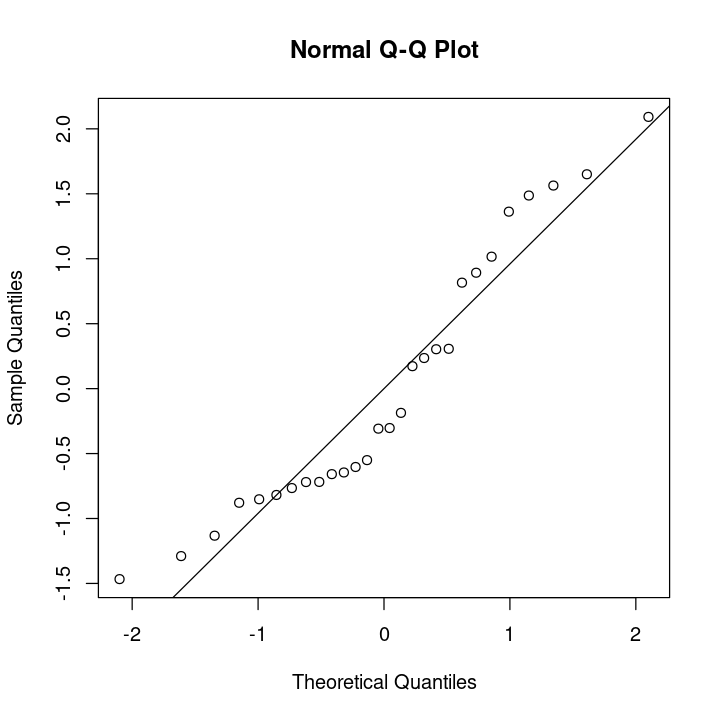

In [206]:
options(repr.plot.width= 6, repr.plot.height= 6)

ans <- qqnorm(scale(residuals(g01, type= "pearson")))
qqline(ans$x, probs = c(0.25, 0.75))


In [207]:
# Prediction for mean when age = 38.

newdat <- data.frame(age=38, rcds=3665)

ans <- predict.lm(g01, newdata= newdat, type= "response")
ans_transf <- ans^(1/-0.01); ans_transf
# 1.159356

# 1.159356 * 38 = 44.1


1 
1.1594

In [208]:
# Compute a 95% prediction interval.

pred_ans <- predict.lm(g01, newdata= newdat, interval="prediction",
                       level=0.95, weights=3665^0.45)
pred_ans_transf <- pred_ans^(1/-0.01); pred_ans_transf


,fit,lwr,upr
1,1.1594,1.2139,1.1072


In [210]:
lwr <- round(pred_ans_transf[2] * 38, 1)
upr <- round(pred_ans_transf[3] * 38, 1)

clause <- "95% prediction interval for estimate of the mean of the actual, unobserved values: "
print_ans <- paste0("[", upr, ", ", lwr ,"]")
paste0(clause, print_ans)
# [42.1, 46.1]


[1] "95% prediction interval for estimate of the mean of the actual, unobserved values: [42.1, 46.1]"

In [ ]:
### COMMENTS:

# It looks like we have a mean of around 43 or 44.  The 95%
# prediction interval is relatively narrow.  Since the span of
# 10 years is so small and the model diagnostics less than
# ideal, I will assume the mean is closer to 43.


### Age data: model used to generate the Gibbs output

In [316]:
# This is essentially the model from Section 2, Part01. 
# The Gibbs sampler that follows uses it to generate the
# imputed values.

a03 <- lm(I(housing_median_age^1.07) ~ 

            I(long_transf^-1) +
            I(long_transf^-1.5) +
          
            latitude +
            I(latitude^2) +
            I(latitude^3) + 
            I(latitude^4) +
          
            I(households^0.4) +
            I(households^0.8) +
            I(households^1.2) +
          
            I(median_house_value^0.05) +
            I(median_house_value^0.10) +
          
            I(HHdens_ln^1.1) +
            I(HHdens_ln^2.2),
          
            data= dat)

## NOTE: dat has censored housing_median_age values.

a03.summary <- summary(a03); 
a03.summary[[1]] <- ""; a03.summary



Call:
""

Residuals:
   Min     1Q Median     3Q    Max 
-49.06  -7.78   1.82   8.40  34.36 

Coefficients:
                            Estimate Std. Error t value Pr(>|t|)
(Intercept)                -1.06e+05   6.34e+03   -16.7   <2e-16
I(long_transf^-1)           5.17e+02   1.94e+01    26.6   <2e-16
I(long_transf^-1.5)        -5.77e+02   2.33e+01   -24.7   <2e-16
latitude                    1.17e+04   6.99e+02    16.8   <2e-16
I(latitude^2)              -4.76e+02   2.88e+01   -16.6   <2e-16
I(latitude^3)               8.60e+00   5.26e-01    16.4   <2e-16
I(latitude^4)              -5.82e-02   3.59e-03   -16.2   <2e-16
I(households^0.4)           4.89e+00   2.97e-01    16.4   <2e-16
I(households^0.8)          -4.48e-01   2.23e-02   -20.1   <2e-16
I(households^1.2)           9.47e-03   5.25e-04    18.0   <2e-16
I(median_house_value^0.05) -1.83e+03   9.55e+01   -19.1   <2e-16
I(median_house_value^0.1)   4.90e+02   2.61e+01    18.8   <2e-16
I(HHdens_ln^1.1)           -1.91e+00   1.82e-0

In [317]:
ncvTest(a03)


Non-constant Variance Score Test 
Variance formula: ~ fitted.values 
Chisquare = 0.59749, Df = 1, p = 0.44

In [318]:
residualPlots(a03, plot=FALSE)


                           Test stat Pr(>|Test stat|)
I(long_transf^-1)              -9.21          < 2e-16
I(long_transf^-1.5)            -8.27          < 2e-16
latitude                        0.51          0.60897
I(latitude^2)                   3.31          0.00094
I(latitude^3)                   3.70          0.00022
I(latitude^4)                   4.06          5.0e-05
I(households^0.4)              -0.64          0.52502
I(households^0.8)              -3.96          7.6e-05
I(households^1.2)              -4.82          1.4e-06
I(median_house_value^0.05)      0.79          0.42936
I(median_house_value^0.1)       4.83          1.3e-06
I(HHdens_ln^1.1)               -1.73          0.08276
I(HHdens_ln^2.2)               -4.01          6.0e-05
Tukey test                      0.62          0.53470


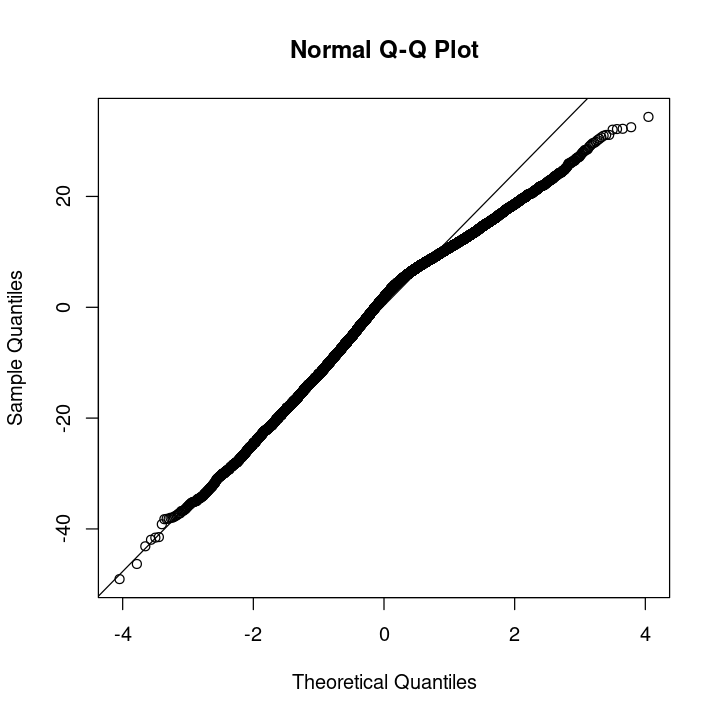

In [319]:
options(repr.plot.width= 6, repr.plot.height= 6)

qqnorm(residuals(a03, type= "pearson"))
qqline(residuals(a03, type= "pearson"))


### Run the Gibbs sampler

In [14]:
# Set the upper and lower limits.

cap <- 38
response_var_pwr <- 1.07
inv_pwr <- 1/response_var_pwr

C <- cap^response_var_pwr
C_upper <- 52^response_var_pwr

censored <- (dat$housing_median_age)^response_var_pwr >= C


# Create some crude starting values.
n.censored <- sum(censored)
z <- ifelse(censored, NA, (dat$housing_median_age)^response_var_pwr)
z[censored] <- runif(n.censored, C, C_upper)


length(censored)
n.censored
rows_censored <- rownames(dat[censored,])


[1] 19335

[1] 3665

In [15]:
# Function to draw from a constrained normal distribution.

rnorm.trunc <- function(n, mu, sigma, lo=-Inf, hi=Inf) {
    
    # We need mu to be at least the value of C in
    # order to prevent a return of Inf values.
    mu02 <- ifelse(mu < C, C, mu)
    
    p.lo <- pnorm(lo, mu02, sigma)
    p.hi <- pnorm(hi, mu02, sigma)
    u <- runif(n, p.lo, p.hi)
    return(qnorm(u, mu02, sigma))
}


In [322]:
# Create matrix X for the terms in our model.

X <- dat

X$long1 <- (X$long_transf)^-1
X$long2 <- (X$long_transf)^-1.5

X$lat2 <- (X$latitude)^2
X$lat3 <- (X$latitude)^3
X$lat4 <- (X$latitude)^4

X$hh1 <- (X$households)^0.4
X$hh2 <- (X$households)^0.8
X$hh3 <- (X$households)^1.2

X$median_hhval_1 <- (X$median_house_value)^0.05
X$median_hhval_2 <- (X$median_house_value)^0.10

X$HHdens_ln1 <- (X$HHdens_ln)^1.1
X$HHdens_ln2 <- (X$HHdens_ln)^2.2


X <- X[, c("long1","long2","latitude","lat2","lat3","lat4",
           "hh1","hh2","hh3","median_hhval_1","median_hhval_2",
           "HHdens_ln1","HHdens_ln2")]
intercept <- rep(1, nrow(dat))

init.colnames <- colnames(X)

X <- as.data.frame(cbind(intercept, X), col.names=c("intercept", init.colnames),
                   row.names=rownames(dat))
dim(X)
colnames(X)


[1] 19335    14

[1] "intercept"      "long1"          "long2"          "latitude"      
 [5] "lat2"           "lat3"           "lat4"           "hh1"           
 [9] "hh2"            "hh3"            "median_hhval_1" "median_hhval_2"
[13] "HHdens_ln1"     "HHdens_ln2"

In [326]:
# The Gibbs Sampler.

n <- nrow(dat)
n.chains <- 4
n.iter <- 2000

sims <- array(NA, c(n.iter, n.chains, 15 + n.censored))
dimnames(sims) <- list(NULL, NULL, c(colnames(X), "sigma", 
                                     paste("z[", (1:n)[censored],
                                           "]", sep="")))

start <- Sys.time()
for(m in 1:n.chains) {
    
    # acquire some initial values
    z[censored] <- runif(n.censored, C, C_upper)
    
    for(t in 1:n.iter) {
        
        a03.1 <- lm(z ~ 
                    
            I(long_transf^-1) +
            I(long_transf^-1.5) +
            latitude +
            I(latitude^2) +
            I(latitude^3) + 
            I(latitude^4) +
            I(households^0.4) +
            I(households^0.8) +
            I(households^1.2) +
            I(median_house_value^0.05) +
            I(median_house_value^0.10) +
            I(HHdens_ln^1.1) +
            I(HHdens_ln^2.2),
                    
            data= dat)
        
        sim.1 <- sim(a03.1, n.sims=1)
        beta <- coef(sim.1)
        sigma <- sigma.hat(sim.1)
        means <- as.matrix(X) %*% t(beta)
        z[censored] <- rnorm.trunc(n.censored, means[censored], sigma, lo=C, hi=C_upper)
        sims[t,m,] <- c(beta, sigma, z[censored])
    }
}
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 4.03 mins (for 2K iterations)


Time difference of 4.03 mins

In [ ]:
# Check for convergence:

sims.bugs <- R2OpenBUGS::as.bugs.array(sims, n.burnin=1000)
# print(sims.bugs)

# The Rhat value for every parameter and every imputed
# value should be 1.0.


In [328]:
save(sims, file="/home/greg/Documents/stat/Geron_ML/datasets/housing/sims_raw_age_Appendix_C.RData")


In [16]:
load("/home/greg/Documents/stat/Geron_ML/datasets/housing/sims_raw_age_Appendix_C.RData")

In [17]:
# Drop the first 1000 iterations.

sims_adj <- sims[1001:2000, ,]
dim(sims_adj)


[1] 1000    4 3680

In [18]:
# Check that the means and stddevs for the parameters and 
# imputed values does not include the burn-in values.

sims_adj.bugs <- R2OpenBUGS::as.bugs.array(sims_adj)
# print(sims_adj.bugs)


In [19]:
# Extract the means and stddevs for each of the censored records.

z_means <- sims_adj.bugs$mean$z
z_sds <- sims_adj.bugs$sd$z
round(head(z_means), 2); round(head(z_sds), 2)


[1] 57.25 57.14 57.44 57.04 57.26 57.20

[1] 5.34 5.25 5.31 5.26 5.29 5.37

In [20]:
summary(z_means)
summary(z_sds)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   56.9    57.1    57.2    57.2    57.2    61.8 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   5.00    5.27    5.30    5.30    5.33    5.50 

In [22]:
# Average estimate of the sd.

(sd_estimate <- round((57.2 + 5.3)^inv_pwr) - round(57.2^inv_pwr))
# 4


[1] 4

In [23]:
# Here is a fuller summary for the stddevs.

ans <- round((z_means + z_sds)^inv_pwr) - round(z_means^inv_pwr)
summary(ans)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   3.00    4.00    4.00    3.98    4.00    4.00 

In [21]:
rm(sims, sims_adj)


In [72]:
# Get some predictions, using rnorm.trunc.

set.seed(1931)
z_preds <- round(rnorm.trunc(n.censored, z_means, z_sds, lo=C, hi=C_upper), 1)
summary(z_preds^inv_pwr)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   38.0    41.9    44.1    44.3    46.5    52.0 

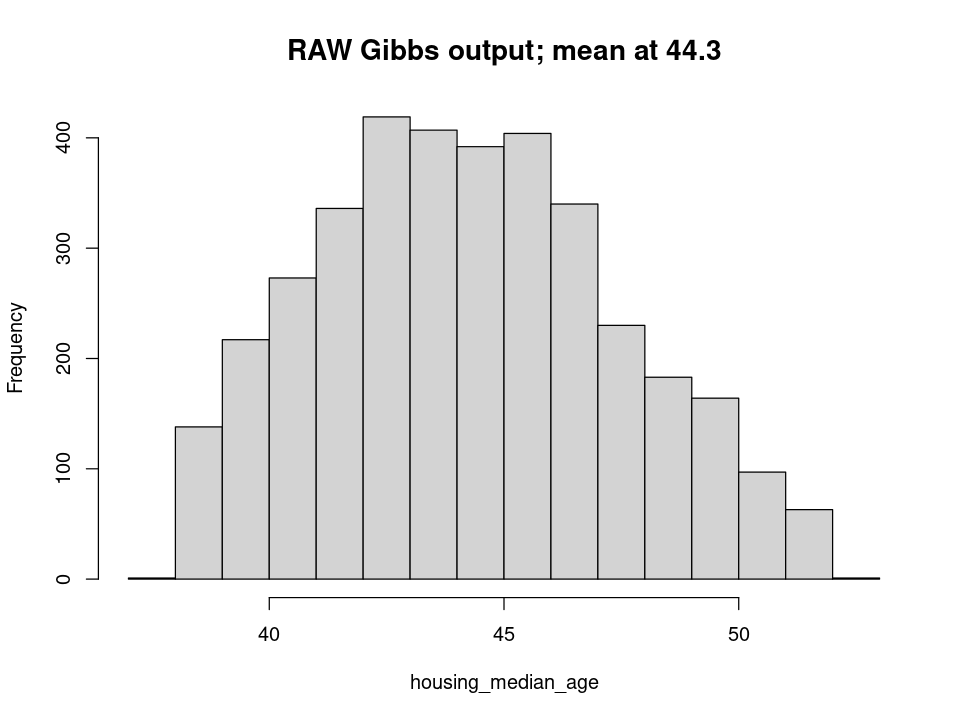

In [73]:
options(repr.plot.width= 8, repr.plot.height= 6)

hist(z_preds^inv_pwr, breaks=14, main="RAW Gibbs output; mean at 44.3",
     xlab="housing_median_age", cex.main= 1.4)


In [ ]:
### COMMENT:

# The above distribution is quite different from
# our hypothesized distribution.


In [74]:
# Assign imputed values and save out.

newdat_raw <- dat
newdat_raw$housing_median_age[censored] <- z_preds^inv_pwr

write.csv(newdat_raw,
          file="/home/greg/Documents/stat/Geron_ML/datasets/housing/imputed_age_vals_App_C_GibbsRAW.csv",
          row.names=TRUE)


### Age data: Adjust Gibbs output---Approach 1

In [22]:
# Move the mean over to 43.  Note that I have to use 42
# rather than 43 in the following computation in order
# to get the mean to 43 (at least when using seed 1933).
# See the output of the next cell.

(z_means_bar <- mean(z_means))
z_means_adj <- z_means - (z_means_bar - 42^response_var_pwr)
mean(z_means_adj)


[1] 57.183

[1] 54.56

In [23]:
# Get new predictions.

set.seed(1933)
z_preds_adj01 <- round(rnorm.trunc(n.censored, z_means_adj, z_sds, lo=C, hi=C_upper), 2)
summary(z_preds_adj01^inv_pwr)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   38.0    40.6    42.6    43.0    45.0    52.0 

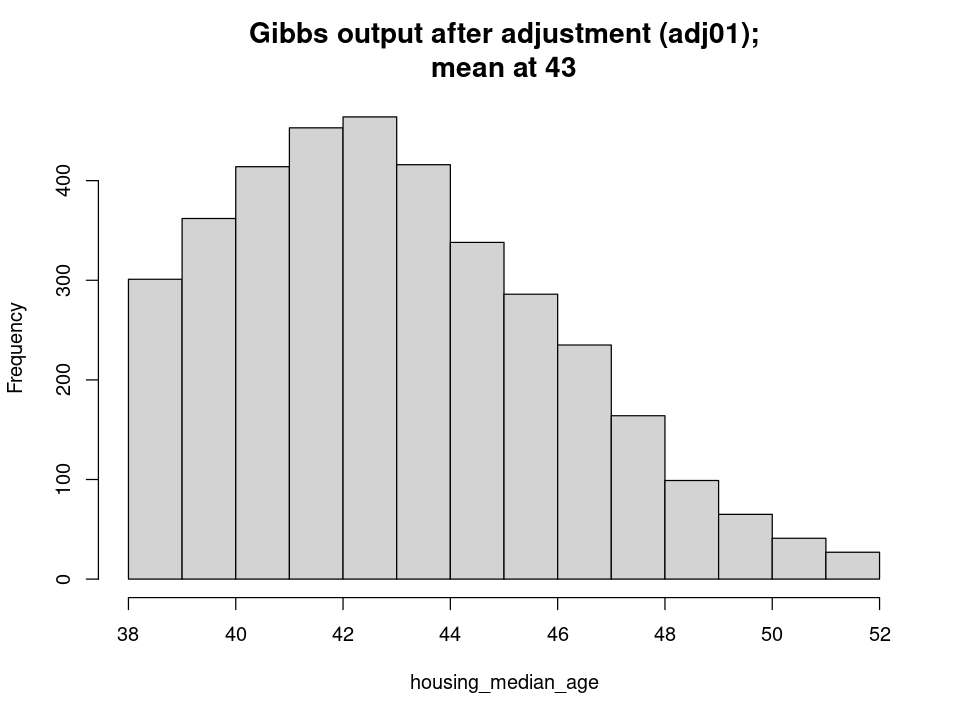

In [137]:
options(repr.plot.width= 8, repr.plot.height= 6)

hist(z_preds_adj01^inv_pwr, breaks=18, 
     main="Gibbs output after adjustment (adj01);
mean at 43", xlab="housing_median_age", cex.main=1.4)


In [ ]:
### COMMENT:

# The above shape is closer to what we expect to see for
# the distribution of imputed values but, as we see in
# the density plot that follows, still significantly far
# off.


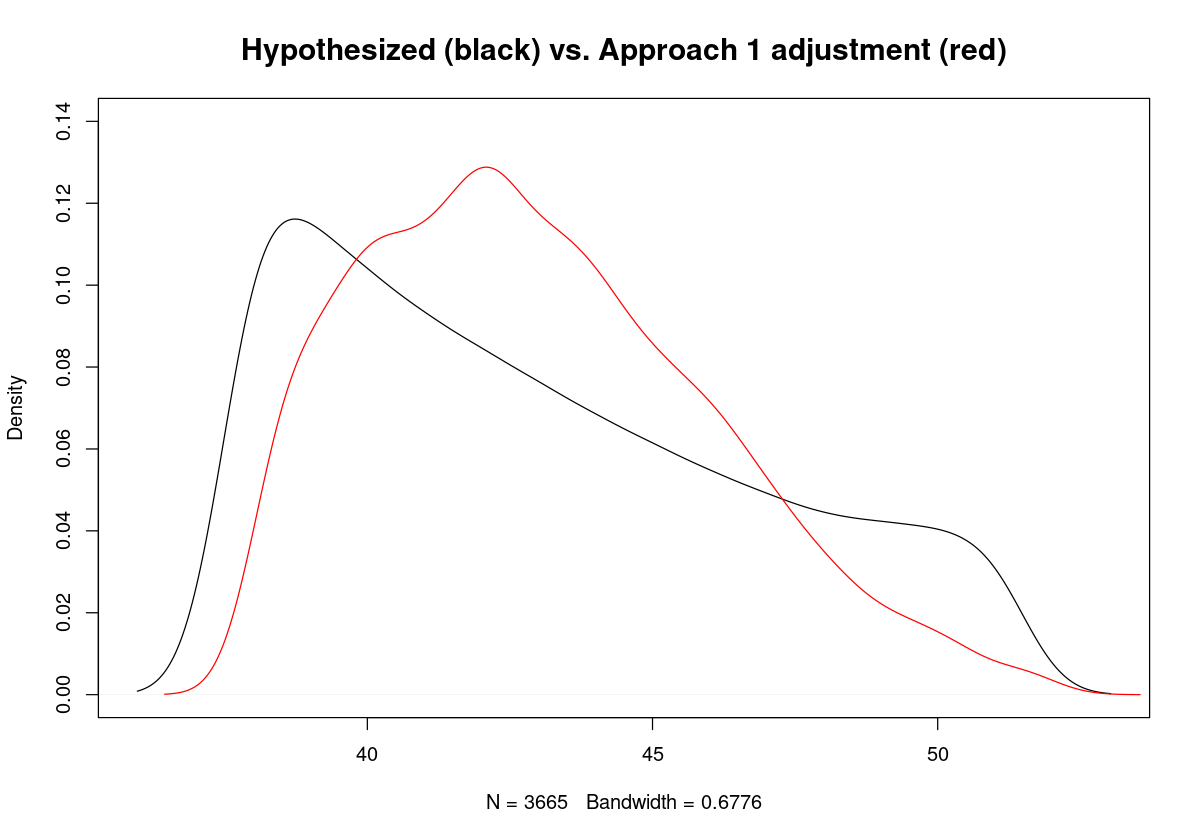

In [25]:
# Create single plot of overlaid densities.

options(repr.plot.width= 10, repr.plot.height= 7)

fit <- density(rep(38:51, as.numeric(hypdist)))
plot(fit, main="Hypothesized (black) vs. Approach 1 adjustment (red)",
     cex.main=1.5, ylim=c(0, 0.14))

lines(density(z_preds_adj01^inv_pwr), col= "red")


In [32]:
# Assign imputed values and save out.

newdat_adj01 <- dat
newdat_adj01$housing_median_age[censored] <- z_preds_adj01^inv_pwr

write.csv(newdat_adj01,
          file="/home/greg/Documents/stat/Geron_ML/datasets/housing/imputed_age_vals_App_C_adj01.csv",
          row.names=TRUE)


### Age data: Adjust Gibbs output---Approach 2

In [26]:
# Function which identifies the age level that a given age
# falls into. 
# When bin_size = 1, the RSS gain for Approach 2 is only 0.37.
# When bin_size = 2, the RSS gain is closer to 0.44.

get_agelev <- function(val, bin_size=2) {
    
    return(floor(val/bin_size) * bin_size)
}


In [27]:
# Construct a dataframe which holds predictions for each
# of the z_means and records the probability of the z_mean
# being located at the "predicted" value.

n_preds <- 18000

start <- Sys.time()
dfpreds <- rep(NA, n_preds*n.censored*4)
dim(dfpreds) <- c(n_preds*n.censored, 4)
dfpreds <- as.data.frame(dfpreds)
colnames(dfpreds) <- c("rowname","predicted_val","loc_prob","agelev")

dfpreds$rowname <- rep(rows_censored, rep(n_preds, n.censored))

stop <- Sys.time()
round(stop - start, 2)
# Time difference of 2.74 secs


Time difference of 2.78 secs

In [28]:
# Get vectors needed for our dataframe.

probs_list <- agelev_list <- preds_list <- vector("list", length=n.censored)
names(probs_list) <- names(agelev_list) <- names(preds_list) <- rows_censored


start <- Sys.time()
for(i in 1:n.censored) {
    
    cur_mean <- z_means[i]
    cur_sd <- z_sds[i]
    cur_row <- rows_censored[i]
    
    # Get n_preds predictions for this mean.
    mu02 <- ifelse(cur_mean <= C, C , cur_mean)
    p.lo <- pnorm(C, mu02, cur_sd)
    p.hi <- pnorm(C_upper, mu02, cur_sd)
    u <- qnorm(runif(n_preds, p.lo, p.hi), mu02, cur_sd)
    loc_probs <- abs(dnorm(u, mu02, cur_sd, log=TRUE))
    u_transf <- u^inv_pwr
    agelev_vector <- as.vector(apply(as.matrix(u_transf), MARGIN=2, FUN=get_agelev))
    
    probs_list[[i]] <- loc_probs
    preds_list[[i]] <- u_transf
    agelev_list[[i]] <- agelev_vector
}
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 6.43 secs


Time difference of 6.68 secs

In [29]:
# Populate the dataframe.

start <- Sys.time()
dfpreds$predicted_val <- as.vector(unlist(preds_list))
dfpreds$loc_prob <- as.vector(unlist(probs_list))
dfpreds$agelev <- as.vector(unlist(agelev_list))

stop <- Sys.time()
round(stop - start, 2)
# Time difference of 1.08 mins when n_preds = 18K

dim(dfpreds)
# 65,970,000    4 when n_preds = 18K

head(dfpreds); tail(dfpreds)


Time difference of 60 secs

[1] 65970000        4

,rowname,predicted_val,loc_prob,agelev
,<chr>,<dbl>,<dbl>,<dbl>
1,1,50.615,4.1309,50
2,1,49.349,3.6017,48
3,1,42.335,2.6812,42
4,1,48.937,3.4536,48
5,1,41.007,2.8849,40
6,1,44.664,2.6123,44


,rowname,predicted_val,loc_prob,agelev
,<chr>,<dbl>,<dbl>,<dbl>
65969995,20621,41.815,2.7305,40
65969996,20621,39.411,3.2542,38
65969997,20621,40.810,2.9023,40
65969998,20621,42.764,2.6312,42
65969999,20621,40.302,3.0150,40
65970000,20621,42.927,2.6203,42


In [30]:
rm(probs_list, agelev_list, preds_list)


In [31]:
# Order the data in dfpreds so that we can access it
# more quickly.

dfpreds <- dfpreds[order(dfpreds$agelev),]


In [32]:
# Create a new hypdist which has counts for 2-year
# intervals.  hypdist has 14 age levels.

hypdist02 <- rep(NA, 7)

index <- 1
for(i in 1:7) {
    
    hypdist02[i] <- as.numeric(hypdist[index]) + as.numeric(hypdist[index + 1])
    index <- index + 2
}
print(hypdist02)
sum(hypdist02) == 3665
sum(hypdist02)


[1] 895 720 590 475 380 315 290


[1] TRUE

[1] 3665

In [33]:
# The mean of hypdist02 might no longer be at 43.
# There is not much we can do about this without
# radically altering the counts.

round(mean(rep(c(39, 41, 43, 45, 47, 49, 51), hypdist02)), 1)


[1] 43.5

In [34]:
# We now need to find predictions for each of the age levels.
# 51 - 38 + 1 = 14; 51 and 38 are the limits of our hypothesized
# distribution.
# When bin_size is 2, we have only 7 bins: 38, 40, 42, 44, 46, 48, 50

agelevs <- c(38, 40, 42, 44, 46, 48, 50)
rows_to_exclude <- c()

newpreds <- c()
pred_names <- c()

# We do not want to fill the bins in sequential order from
# 1:7.  We start in the tail of the distribution because
# it can be the most difficult to fill despite having the
# smallest counts.
seq <- c(7:5, 1:4)

start <- Sys.time()
for(i in seq) {
    
    cur_count <- hypdist02[i]
    binval <- agelevs[i]
    
    dftmp <- dfpreds[which(dfpreds$agelev == binval),]
    
    # Remove the z_means that we have already used.
    dftmp <- dftmp[which(!(dftmp$rowname %in% rows_to_exclude)),]
    
    # When I also sort on loc_prob in the following line, the 
    # RSS gain goes up.  But the distribution shape is further
    # away from what we expect, or it can be.  Some jittering can
    # alleviate this.
    dftmp <- dftmp[order(dftmp$rowname, dftmp$loc_prob,
                         decreasing=c(FALSE, FALSE)),]
    dftmp <- dftmp[which(!duplicated(dftmp$rowname)),]
    
    # stopifnot(nrow(dftmp) >= cur_count)
    
    # If we get this far, we have enough predictions to draw from
    # to fill the current bin.  Now order the records by the
    # probabilities and then select what we need.
    dftmp <- dftmp[order(dftmp$loc_prob, decreasing=FALSE),]
    dftmp <- dftmp[1:cur_count, c("rowname","predicted_val")]
    
    newpreds <- c(newpreds, dftmp$predicted_val)
    pred_names <- c(pred_names, dftmp$rowname)
    rows_to_exclude <- c(rows_to_exclude, dftmp$rowname)
}
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 1.27 mins


Time difference of 1.02 mins

In [35]:
length(newpreds)
length(pred_names)


[1] 3665

[1] 3665

In [36]:
length(unique(pred_names))


[1] 3665

In [37]:
names(newpreds) <- pred_names
print(tail(newpreds))


 16206   5081    747  17603  17261   4839 
44.001 44.001 44.000 44.000 44.000 44.000 


In [38]:
# Check mean of the distribution.

summary(newpreds)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   40.0    42.0    43.9    43.6    46.0    50.0 

In [39]:
# Adjust the mean so that it is where we expect it to be.

newpreds_adj <- newpreds - 0.6
summary(newpreds_adj)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   39.4    41.4    43.3    43.0    45.4    49.4 

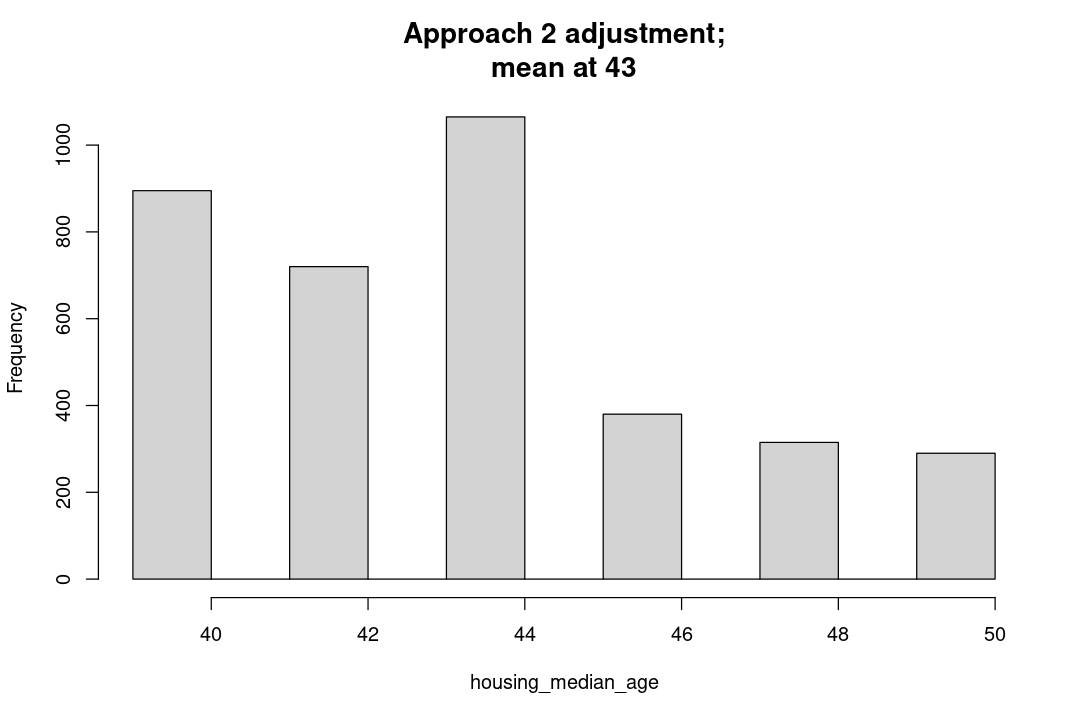

In [40]:
# Check shape of the distribution.

options(repr.plot.width= 9, repr.plot.height= 6)

hist(newpreds_adj, breaks=8, main="Approach 2 adjustment;
mean at 43", xlab="housing_median_age", cex.main=1.4)


In [ ]:
### COMMENT:

# I increased the bin size from 1 year to 2 years in order
# to improve the RSS gain.  But the way my algorithm works,
# it will select out the predictions within each 2-year bin
# that are closest to the mean (43).  This is why we are
# missing predictions in age levels 38, 40, 42, 45, 47, and 49.


In [41]:
# Jitter the predictions.

set.seed(9675)
newpreds_adj02 <- jitter(newpreds_adj-0.1, amount=0.9)
summary(newpreds_adj02)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   38.4    40.5    42.7    43.0    44.7    50.2 

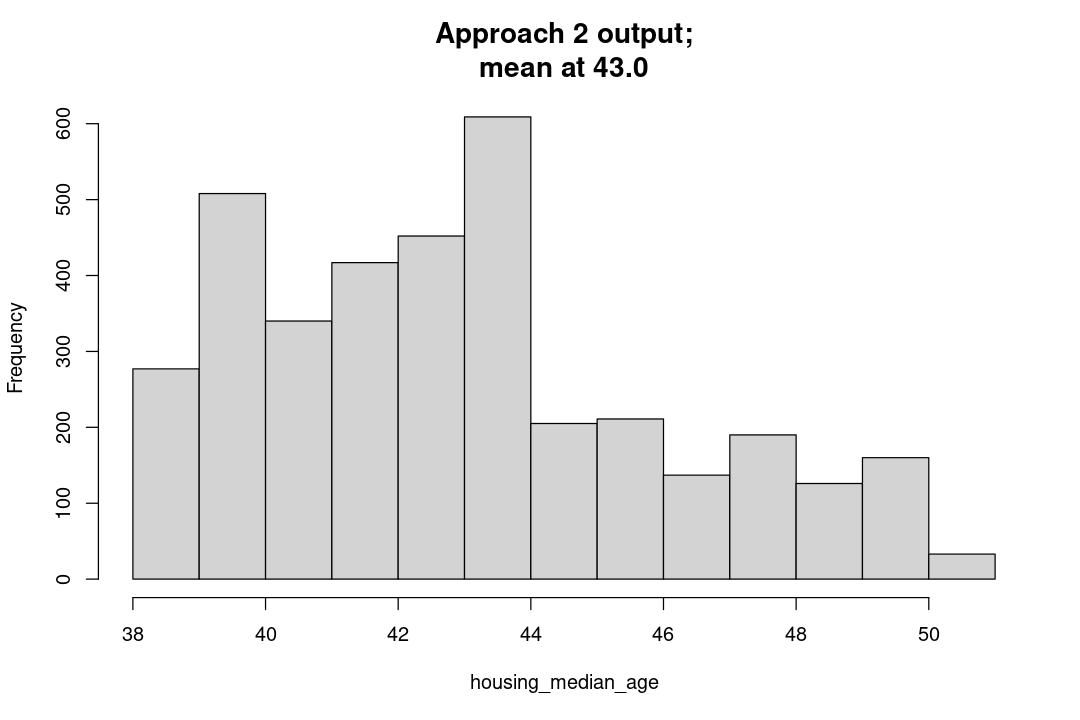

In [44]:
options(repr.plot.width= 9, repr.plot.height= 6)

hist(newpreds_adj02, breaks=14, main="Approach 2 output;
mean at 43.0", xlab="housing_median_age", cex.main=1.4)


In [112]:
# Assign imputed values to the correct records in dat.

newdat_adj02 <- dat
newdat_adj02[rows_censored, c("housing_median_age")] <- as.numeric(newpreds_adj[rows_censored])
summary(newdat_adj02$housing_median_age)

# Also save out the jittered predictions.
newdat_adj02b <- dat
newdat_adj02b[rows_censored, c("housing_median_age")] <- as.numeric(newpreds_adj02[rows_censored])


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    1.0    18.0    27.0    27.1    36.0    49.4 

### Compare the Approach 2 distributions with the hypothetical distribution

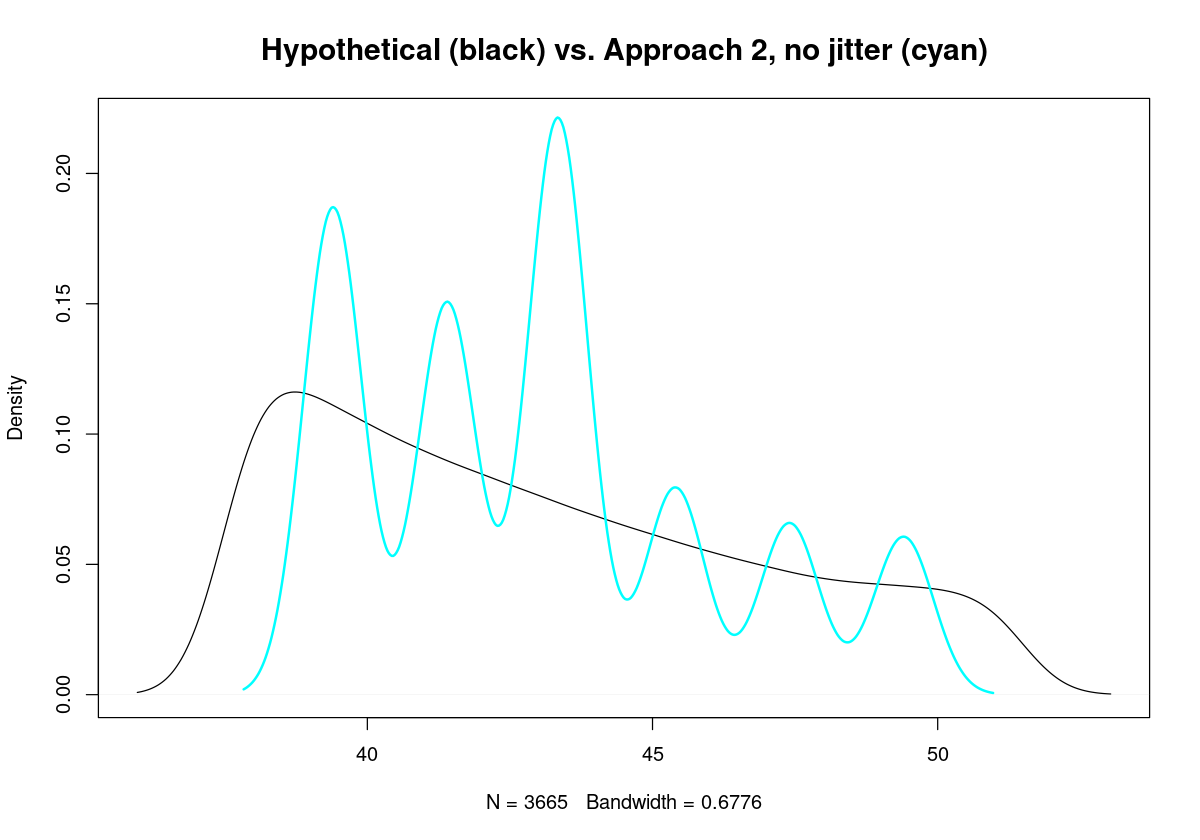

In [89]:
# Create single plot of overlaid densities.

options(repr.plot.width= 10, repr.plot.height= 7)

fit <- density(rep(38:51, as.numeric(hypdist)))
plot(fit, main="Hypothetical (black) vs. Approach 2, no jitter (cyan)",
     cex.main=1.5, ylim=c(0, 0.22))

lines(density(newpreds_adj), col= "cyan", lwd=2)


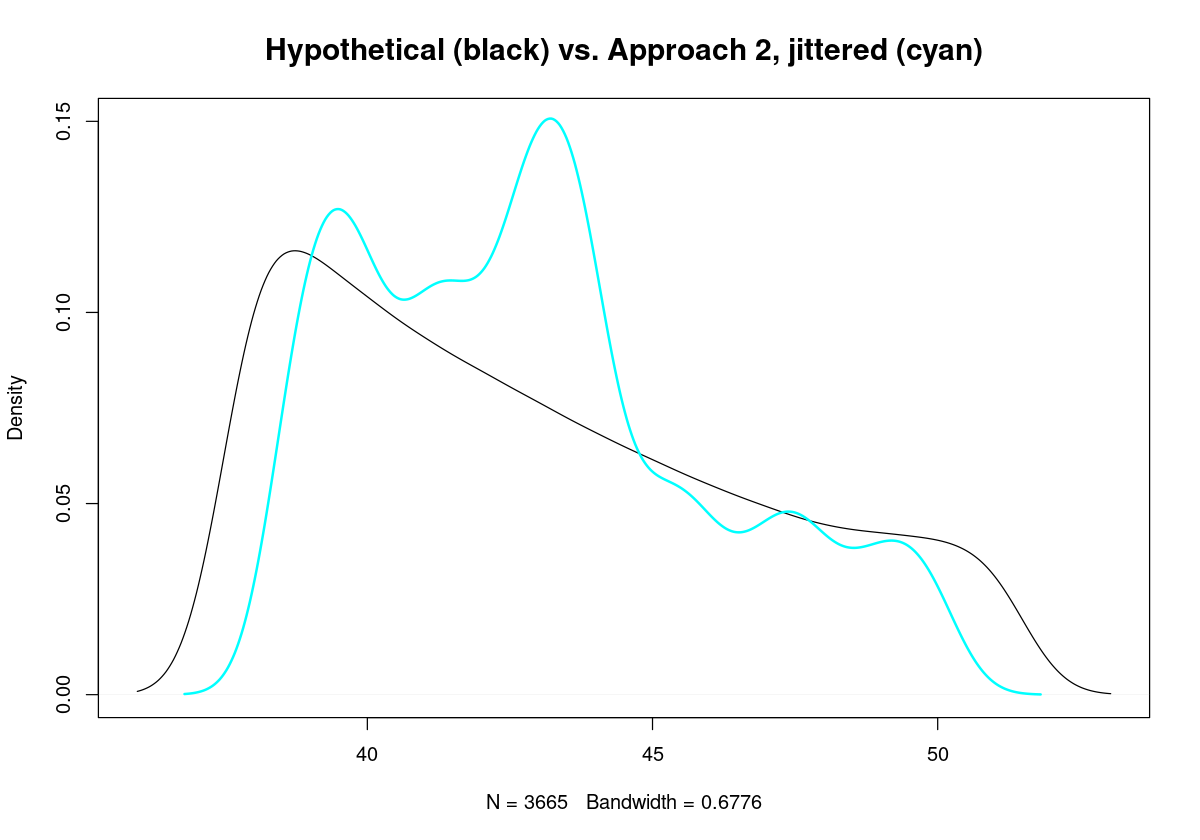

In [113]:
# Create single plot of overlaid densities.

options(repr.plot.width= 10, repr.plot.height= 7)

fit <- density(rep(38:51, as.numeric(hypdist)))
plot(fit, main="Hypothetical (black) vs. Approach 2, jittered (cyan)",
     cex.main=1.5, ylim=c(0, 0.15))

lines(density(newpreds_adj02), col= "cyan", lwd=2)


### Adjust hypdist02 prior to filling the age level bins with records from dfpreds

We can adjust hypdist02 so that the output of Approach 2 better approximates the hypothesized distribution.  But we see further downstream that this additional adjustment hurts the RSS score.  This makes sense because the mode of the cyan curve in the above density plot is very near the expected (and real) mean of 43.  In general, the more predictions we have at the expected mean, the higher the RSS score will be.

In Appendix A the Approach 2 output has a secondary mode not at the expected mean.  I can adjust the hypdist02 counts there to get a much better fit to the hypothesized distribution (the original hypdist vector of counts).  What I do not know is whether this further adjustment moves the predictions closer to the actual, unobserved values.

In [45]:
print(hypdist02)


[1] 895 720 590 475 380 315 290


In [82]:
# We adjust the counts so that the Approach 2 output
# better approximates the hypothesized distribution.

hypdist03 <- c(900, 700, 520, 410, 400, 375, 360)
sum(hypdist03) == 3665
sum(hypdist03)


[1] TRUE

[1] 3665

In [83]:
agelevs <- c(38, 40, 42, 44, 46, 48, 50)
rows_to_exclude <- c()

newpreds <- c()
pred_names <- c()

seq <- c(7:5, 1:4)

start <- Sys.time()
for(i in seq) {
    
    cur_count <- hypdist03[i]
    binval <- agelevs[i]
    
    dftmp <- dfpreds[which(dfpreds$agelev == binval),]
    
    # Remove the z_means that we have already used.
    dftmp <- dftmp[which(!(dftmp$rowname %in% rows_to_exclude)),]
    
    dftmp <- dftmp[order(dftmp$rowname, dftmp$loc_prob,
                         decreasing=c(FALSE, FALSE)),]
    dftmp <- dftmp[which(!duplicated(dftmp$rowname)),]
    
    # stopifnot(nrow(dftmp) >= cur_count)
    
    dftmp <- dftmp[order(dftmp$loc_prob, decreasing=FALSE),]
    dftmp <- dftmp[1:cur_count, c("rowname","predicted_val")]
    
    newpreds <- c(newpreds, dftmp$predicted_val)
    pred_names <- c(pred_names, dftmp$rowname)
    rows_to_exclude <- c(rows_to_exclude, dftmp$rowname)
}
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 1.02 mins


Time difference of 55.2 secs

In [84]:
length(newpreds)
length(pred_names)


[1] 3665

[1] 3665

In [85]:
length(unique(pred_names))
names(newpreds) <- pred_names


[1] 3665

In [86]:
# Check mean of the distribution.

summary(newpreds)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   40.0    42.0    43.9    43.8    46.0    50.0 

In [87]:
# Adjust the mean so that it is where we expect it to be.

newpreds_adj <- newpreds - 0.8
summary(newpreds_adj)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   39.2    41.2    43.1    43.0    45.2    49.2 

In [108]:
# Jitter the predictions.

set.seed(9675)
newpreds_adj02 <- jitter(newpreds_adj-0.05, amount=0.9)
newpreds03 <- ifelse(newpreds_adj02 < 38, 38, newpreds_adj02)
summary(newpreds03)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   38.2    40.3    42.7    43.0    45.3    50.0 

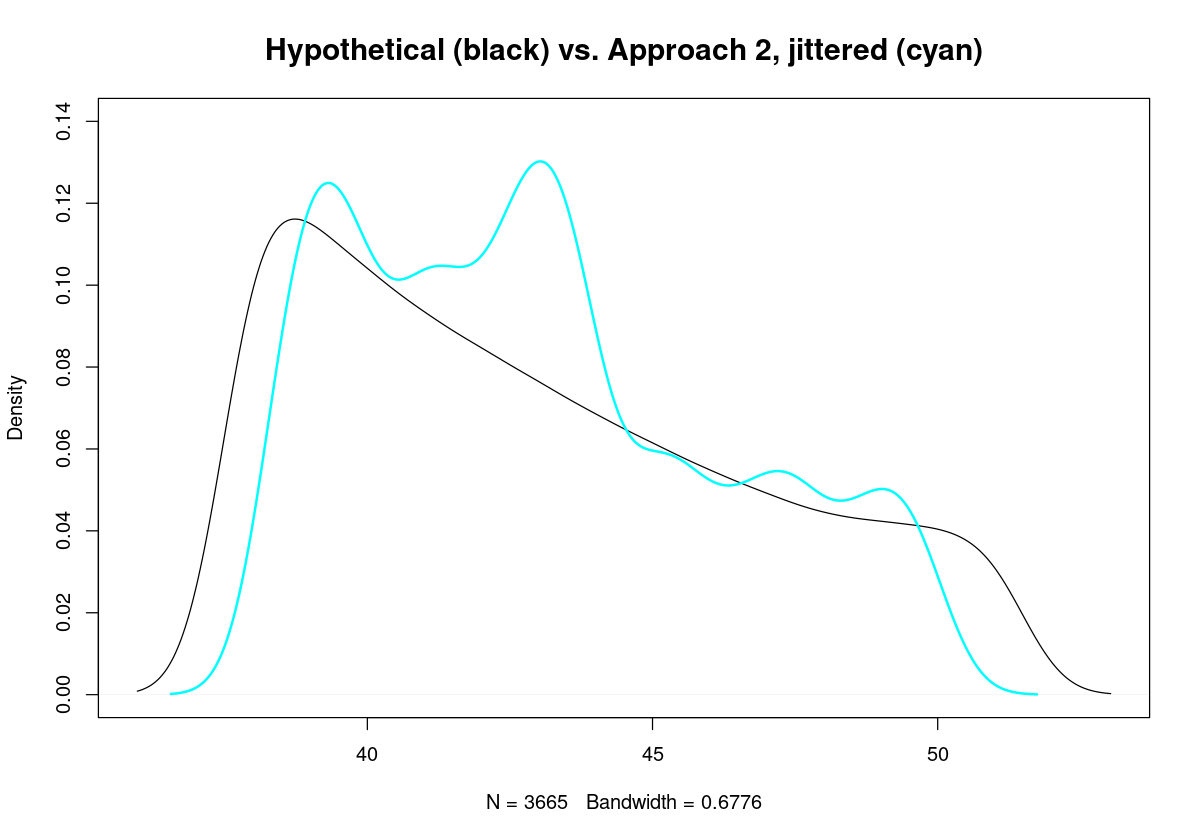

In [109]:
# Check shape of the distribution.

options(repr.plot.width= 10, repr.plot.height= 7)

fit <- density(rep(38:51, as.numeric(hypdist)))
plot(fit, main="Hypothetical (black) vs. Approach 2, jittered (cyan)",
     cex.main=1.5, ylim=c(0, 0.14))

lines(density(newpreds03), col= "cyan", lwd=2)


In [ ]:
### COMMENT:

# The fit to the hypothesized distribution has improved.


In [110]:
# Assign imputed values to the correct records in dat.

newdat_adj03 <- dat
newdat_adj03[rows_censored, c("housing_median_age")] <- as.numeric(newpreds03[rows_censored])


## Compute initial RSS scores for each of the 3 methods

In [66]:
# Compute the mean of the actual, unobserved values in the
# range of imputation.

dim(dat_noCap)
round(mean(dat_noCap[which(dat_noCap$housing_median_age >= 38),]$housing_median_age))
# 43


[1] 19335     6

[1] 43

In [102]:
# Extract the unobserved, actual values.

unobserved_vals <- dat_noCap[which(dat_noCap$housing_median_age >= 38),]$housing_median_age
length(unobserved_vals)


[1] 3665

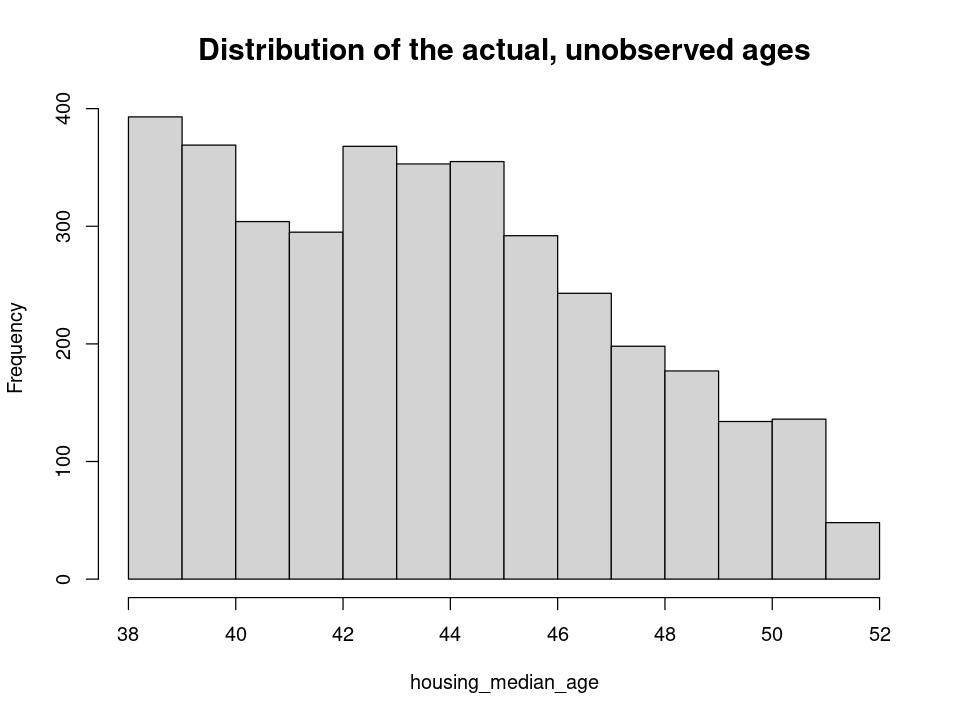

In [68]:
options(repr.plot.width= 8, repr.plot.height= 6)

hist(unobserved_vals + 0.01, breaks=18, main="Distribution of the actual, unobserved ages",
     xlab="housing_median_age", cex.main=1.5)


In [103]:
actual_vals <- unobserved_vals
names(actual_vals) <- rownames(dat_noCap[which(dat_noCap$housing_median_age >= 38),])


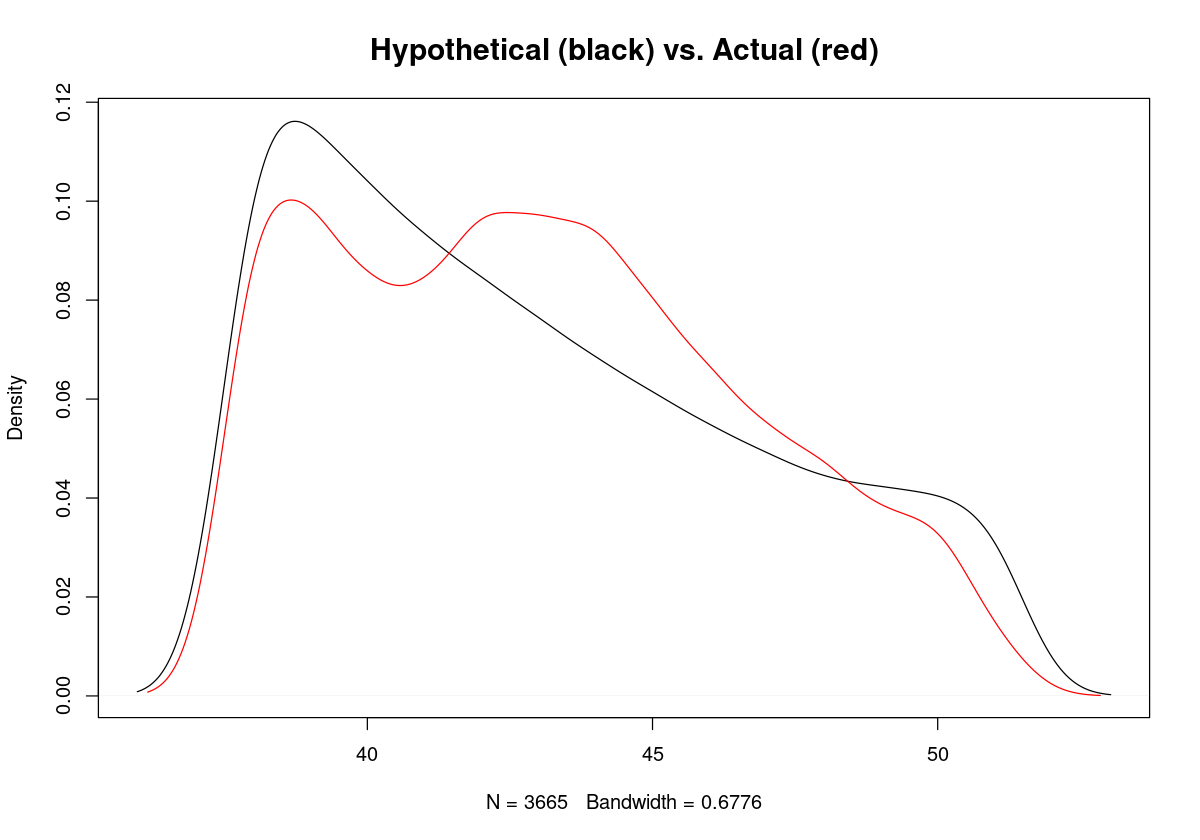

In [70]:
# Create single plot of overlaid densities.

options(repr.plot.width= 10, repr.plot.height= 7)

fit <- density(rep(38:51, as.numeric(hypdist)))
plot(fit, main="Hypothetical (black) vs. Actual (red)",
     cex.main=1.5)

lines(density(unobserved_vals), col= "red")



### Age data: Compute the RSS gain for the original Gibbs output

RSS gain = 1 - \[RSS for predicted values / RSS for capped values\]


In [75]:
gibbs_raw_imputed <- newdat_raw[rows_censored, ]$housing_median_age
names(gibbs_raw_imputed) <- rows_censored

gibbs_raw_rss <- round(sum((actual_vals[rows_censored] - gibbs_raw_imputed[rows_censored])^2))
paste0("RSS for the unadjusted Gibbs output: ", as.character(gibbs_raw_rss))


[1] "RSS for the unadjusted Gibbs output: 86625"

In [104]:
# Compute the RSS for the capped values.

cap_rss <- round(sum((actual_vals[rows_censored] - 38)^2))


In [77]:
# Compute the RSS gain for the original Gibbs output.
# This is a measure of how much we have reduced the noise
# in the capped values.

# RSS gain = 1 - [RSS for predicted values / RSS for capped values]

(gibbs_raw_RSSgain <- round(1 - gibbs_raw_rss/cap_rss, 4))
# 0.3779


[1] 0.3779

### Compute the RSS gain if all imputed values are set to the predicted mean

In [58]:
allvals_at_mean_rss <- round(sum((actual_vals - 43)^2))
paste0("RSS for all values at predicted mean: ", as.character(allvals_at_mean_rss))


[1] "RSS for all values at predicted mean: 45876"

In [59]:
# RSS gain when all imputed values are set to the predicted mean:

(adj01_RSSgain <- round(1 - allvals_at_mean_rss/cap_rss, 4))
# 0.6705


[1] 0.6705

### Compute the RSS gain for the adj01 output

In [56]:
adj01_imputed <- newdat_adj01[rows_censored, ]$housing_median_age
names(adj01_imputed) <- rows_censored

adj01_rss <- round(sum((actual_vals[rows_censored] - adj01_imputed[rows_censored])^2))
paste0("RSS for the adjusted Gibbs output (adj01): ", as.character(adj01_rss))


[1] "RSS for the adjusted Gibbs output (adj01): 77864"

In [57]:
# RSS gain for the adj01 output:

(adj01_RSSgain <- round(1 - adj01_rss/cap_rss, 4))
# 0.4408


[1] 0.4408

### Compute the RSS gain for the adj02 output (no jittering)

In [78]:
adj02_imputed <- newdat_adj02[rows_censored, ]$housing_median_age
names(adj02_imputed) <- rows_censored

adj02_rss <- round(sum((actual_vals[rows_censored] - adj02_imputed[rows_censored])^2))
paste0("RSS for the adjusted Gibbs output (adj02): ", as.character(adj02_rss))


[1] "RSS for the adjusted Gibbs output (adj02): 77633"

In [79]:
# RSS gain for the adj02 output:

(adj02_RSSgain <- round(1 - adj02_rss/cap_rss, 4))
# 0.4425


[1] 0.4425

### Compute the RSS gain for the adj02 output with jittered predictions

In [114]:
adj02b_imputed <- newdat_adj02b[rows_censored, ]$housing_median_age
names(adj02b_imputed) <- rows_censored

adj02b_rss <- round(sum((actual_vals[rows_censored] - adj02b_imputed[rows_censored])^2))
paste0("RSS for the adjusted Gibbs output (adj02): ", as.character(adj02b_rss))


[1] "RSS for the adjusted Gibbs output (adj02): 78422"

In [115]:
# RSS gain for the adj02 output:

(adj02b_RSSgain <- round(1 - adj02b_rss/cap_rss, 4))
# 0.4368


[1] 0.4368

### Compute the RSS gain for the 03 output with jittered predictions

In [111]:
adj03_imputed <- newdat_adj03[rows_censored, ]$housing_median_age
names(adj03_imputed) <- rows_censored

adj03_rss <- round(sum((actual_vals[rows_censored] - adj03_imputed[rows_censored])^2))
paste0("RSS for the adjusted Gibbs output (adj03): ", as.character(adj03_rss))


[1] "RSS for the adjusted Gibbs output (adj03): 82474"

In [112]:
# RSS gain for the adj03 output:

(adj03_RSSgain <- round(1 - adj03_rss/cap_rss, 4))
# 0.4077


[1] 0.4077

## Age data: Compute more exact RSS scores for each of the 3 methods

### Get RSS scores for the raw Gibbs output

In [55]:
# Use rnorm.trunc to get different sets of predictions.

n <- 500
set.seed(4331)
seeds <- sample(10000:99999, n, replace=FALSE)

raw_rss_scores <- rep(NA, n)

for(i in 1:n) {
    
    set.seed(seeds[i])
    z_preds <- round((rnorm.trunc(n.censored, z_means, z_sds, lo=C, hi=C_upper))^inv_pwr, 1)
    # z_preds is already in the order of rows_censored
    raw_rss <- round(sum((actual_vals[rows_censored] - z_preds)^2))
    raw_rss_scores[i] <- round(1 - raw_rss/cap_rss, 4)
}

round(mean(raw_rss_scores), 4)
round(sd(raw_rss_scores), 4)
# Average RSS gain is: 0.3702
# Standard deviation for the estimate: 0.0114


[1] 0.3702

[1] 0.0114

### Get RSS scores for the adj01 method

With the adj01 output, we have the mean we expect but not exactly the shape we expect.

In [60]:
n <- 500
set.seed(4331)
seeds <- sample(10000:99999, n, replace=FALSE)

adj01_rss_scores <- pred_means <- rep(NA, n)

## NOTE: We saw above that for seed 1933, I needed to use 
## 42 in the following adjustment in order to get the mean
## to be 43.  The histogram that follows shows the degree  
## to which the 42 value is seed-dependent.
z_means_adj <- z_means - (mean(z_means) - 42^response_var_pwr)

for(i in 1:n) {
    
    set.seed(seeds[i])
    z_preds_adj01 <- round((rnorm.trunc(n.censored, z_means_adj, z_sds, lo=C, hi=C_upper))^inv_pwr, 1)
    
    # Store the mean of the predictions.
    pred_means[i] <- round(mean(z_preds_adj01), 1)
    
    # z_preds is already in the order of rows_censored
    adj01_rss <- round(sum((actual_vals[rows_censored] - z_preds_adj01)^2))
    adj01_rss_scores[i] <- round(1 - adj01_rss/cap_rss, 4)
}

round(mean(adj01_rss_scores), 4)
round(sd(adj01_rss_scores), 4)
# Average RSS gain is: 0.4379
# Standard deviation for the estimate is: 0.0101


[1] 0.4379

[1] 0.0101

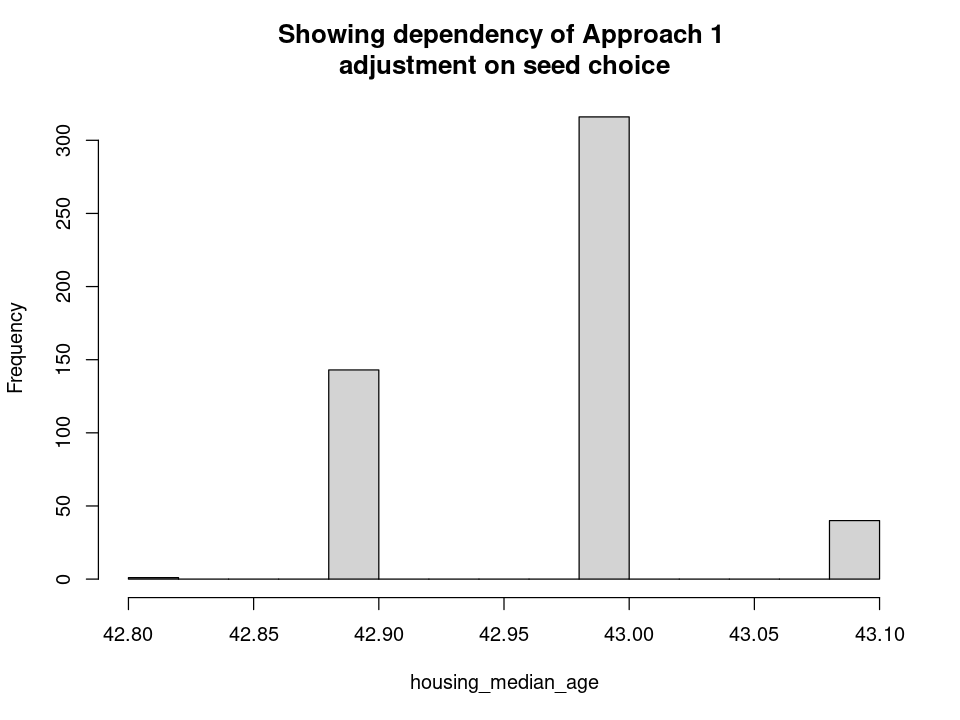

In [61]:
options(repr.plot.width= 8, repr.plot.height= 6)

hist(pred_means, breaks=18, main="Showing dependency of Approach 1 
adjustment on seed choice", xlab="housing_median_age", cex.main=1.3)


### Get RSS score for the adj02 method

In [57]:
n <- 500
set.seed(4331)
seeds <- sample(10000:99999, n, replace=FALSE)

adj02_rss_scores <- rep(NA, n)

# newpreds_adj and pred_names come from the Approach 2
# section above, where the Gibbs output is adjusted.
start <- Sys.time()
for(j in 1:n) {
    
    # Jitter the predictions.
    set.seed(seeds[j])
    preds_adj02 <- jitter(newpreds_adj-0.1, amount=0.9)
    names(preds_adj02) <- pred_names
    
    adj02_rss <- round(sum((actual_vals[rows_censored] - preds_adj02[rows_censored])^2))
    adj02_rss_scores[j] <- round(1 - adj02_rss/cap_rss, 4)
}
stop <- Sys.time()
round(stop - start, 2)

round(mean(adj02_rss_scores), 4)
round(sd(adj02_rss_scores), 4)
# 0.4355
# stddev: 0.002


Time difference of 0.35 secs

[1] 0.4355

[1] 0.002

In [58]:
summary(adj02_rss_scores)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.429   0.434   0.435   0.435   0.437   0.444 

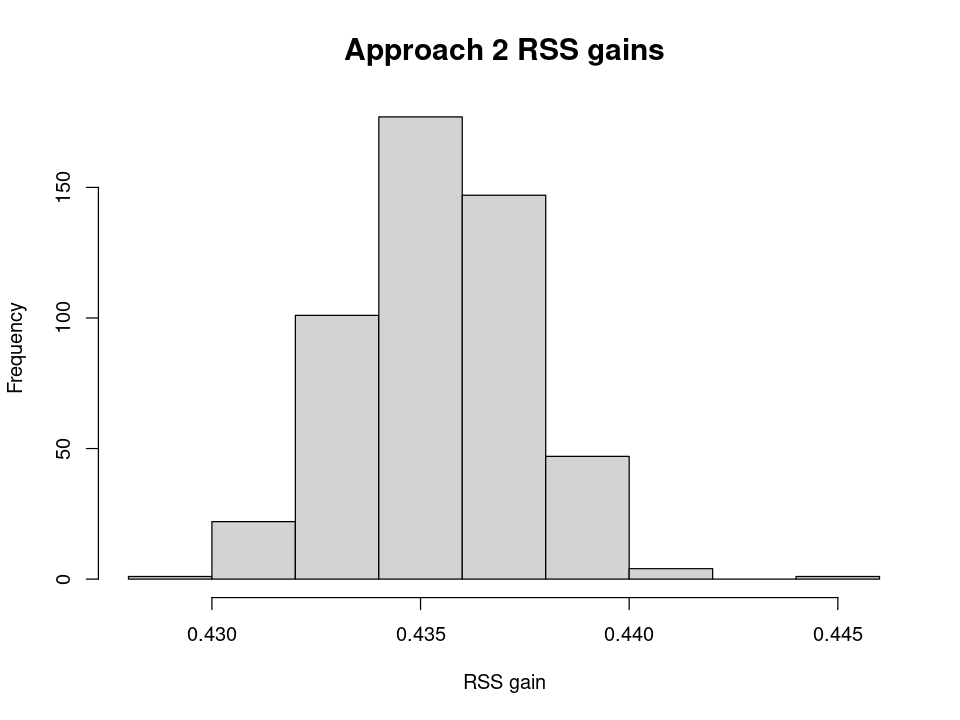

In [59]:
options(repr.plot.width= 8, repr.plot.height= 6)

hist(adj02_rss_scores, breaks=10, main="Approach 2 RSS gains",
     xlab="RSS gain", cex.main=1.5)


### Get RSS score for the adj03 output

In [113]:
n <- 500
set.seed(4331)
seeds <- sample(10000:99999, n, replace=FALSE)

adj03_rss_scores <- rep(NA, n)

# newpreds_adj and pred_names come from the Approach 2
# section above, where the Gibbs output is adjusted.
start <- Sys.time()
for(j in 1:n) {
    
    # Jitter the predictions.
    set.seed(seeds[j])
    preds_adj03 <- jitter(newpreds03-0.05, amount=0.95)
    names(preds_adj03) <- pred_names
    
    adj03_rss <- round(sum((actual_vals[rows_censored] - preds_adj03[rows_censored])^2))
    adj03_rss_scores[j] <- round(1 - adj03_rss/cap_rss, 4)
}
stop <- Sys.time()
round(stop - start, 2)

round(mean(adj03_rss_scores), 4)
round(sd(adj03_rss_scores), 4)
# 0.3997
# stddev: 0.0022


Time difference of 0.25 secs

[1] 0.3997

[1] 0.0022

In [116]:
rm(dfpreds)


In [114]:
summary(adj03_rss_scores)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.392   0.398   0.400   0.400   0.401   0.407 

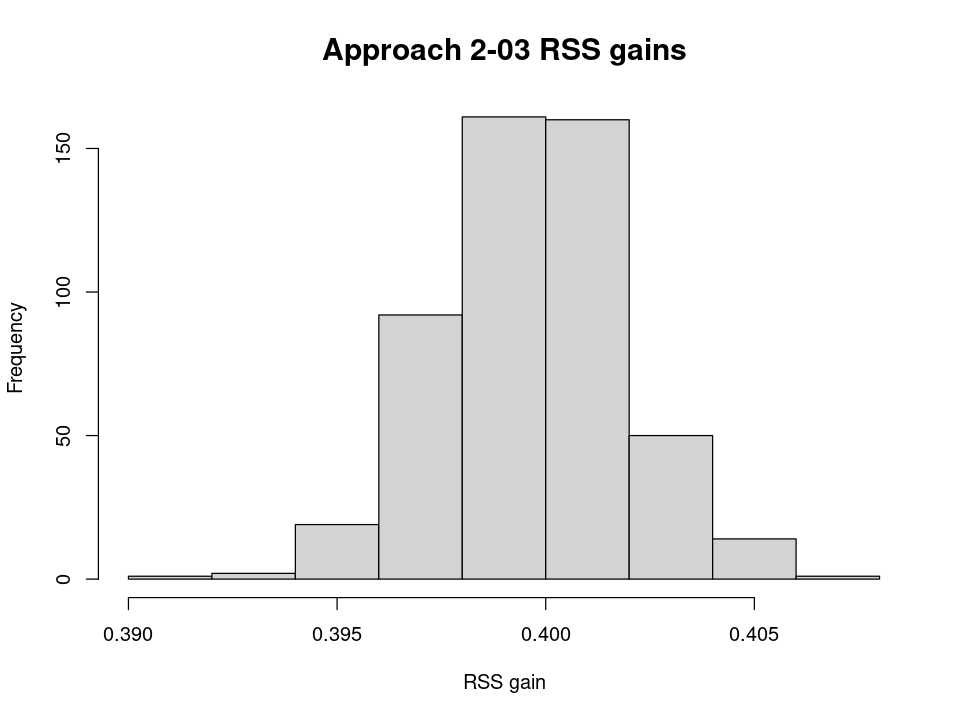

In [115]:
options(repr.plot.width= 8, repr.plot.height= 6)

hist(adj03_rss_scores, breaks=10, main="Approach 2-03 RSS gains",
     xlab="RSS gain", cex.main=1.5)


## Final Comments for Section 1

I have been employing a number of criteria when judging the quality of imputed values.  In a real-case scenario we will not have access to RSS scores.  Still, we can consider: (a) whether the mean of the imputed values is about where we expect it to be; (b) whether the distribution of the imputed values approximates the distribution we expect to see; and (c) whether variable relationships are maintained.  Regarding (c): if the variable with censored data is highly correlated with another variable in the dataset, the scatterplot for the two variables will show that correlation.  We want the pattern we see in the scatterplot below the cap to also be exhibited by the imputed values above the cap.  Since there are no variables in the CA housing dataset that are highly correlated with housing_median_age, almost no weight is given to criterion (c) when judging the quality of the imputation for the censored housing_median_ages.  Much more weight is given to (c) in Section 2 below.

We have seen that the raw output from the Gibbs sampler can be such that the mean of the predictions is not where we expect it to be.  We have also seen that the shape of this raw output is unlikely to approximate the shape we expect to see, at least not when we are imputing into a region that is at the end of a variable's range and the response variable, or some transformation of it, is assumed to be normally distributed.  Thus, we have seen that the raw output from a Gibbs sampler when imputing values may not be ideal or even close to what we expect per (a) and (b).

I have offered two methods for improving upon the raw Gibbs output.  The first directly addresses criterion (a) and may or may not help us better meet criterion (b).  The second addresses both (a) and (b).  But these improvements are of much less value if we cannot maintain the RSS gain we see with the raw Gibbs output.  For the housing_median_age imputation (artificially capping the data at age 38 and imputing for 3665 records into the range 38-51), the raw Gibbs output has an RSS gain of 37.0\% with a standard error of 1.1\%.  With the Approach 2 improvements, we see an RSS gain of 43.5\% with a standard error of 0.2\%.  Approach 1 shows an equally high gain: 43.8\% with a standard error of 1\%.  In this instance neither approach is clearly better than the other in terms of approximating the shape of the hypothesized distribution.  In a real-case scenario, we will not know the RSS scores, and so we would choose the approach that does a better job of approximating the shape of the hypothesized distribution.  

We have 1,268 records in the CA housing dataset with a censored housing_median_age at age 52.  Section 1 above suggests that we should be able to apply Approach 2 to the raw Gibbs output we obtain without undermining the RSS gain.  It makes sense that the quality of the imputed values improves if the mean of these values is close to the expected mean (and our prediction of the expected mean is accurate); we see above how high the RSS gain is when all imputed values are set to the expected mean and the expected mean is on target.  I have offered a method for getting an accurate prediction of the mean of the actual, unobserved values for which we are making predictions.

It also makes sense that the quality of the imputed values improves if the distribution of these values closely approximates the shape we expect to see, and if the shape we expect to see closely approximates the shape of the actual, unobserved values.  When we are imputing into the end of a variable's range, we often have a fairly good idea of what that shape is; e.g., we know the frequency counts go to zero at some point.  I have offered an algorithm that picks out predictions in a systematic fashion so that we get the shape and the mean we want and yet have reason to believe that we are not detracting from the RSS gain that we would see with the raw Gibbs output.  There are ways of adjusting the "parameters" of the algorithm---such as the bin size we are working with and the number of predictions generated (n_preds above) for each record for which we need an imputed value---so that we get a higher RSS gain and yet still approximate the expected distribution shape.  For the age data, the RSS gain of Approach 2 improves significantly when we increase the bin size from 1 year to 2 years.  When this increase to bin size is made, however, we have less control over the shape of the final output.  We can adjust the hypdist02 vector of counts to further control the shape of the final output but this risks undermining the RSS gain we see without such an adjustment.  Adjusting the hypdist02 counts to control the output shape is probably a bit like jittering in that it is more likely to detract from the RSS score than improve it.  More research needs to be done to see whether this is so.  I think in general there is a trade-off between attaining the hypothesized shape and getting a high RSS score; we already know that we can get a much higher RSS score by setting all imputed values to the predicted mean.  The problem with doing this is that we are nowhere near the hypothesized shape.


With the housing_median_age data and the median_house_value data in Section 2, we can artificially censor the data and run the imputation process to find out what our parameters for Approach 2 ought to be.  Or maybe we find out that the best we can do without undermining the RSS gain is to use Approach 1.  But keep in mind that what we learn about RSS gain when artificially censoring the data and applying these approaches can only give us a sense of the corresponding RSS gains we might see when doing the actual imputation.



                                           * * * * *





# Section 2: Compare RSS gain for the different outputs of Appendix B

In [ ]:
# Load some of the required packages.

require(repr)    # allows us to resize the plots
require(stringr)
require(ggplot2)
require(car)     # needed for diagnostic tools
require(arm)     # needed for Gibbs sampling used in imputation


In [2]:
options(digits = 5, show.signif.stars = F, 
        mc.cores=parallel::detectCores())


In [3]:
# This dataset contains imputed values for housing_median_age.  
# The imputation was done in Appendix A.

dat <- read.csv("/home/greg/Documents/stat/Geron_ML/datasets/housing/housing_cleaned_v03b.csv",
                header=TRUE, row.names=1,
                colClasses= c("character", rep("numeric", 9), "character",
                              rep("numeric", 5)))
dim(dat)


[1] 20603    15

In [4]:
colnames(dat)


[1] "longitude"          "latitude"           "housing_median_age"
 [4] "total_rooms"        "total_bedrooms"     "population"        
 [7] "households"         "median_income"      "median_house_value"
[10] "ocean_proximity"    "rooms_per_hh"       "bdrms_per_room"    
[13] "pop_per_hh"         "HHdens_ln"          "long_transf"

In [5]:
# Remove all records with a median_house_value >= 500K since these
# are imputed values.  Here I use 490K as our upper limit.

dat_noCap <- dat[which(dat$median_house_value <= 490000),]
nrow(dat_noCap)


[1] 19574

In [6]:
# Keep only the columns we need.

required_cols <- c("median_house_value","median_income","latitude","long_transf",
                   "pop_per_hh","housing_median_age","HHdens_ln")

dat_noCap <- dat_noCap[, required_cols]
dim(dat_noCap)


[1] 19574     7

In [7]:
# Create a dataset with censored median_house_values.  Censor at 300K.

censored_rows <- rownames(dat_noCap[which(dat_noCap$median_house_value >= 300000),])
length(censored_rows)

dat_wCap <- dat_noCap
dat_wCap[censored_rows,]$median_house_value <- 300000

# We have 2,833 records which will need an imputed value.


[1] 2833

In [8]:
# How much of the data is censored?

round(length(censored_rows)/nrow(dat_wCap), 3)
# 14.5 percent


[1] 0.145

In [9]:
# Number of records in dat_wCap that are not capped:

nrow(dat_wCap) - length(censored_rows)
# 16,741


[1] 16741

## Get prediction for the mean of the actual, unobserved values

### Create 15K bins for median_house_value

I start with 15K bins rather than, say, 10K bins because it is a bit easier to establish counts for a hypothesized distribution with the larger bins.

In [10]:
# Rename dat_wCap to dat since this is the dataset we will be mostly
# working with.

dat <- dat_wCap


In [11]:
# Let 15K be the lowest median_house_value in our dataset.

summary(dat$median_house_value)

dat[which(dat$median_house_value < 15000), c("median_house_value")] <- 15000


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  14999  116300  173400  181612  247575  300000 

In [12]:
cell_floors <- seq(from= 15000, to= 285000, by= 15000)
length(cell_floors)
names(cell_floors) <- paste(as.character(cell_floors/1000), "K", sep="")
print(cell_floors)


[1] 19

   15K    30K    45K    60K    75K    90K   105K   120K   135K   150K   165K 
 15000  30000  45000  60000  75000  90000 105000 120000 135000 150000 165000 
  180K   195K   210K   225K   240K   255K   270K   285K 
180000 195000 210000 225000 240000 255000 270000 285000 


In [13]:
# Function for obtaining the number of records in each 15K 
# interval.

get_rcd_counts <- function(med_houseVal, varRange, span=15000,
                           startpt=15000, endpt=990000) {  
    
    cell_floors <- seq(from=startpt, to=endpt, by=span)
    names(cell_floors) <- paste(as.character(cell_floors/1000), "K", sep="")
    
    cell_floors_tmp <- cell_floors[(as.numeric(cell_floors) >= varRange[1]) &
                                   (as.numeric(cell_floors) <= varRange[2])]
    
    # This function returns record counts up to, but not including,
    # varRange[2].
    n <- length(cell_floors_tmp) - 1
    counts <- rep(NA, n)
    for(i in 1:n) {
        lower <- as.numeric(cell_floors_tmp[i])
        upper <- as.numeric(cell_floors_tmp[i + 1])
        counts[i] <- length(med_houseVal[((med_houseVal >= lower) &
                                          (med_houseVal < upper))])
    }
    names(counts) <- names(cell_floors_tmp)[1:n]
    return(counts) 
}


In [14]:
observed_counts <- get_rcd_counts(dat$median_house_value, c(15000, 300000))

print(observed_counts)


 15K  30K  45K  60K  75K  90K 105K 120K 135K 150K 165K 180K 195K 210K 225K 240K 
  14   78  587  965 1025 1295 1205 1088 1284 1538 1234 1239  842  931  959  747 
255K 270K 285K 
 656  615  439 


In [15]:
# Get the number of records not captured in observed_counts.

nrow(dat) - (sum(observed_counts) + 2833)


[1] 0

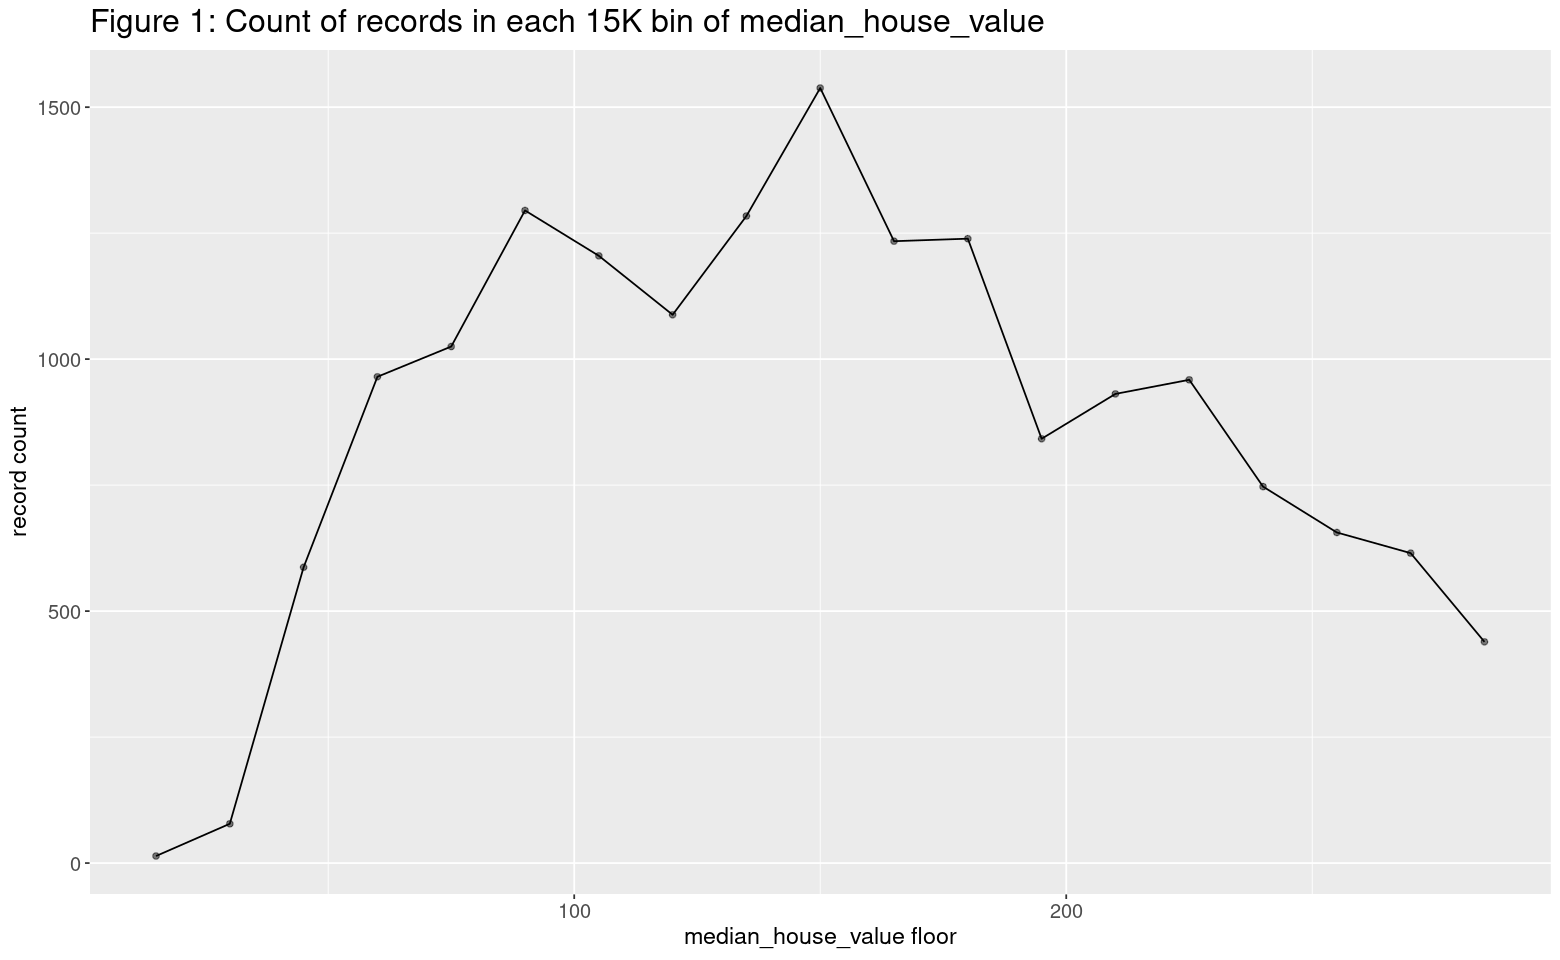

In [16]:
# Plot the counts.  This will give us a very general idea
# of what the distribution of counts might look like for the
# 2833 records which need an imputed value.  We are especially
# interested in the general shape of the distribution from
# around 150K onwards.

df_plot <- rep(NA, 2 * length(observed_counts))
dim(df_plot) <- c(length(observed_counts), 2)
df_plot <- as.data.frame(df_plot)
colnames(df_plot) <- c("cell", "count")

new_names <- str_replace_all(names(observed_counts), "[K]", "")
df_plot$cell <- as.numeric(new_names)
df_plot$count <- as.numeric(observed_counts)


options(repr.plot.width= 13, repr.plot.height= 8)

p <- ggplot(df_plot, aes(cell, count)) +
  geom_point(alpha= 0.5) + xlab("median_house_value floor") + 
  ylab("record count") +
  geom_line() +
  ggtitle("Figure 1: Count of records in each 15K bin of median_house_value") +
  theme(axis.text= element_text(size = 12)) +
  theme(axis.title= element_text(size= 14)) +
  theme(title= element_text(size= 16))
p


In [ ]:
### COMMENTS:

# As median_house_value increases beyond 285K, we expect the record
# count to continue its downward trend, for there will be fewer districts
# with a high median house value.  In other words, beyond a certain
# point, record count will tend to be inversely proportional to 
# median_house_value.


## Hypothesized distribution

We have an idea of what the general shape of the distribution of median house values will look like >= 300K.  It is important to make this "general idea" concrete.  Doing so provides us with a reference point against which we can judge the plausibility of the model predictions that follow (model predictions for the mean of the actual, unobserved values >= 300K).  This knowledge, or information, is something that is not found in the Gibbs sampler algorithm. 

In Appendix B I used 10K-sized bins for modeling purposes.  For the moment I will stick with the 15K-sized bins since both 300K and 480K (see next cell) are divisible by 15.

Ordinarily one would not know how far out the actual distribution of values goes.



                                         * * * * *

In [17]:
# Create an example distribution for the expected range of
# imputation.  When imputing for the 500K censored values,
# I went out 1.65 * 500K, to 825K.  So here I will do the same:
# 1.65 * 300K = 495K.

bins <- seq(300000, 480000, by= 15000)
bin_names <- paste(as.character(bins/1000), "K", sep="")
names(bins) <- bin_names
names(bins)
length(bins)
# 13


[1] "300K" "315K" "330K" "345K" "360K" "375K" "390K" "405K" "420K" "435K"
[11] "450K" "465K" "480K"

[1] 13

In [18]:
# We have 2833 records to distribute among 13 bins.  The only rule
# I use for assigning counts to the bins is that the counts nearly
# always decrease.  Because we know median house values go out 
# beyond 500K, and likely even over 700K, the downward trend for
# this hypothesized distribution should not be too strong.

bin_counts <- c(370, 340, 320, 280, 250, 233, 210, 180, 160, 145, 130, 
                120, 95)
sum(bin_counts)
sum(bin_counts) == 2833


[1] 2833

[1] TRUE

In [19]:
# Construct a dataframe for plotting the example distribution.

all_names <- c(df_plot$cell[11:19], bin_names)
observed <- df_plot$count[11:19]

all <- c(observed, bin_counts)
n <- length(all)

dftmp <- rep(NA, 2 * n)
dim(dftmp) <- c(n, 2)
dftmp <- as.data.frame(dftmp)
colnames(dftmp) <- c("cell", "count")
dftmp$cell <- all_names
dftmp$count <- all

dftmp$hhval <- as.numeric(str_replace_all(dftmp$cell, "[K]", ""))

head(dftmp); tail(dftmp)


,cell,count,hhval
,<chr>,<dbl>,<dbl>
1,165,1234,165
2,180,1239,180
3,195,842,195
4,210,931,210
5,225,959,225
6,240,747,240


,cell,count,hhval
,<chr>,<dbl>,<dbl>
17,405K,180,405
18,420K,160,420
19,435K,145,435
20,450K,130,450
21,465K,120,465
22,480K,95,480


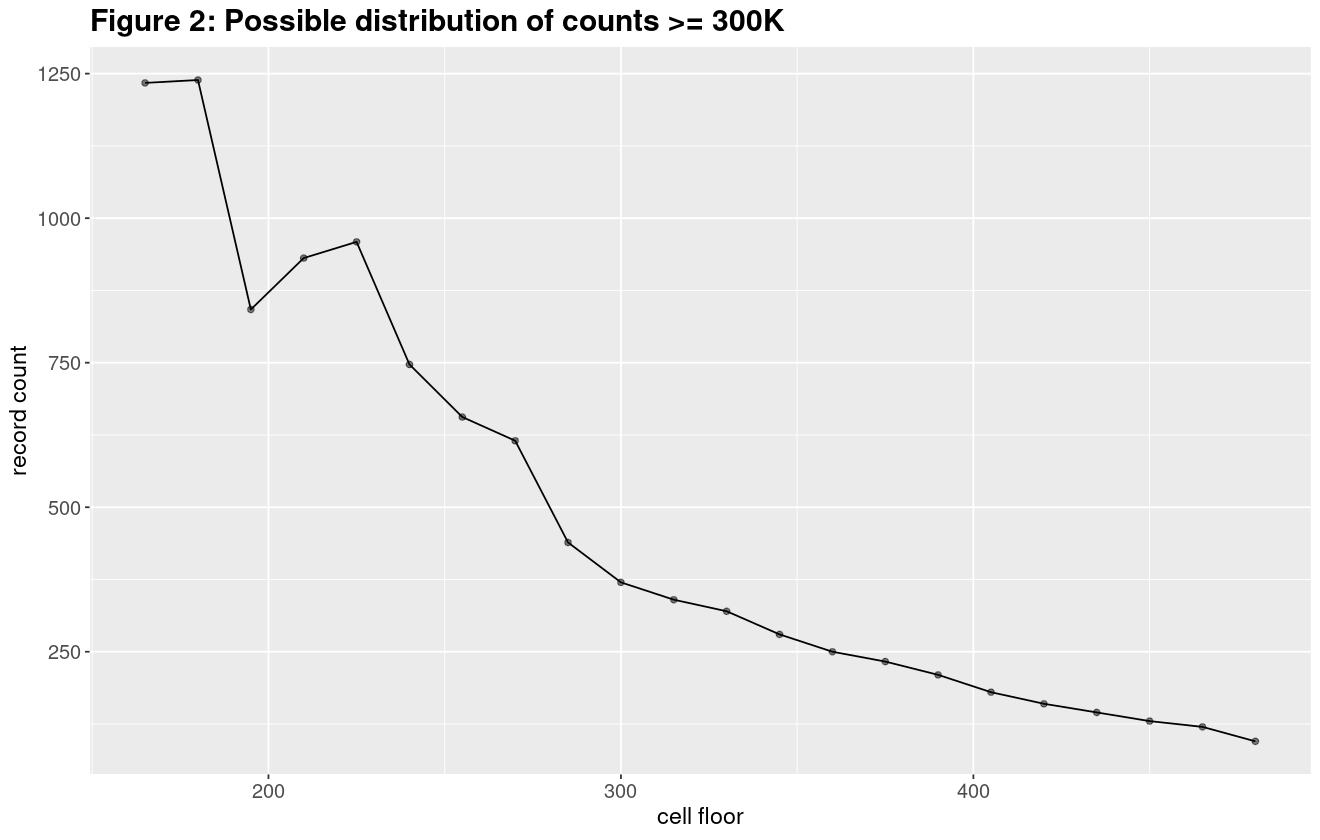

In [20]:
# Plot showing possible distribution of 2833 districts 
# with a median_house_value >= 300K.

options(repr.plot.width= 11, repr.plot.height= 7)

p <- ggplot(dftmp, aes(hhval, count)) +
  geom_point(alpha= 0.5) + xlab("cell floor") + ylab("record count") +
  geom_line() +
  ggtitle("Figure 2: Possible distribution of counts >= 300K") +
  theme(axis.text= element_text(size = 12)) +
  theme(axis.title= element_text(size= 14)) +
  theme(plot.title= element_text(size= 18, face='bold',colour='black'))
p


### Construct 10K bins

For the second method of adjusting the raw Gibbs output (Approach 2) I may need to use 10K rather than 15K bins in order to better approximate the expected distribution for the imputed values.  Bin size also has an impact on RSS gain.

In [21]:
# It is easiest to first convert to 5K bins.

bins5K <- seq(300000, 490000, by= 5000)
bins5K_names <- paste(as.character(bins5K/1000), "K", sep="")
names(bins5K) <- bins5K_names
length(bins5K)


[1] 39

In [22]:
# Compute refined distribution.  The following loop divides
# each 15K bin count up into three 5K bin counts.

bins5K_counts <- rep(NA, length(bins5K))

index <- 1
for(i in 1:length(bins)) {
    
    curbin_count <- as.numeric(bin_counts[i])
    mid <- round(curbin_count/3)
    incr <- round(0.05 * mid)
    high <- mid + incr
    low <- curbin_count - (mid + high)
    
    bins5K_counts[index] <- high
    bins5K_counts[index + 1] <- mid
    bins5K_counts[index + 2] <- low
    index <- index + 3
}


In [23]:
tbl <- bins5K_counts
names(tbl) <- bins5K_names
print(tbl)


300K 305K 310K 315K 320K 325K 330K 335K 340K 345K 350K 355K 360K 365K 370K 375K 
 129  123  118  119  113  108  112  107  101   98   93   89   87   83   80   82 
380K 385K 390K 395K 400K 405K 410K 415K 420K 425K 430K 435K 440K 445K 450K 455K 
  78   73   74   70   66   63   60   57   56   53   51   50   48   47   45   43 
460K 465K 470K 475K 480K 485K 490K 
  42   42   40   38   34   32   29 


In [24]:
# Create 10K bins.

bins10K <- seq(300000, 490000, by= 10000)
bins10K_names <- paste(as.character(bins10K/1000), "K", sep="")
names(bins10K) <- bins10K_names
length(bins10K)


[1] 20

In [25]:
# Assign counts to the 10K bins.

bins10K_counts <- rep(NA, length(bins10K))

index <- 0
for(i in 1:length(bins10K)) {
    
    index <- index + 1
    if(i==length(bins10K)) {
        
        bins10K_counts[i] <- as.numeric(bins5K_counts[index])
        
    } else {
        
        firstbin_count <- as.numeric(bins5K_counts[index])
        index <- index + 1
        secondbin_count <- as.numeric(bins5K_counts[index])
        bins10K_counts[i] <- firstbin_count + secondbin_count
    }
}
sum(bins10K_counts)
sum(bins10K_counts)== 2833


[1] 2833

[1] TRUE

In [26]:
tbl <- bins10K_counts
names(tbl) <- bins10K_names
print(tbl)


300K 310K 320K 330K 340K 350K 360K 370K 380K 390K 400K 410K 420K 430K 440K 450K 
 252  237  221  219  199  182  170  162  151  144  129  117  109  101   95   88 
460K 470K 480K 490K 
  84   78   66   29 


In [27]:
series <- seq(300, 490, by=10)
vals <- rep(series, bins10K_counts)
round(mean(vals), 1)
# 370.4


[1] 370.4

In [28]:
# A better way to get an average is to 
# multiply by the value at the middle of each bin.

series <- seq(305, 495, by=10)
vals <- rep(series, bins10K_counts)
round(mean(vals), 1)
# 375.4


[1] 375.4

In [29]:
# Adjust the above numbers a bit so the drop in 
# counts is more even.  I also want the mean to be
# closer to 370K since model-based estimates have
# all tended to be lower.  (The first prediction from
# the hypothetical distribution has initial priority.
# In this instance, however, a number of different
# models produced 95% prediction intervals which
# covered the first prediction, but the prediction
# was always near the upper limit of the prediction
# intervals.  So here I am striving to achieve a 
# balance between the first prediction from the 
# hypothetical distribution and the predictions I
# have gotten from a range of models.  Otherwise I
# simply have to ignore what the models are showing,
# and this means ignoring what the data below the
# cap is telling us.)

bins10K_counts <- c(260, 248, 236, 224, 214, 204, 195, 185, 169, 153, 134,
                    120, 106, 94, 83, 68, 55, 40, 30, 15)
names(bins10K_counts) <- bins10K_names
sum(bins10K_counts)
sum(bins10K_counts)== 2833


[1] 2833

[1] TRUE

In [30]:
df10K <- rep(NA, 2 * length(bins10K))
dim(df10K) <- c(length(bins10K), 2)
df10K <- as.data.frame(df10K)
colnames(df10K) <- c("cell", "count")
df10K$cell <- bins10K_names
df10K$count <- bins10K_counts
df10K$hhval <- as.numeric(str_replace_all(df10K$cell, "[K]", ""))


In [31]:
# Compute the mean of the revised hypothetical distribution. 
# The mean should be close to 370K since this is about what
# our model prediction will be.

newvals <- c()
for(i in 1:nrow(df10K)) {

    n <- df10K$count[i]
    lower <- df10K$hhval[i]
    upper <- lower + 9.98
    
    seed <- set.seed(4321 + i)
    vals <- round(runif(n, lower, upper))
    newvals <- c(newvals, vals)
}

length(newvals)
# 2833
round(mean(newvals), 1)
# 369.2


[1] 2833

[1] 369.2

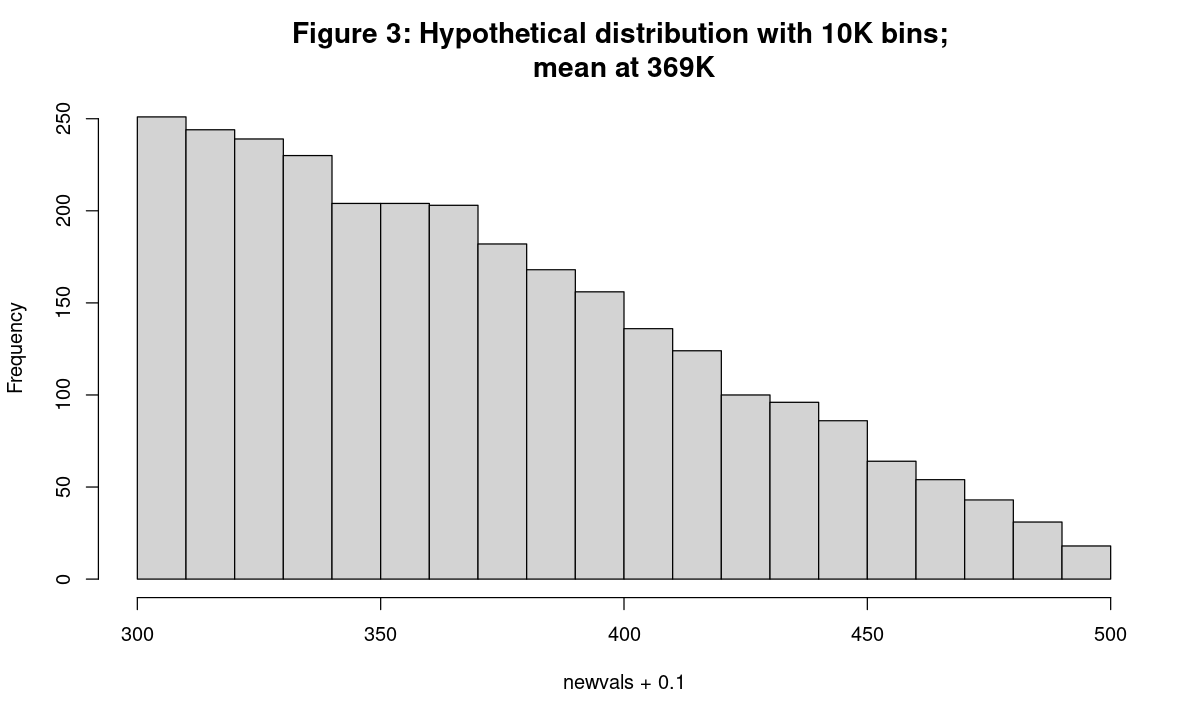

In [32]:
options(repr.plot.width= 10, repr.plot.height= 6)

hist(newvals + 0.1, breaks=20, main="Figure 3: Hypothetical distribution with 10K bins; 
mean at 369K",
     cex.main= 1.4)


In [33]:
# We have 2833 imputed values.

imputed_vals_tmp <- 1000*newvals


In [34]:
tbl <- bins10K_counts
names(tbl) <- bins10K_names
print(tbl)


300K 310K 320K 330K 340K 350K 360K 370K 380K 390K 400K 410K 420K 430K 440K 450K 
 260  248  236  224  214  204  195  185  169  153  134  120  106   94   83   68 
460K 470K 480K 490K 
  55   40   30   15 


In [ ]:
### COMMENTS:

# Following Appendix A and Appendix B, I rely on Figures 2 and 3
# for judging the plausibility of the predicted means using the
# models that follow.


## Compute shift-increment ratios for the mean using a 210K window

Use a rolling window of 210K.  This window captures all of the current example distribution of the imputed  values when we are at the cap of 300K.  Compute data from 60K - 210K.  Although this takes us into the region of imputed values (we make use of the hypothesized distribution), most of the data for the last few 210K windows will still be observed rather than imputed.  E.g., for the very last span, \[210K, 420K), imputed values make up 32.5\% of the data.

See the discussion in Appendix B regarding the size of the window used for computing shift-increment ratios.  The larger the window, the larger the ratios become, which in turn means that our prediction for the mean of the actual, unobserved values might be biased---i.e., too high.  If the window is too small, we can get a bias in the other direction.  So how do we know what the appropriate window size should be?  We have an appropriate window size if we get a model prediction that is reasonably close to the mean of our hypothesized distribution.  E.g., we expect our 95\% prediction interval to include the 369K prediction we already have.  If I use a 225K window (when using 15K bins), the lower bound for my 95\% prediction interval is 403K; this is 34K more than the 369K prediction we have from the hypothesized distribution.  The next best choice is to try 210K-sized windows.


In [35]:
bins <- seq(60000, 210000, by= 10000)
bin_names <- paste(as.character(bins/1000), "K", sep="")
names(bins) <- bin_names
length(bins)


[1] 16

In [36]:
# See Figure 3b.
summary(newvals)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    300     328     362     369     403     499 

In [37]:
# Combine the newly imputed values with the median house
# values in dat that are not censored.

all_hh_median_vals <- c(dat[which(dat$median_house_value < 300000), c("median_house_value")],
                        imputed_vals_tmp)
length(all_hh_median_vals)
summary(all_hh_median_vals)


[1] 19574

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  15000  116300  173400  191623  247575  499000 

In [38]:
# Compute the means for each bin, using a 210K window.  Note that 210K
# is divisible by 10K, the size of each median_house_value bin.
# (This is important because it means that we are never breaking
# a bin apart when calling get_rcd_counts in the loop below.)  Also,
# note that 300K + 210K = 510K, meaning that the expected range of
# imputation is covered.

mean_ratios <- rep(NA, length(bins))
means <- rep(NA, length(bins))
rcd_count <- rep(NA, length(bins))

span <- 210000
index <- 0
for(floor in bins) {
    
    index <- index + 1
    hhvals <- as.numeric(all_hh_median_vals[which((all_hh_median_vals >= floor) &
                                                  (all_hh_median_vals < (floor + span)))])
    counts <- as.numeric(get_rcd_counts(hhvals, c(floor, floor+span), 
                                        span=10000, startpt=60000))
    rcd_count[index] <- sum(counts)
    
    # Compute mean.
    hhval_mean <- round(mean(hhvals), 5)
    mean_ratios[index] <- round(hhval_mean/floor, 3)
    means[index] <- hhval_mean

}

paste0("These are the 210K shift increments for the means: ")
names(mean_ratios) <- bin_names
print(mean_ratios)


[1] "These are the 210K shift increments for the means: "

  60K   70K   80K   90K  100K  110K  120K  130K  140K  150K  160K  170K  180K 
2.634 2.364 2.150 1.989 1.871 1.766 1.685 1.612 1.554 1.505 1.473 1.449 1.423 
 190K  200K  210K 
1.404 1.383 1.356 


In [39]:
# Construct dataframe for plotting, etc.

df_ratios <- rep(NA, 4*length(mean_ratios))
dim(df_ratios) <- c(length(mean_ratios), 4)
df_ratios <- as.data.frame(df_ratios)
colnames(df_ratios) <- c("cell", "rcds","mean", "mean_ratio")
df_ratios$cell <- bins
df_ratios$rcds <- rcd_count
df_ratios$mean_ratio <- mean_ratios
df_ratios$mean <- means


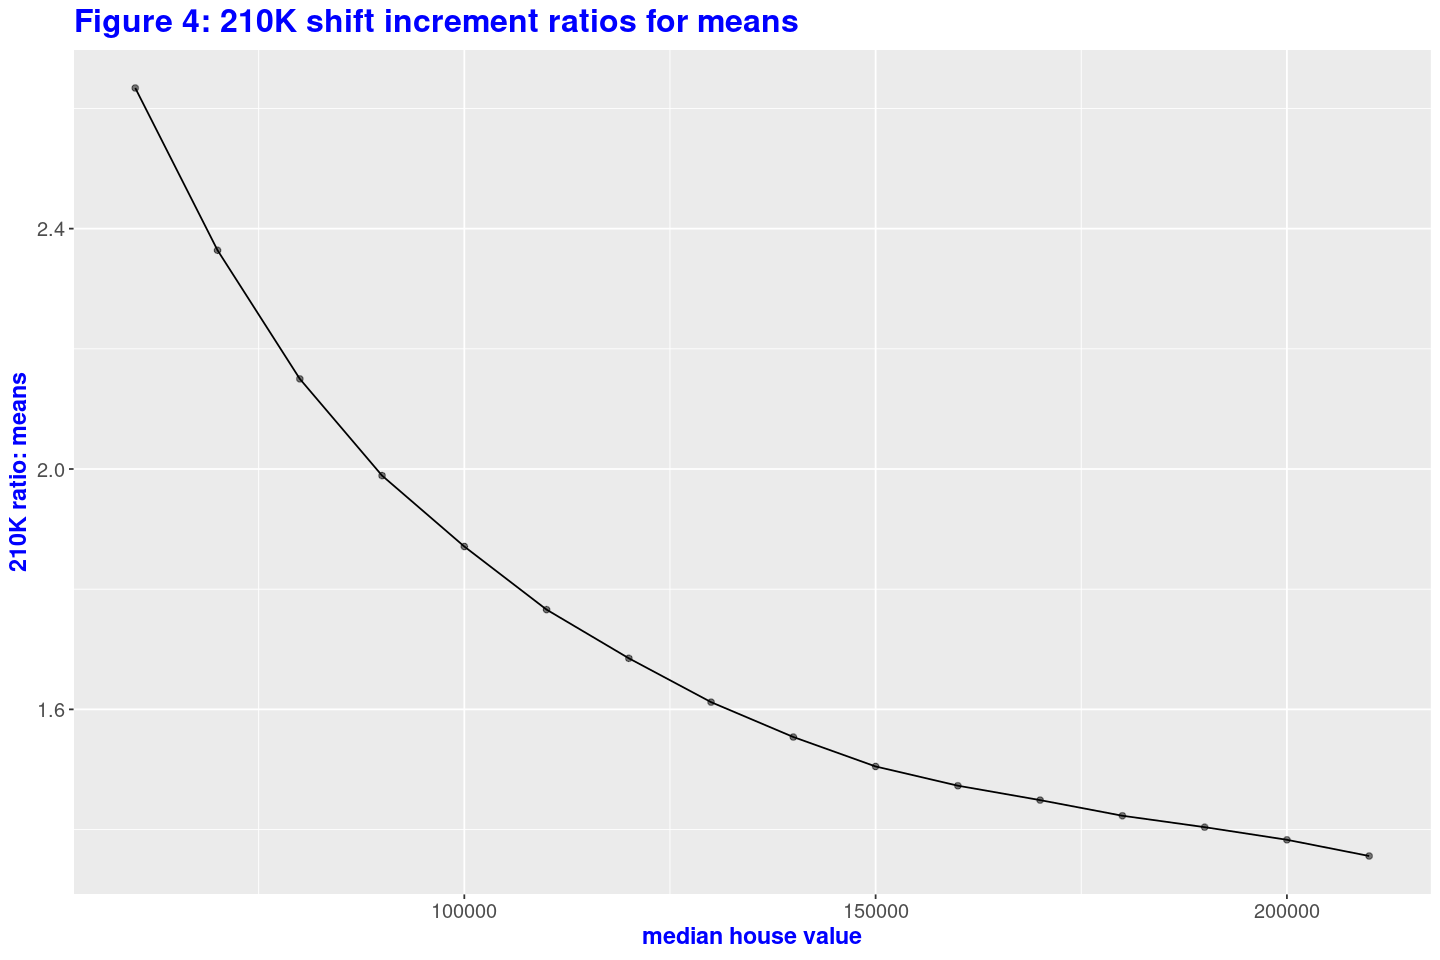

In [40]:
options(repr.plot.width= 12, repr.plot.height= 8)

p <- ggplot(df_ratios, aes(cell, mean_ratio)) +
  geom_point(alpha= 0.5) + xlab("median house value") + 
  ylab("210K ratio: means") +
  geom_line() +
  ggtitle("Figure 4: 210K shift increment ratios for means") +
  theme(axis.text= element_text(size = 12)) +
  theme(axis.title= element_text(size= 14)) +
  theme(title= element_text(size= 16, face='bold',colour='blue'))
p


### Digression: Investigate 1.6X shift-increment ratios

The ideal window for each cell floor is to look out around 1.6 times the value of the cell floor.  The vast majority of predictions for the imputation range will likely lie within this distance from the cell floor.  But if we use such a window, we can end up with a curve which is more difficult to model.  This is why the 210K window is used instead.  See Appendix A for an example of a 1.6X shift-increment ratio series which has none of the smoothness of the curve in Figure 4 above.  

I explore the 1.6X ratios here simply for pedagogic/comparative purposes.

In [41]:
# 1.6 * 260K = 416K.  For the 210K windows we looked out to 420K.
# By collecting data up to 260K rather than just 210K, the 1.6X 
# ratios make use of the hypothetical distribution to about the 
# same extent as when we use the 210K windows.

# I start the series at 120K rather than 60K so that the beginning
# of the series does not have ratios that are highly variable due
# to not looking out far enough.

bins02 <- seq(120000, 260000, by= 10000)
bin_names02 <- paste(as.character(bins02/1000), "K", sep="")
names(bins02) <- bin_names02
length(bins02)


[1] 15

In [42]:
mean_ratios02 <- means02 <- rcd_count02 <- rep(NA, length(bins02))

span02 <- 1.6
index <- 0
for(floor in bins02) {
    
    index <- index + 1
    hhvals <- as.numeric(all_hh_median_vals[which((all_hh_median_vals >= floor) &
                                                  (all_hh_median_vals < (floor * span02)))])
    counts <- as.numeric(get_rcd_counts(hhvals, c(floor, floor*span02),
                                        span=10000))
    rcd_count02[index] <- sum(counts)
    
    # Compute mean.
    hhval_mean <- round(mean(hhvals), 5)
    mean_ratios02[index] <- round(hhval_mean/floor, 3)
    means02[index] <- hhval_mean

}

paste0("These are the 1.6X shift increments for the means: ")
names(mean_ratios02) <- bin_names02
print(mean_ratios02)


[1] "These are the 1.6X shift increments for the means: "

 120K  130K  140K  150K  160K  170K  180K  190K  200K  210K  220K  230K  240K 
1.306 1.281 1.272 1.267 1.264 1.266 1.262 1.256 1.248 1.237 1.233 1.238 1.239 
 250K  260K 
1.239 1.238 


In [ ]:
### COMMENT:

# The above series suggests that we can expect a 1.6X ratio 
# at 300K of < 1.25.  1.25 * 300K = 375K.  The ratio might
# be as low as 1.20.  1.20 * 300K = 360K.  Thus, according
# to this series of numbers, we can very roughly estimate
# the mean to be between 360K and 375K.


In [43]:
# Construct dataframe for plotting both curves.
# There are now 31 rows of data to plot.

dfplot <- rep(NA, 2*31)
dim(dfplot) <- c(31, 2)
dfplot <- as.data.frame(dfplot)
colnames(dfplot) <- c("cell", "mean_ratio")

dfplot$cell[1:16] <- bins
dfplot$mean_ratio[1:16] <- mean_ratios
dfplot$cell[17:31] <- bins02
dfplot$mean_ratio[17:31] <- mean_ratios02

dfplot$window <- ""
dfplot$window[1:16] <- "210K"
dfplot$window[17:31] <- "1.6X"


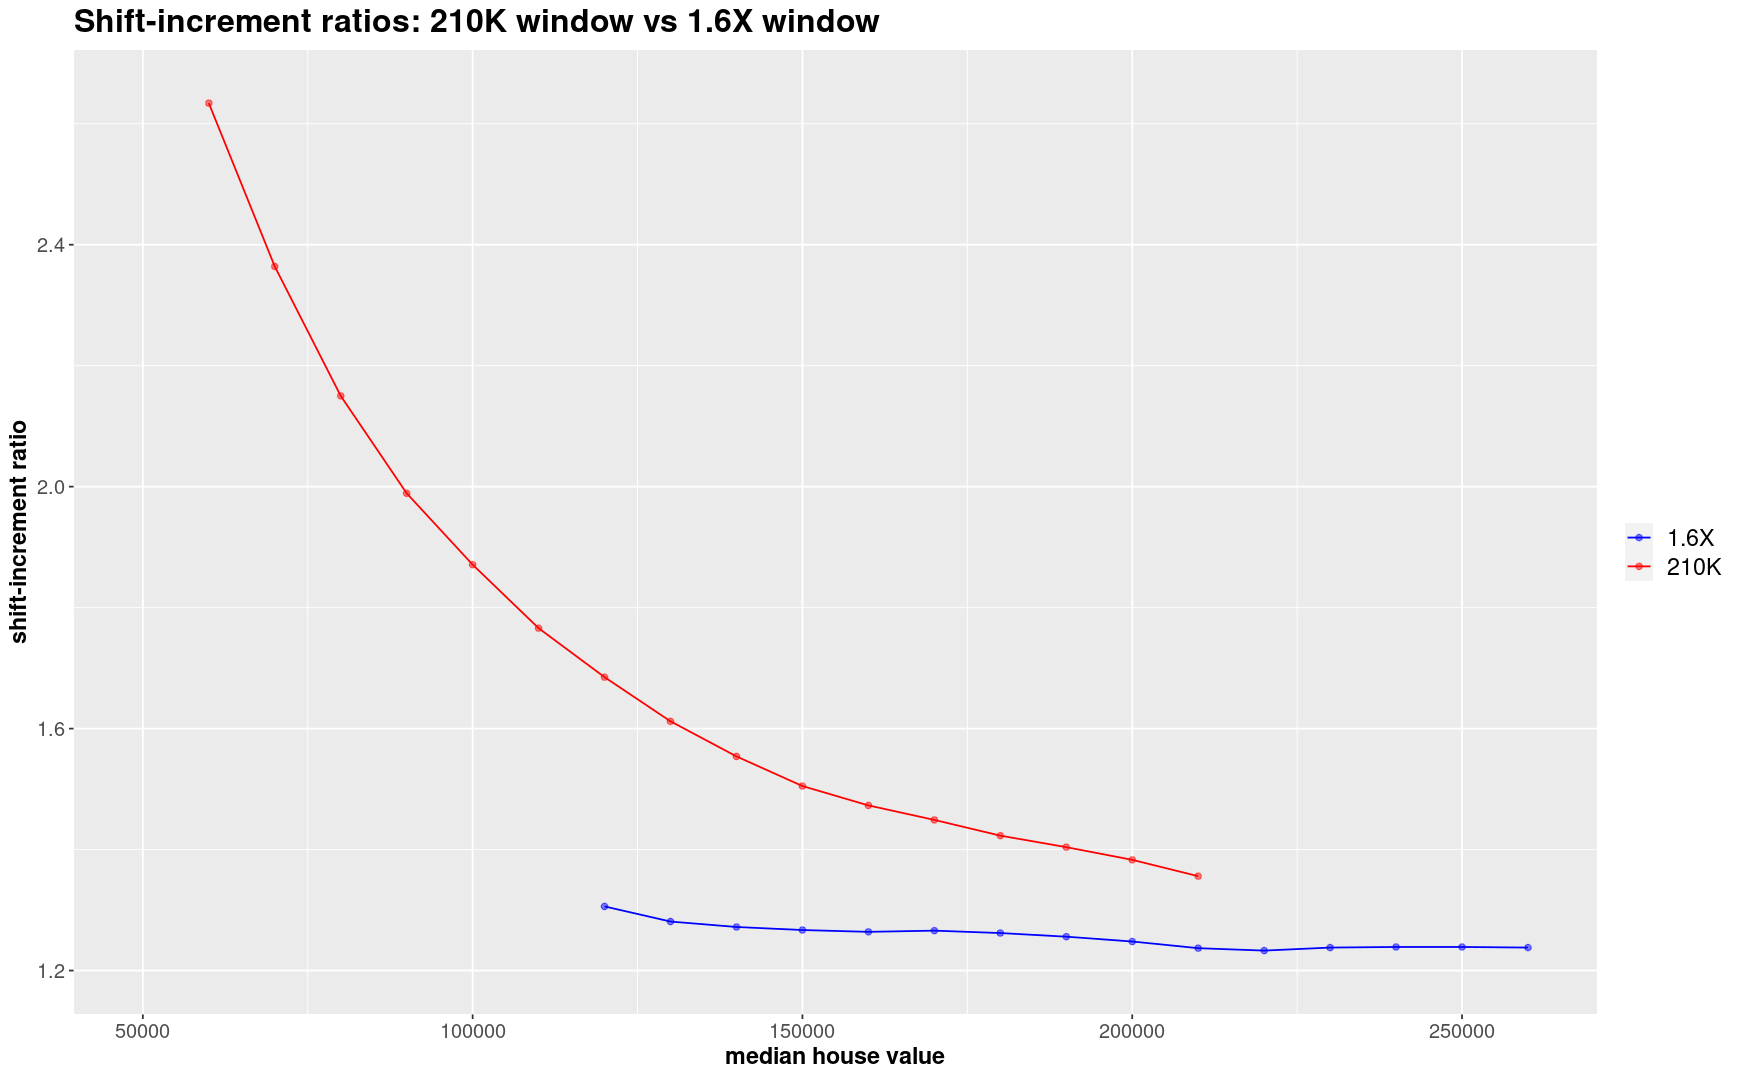

In [44]:
options(repr.plot.width= 14.5, repr.plot.height= 9)

p <- ggplot(dfplot, aes(cell, mean_ratio, color= factor(window))) +
  geom_point(alpha= 0.5) + xlab("median house value") + 
  ylab("shift-increment ratio") +
  xlim(50000, 260000) + ylim(1.2, 2.65) +
  labs(color= "") +
  scale_color_manual(labels = c("1.6X", "210K"), values = c("blue", "red")) +
  geom_line() +
  ggtitle("Shift-increment ratios: 210K window vs 1.6X window") +
  theme(axis.text= element_text(size = 12)) +
  theme(axis.title= element_text(size= 14)) +
  theme(legend.text= element_text(size=14)) +
  theme(title= element_text(size= 16, face='bold',colour='black'))
p


In [45]:
# Try to model the 1.6X curve.  It looks like it would be 
# easier to model the blue curve, but the above plot is very
# deceiving.  If we look at the blue curve with ylim
# between 1.2 and 1.35, it will look much more like the 
# red curve, except far less smooth (non-monotonic, jagged).

df_ratios02 <- dfplot[17:31, c("cell", "mean_ratio")]


In [122]:
f01 <- lm(I(mean_ratio)^0.3 ~ I(cell^0.02) + 
          I((cell^0.02)^2), data= df_ratios02)
ans <- summary(f01)
ans[[1]] <- ""; ans



Call:
""

Residuals:
      Min        1Q    Median        3Q       Max 
-0.002230 -0.001315  0.000225  0.001023  0.002014 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)
(Intercept)          50.8       19.8    2.56    0.025
I(cell^0.02)        -77.3       31.2   -2.48    0.029
I((cell^0.02)^2)     30.1       12.2    2.46    0.030

Residual standard error: 0.00155 on 12 degrees of freedom
Multiple R-squared:  0.924,	Adjusted R-squared:  0.912 
F-statistic: 73.2 on 2 and 12 DF,  p-value: 1.88e-07


In [123]:
ncvTest(f01)


Non-constant Variance Score Test 
Variance formula: ~ fitted.values 
Chisquare = 0.68325, Df = 1, p = 0.408

In [124]:
residualPlots(f01, plot=FALSE)


                 Test stat Pr(>|Test stat|)
I(cell^0.02)         -0.43             0.68
I((cell^0.02)^2)     -0.22             0.83
Tukey test            0.48             0.63


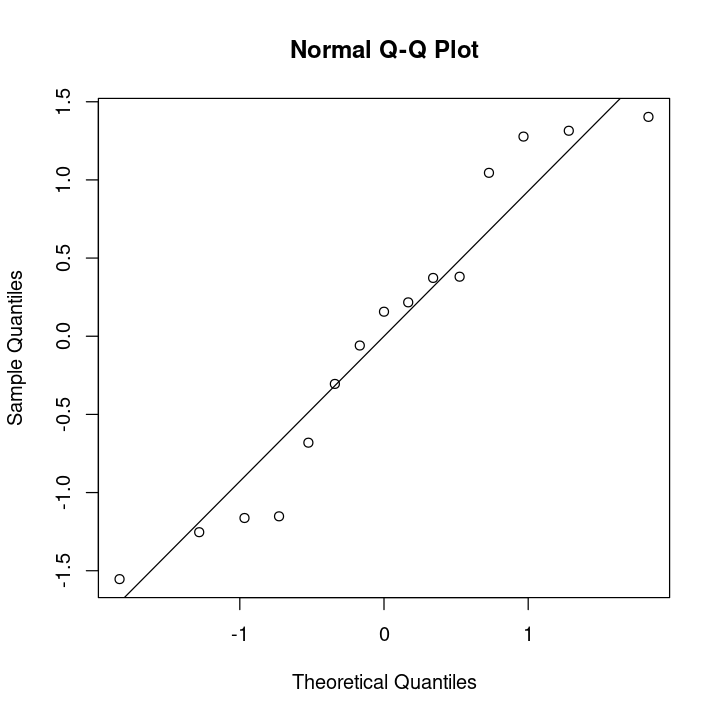

In [125]:
# This q-q plot does not inspire confidence for the kind
# of prediction we need to make.

options(repr.plot.width= 6, repr.plot.height= 6)

ans <- qqnorm(scale(residuals(f01, type= "pearson")))
qqline(ans$x, probs = c(0.25, 0.75))


In [129]:
# But the prediction is very plausible.

newdat <- df_ratios02[1, ]
newdat[1, ] <- c(300000, NA)

ans <- predict.lm(f01, newdata= newdat, type= "response")
ans_transf <- ans^(1/0.3); ans_transf
# 1.2344

# 1.2344 * 300 = 370.3K


17 
1.2344

In [127]:
# Compute a 95% CI for this prediction.

pred_ans <- predict.lm(f01, newdata= newdat, interval="prediction",
                       level=0.95)
pred_ans_transf <- pred_ans^(1/0.3); pred_ans_transf


,fit,lwr,upr
1,1.2344,1.2138,1.2553


In [128]:
lwr <- round(pred_ans_transf[2] * 300)
upr <- round(pred_ans_transf[3] * 300)

clause <- "95% prediction interval for estimate of the mean of the actual, unobserved values: "
print_ans <- paste0("[", lwr, "K, ", upr ,"K]")
paste0(clause, print_ans)
# [364K, 377K]


[1] "95% prediction interval for estimate of the mean of the actual, unobserved values: [364K, 377K]"

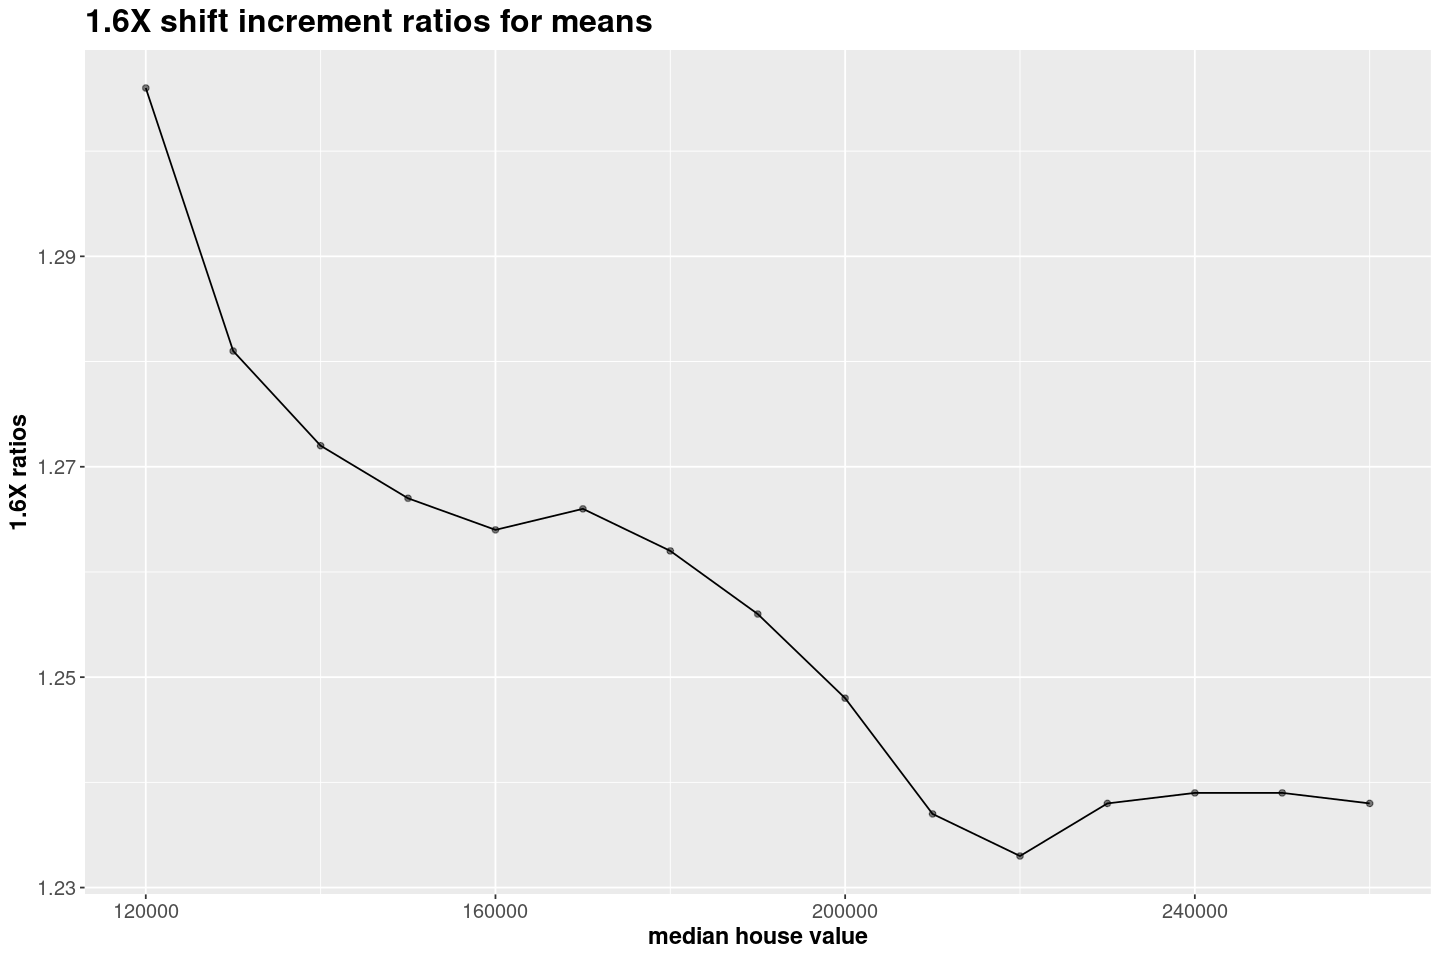

In [130]:
# The following plot shows how the 1.6X ratios can 
# look a bit like the Figure 4 plot above, minus the
# smoothness.

options(repr.plot.width= 12, repr.plot.height= 8)

p <- ggplot(df_ratios02, aes(cell, mean_ratio)) +
  geom_point(alpha= 0.5) + xlab("median house value") + 
  ylab("1.6X ratios") +
  geom_line() +
  ggtitle("1.6X shift increment ratios for means") +
  theme(axis.text= element_text(size = 12)) +
  theme(axis.title= element_text(size= 14)) +
  theme(title= element_text(size= 16, face='bold',colour='black'))
p


## Construct a model based on the 210K window ratios

In [131]:
# Check the number of records at each of the 16 measurement points.

df_ratios$rcds


[1] 15008 14837 14575 14072 13404 12914 12306 11813 11170 10572  9807  8990
[13]  8353  7657  7099  6688

In [279]:
# g02 is a better model for predicting the mean_ratio at 300K.

g02 <- lm(I(mean_ratio^0.55) ~  I(cell^-1.06) , 
          data= df_ratios)

ans <- summary(g02)
ans[[1]] <- ""; ans



Call:
""

Residuals:
      Min        1Q    Median        3Q       Max 
-0.008526 -0.005090  0.000879  0.004097  0.006377 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)
(Intercept)   9.88e-01   3.18e-03     310   <2e-16
I(cell^-1.06) 8.38e+04   6.89e+02     122   <2e-16

Residual standard error: 0.00502 on 14 degrees of freedom
Multiple R-squared:  0.999,	Adjusted R-squared:  0.999 
F-statistic: 1.48e+04 on 1 and 14 DF,  p-value: <2e-16


In [280]:
ncvTest(g02)


Non-constant Variance Score Test 
Variance formula: ~ fitted.values 
Chisquare = 0.02505, Df = 1, p = 0.874

In [281]:
residualPlots(g02, plot=FALSE)


              Test stat Pr(>|Test stat|)
I(cell^-1.06)      0.02             0.99
Tukey test         0.02             0.99


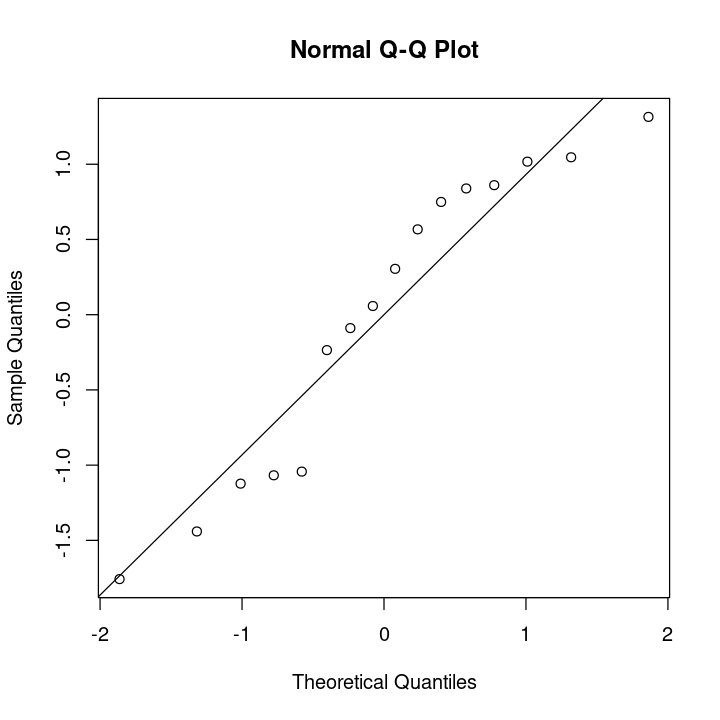

In [282]:
options(repr.plot.width= 6, repr.plot.height= 6)

ans <- qqnorm(scale(residuals(g02, type= "pearson")))
qqline(ans$x, probs = c(0.25, 0.75))


In [284]:
# Prediction for mean for the median house values
# in the interval [300K, 510K].

newdat <- df_ratios[1, ]
newdat[1, ] <- c(300000, rep(NA, 3))

ans <- predict.lm(g02, newdata= newdat, type= "response")
ans_transf <- ans^(1/0.55); ans_transf
# 1.22585

# 1.22585 * 300K = 367.8K.


1 
1.2259

In [ ]:
### COMMENT:

# The 368K prediction confirms the 369K prediction we have
# from the hypothesized distribution.


In [285]:
# Compute a 95% CI for this prediction.

pred_ans <- predict.lm(g02, newdata= newdat, interval="prediction",
                       level=0.95)
pred_ans_transf <- pred_ans^(1/0.55); pred_ans_transf


,fit,lwr,upr
1,1.2259,1.2025,1.2494


In [286]:
lwr <- round(pred_ans_transf[2] * 300)
upr <- round(pred_ans_transf[3] * 300)

clause <- "95% prediction interval for estimate of the mean of the actual, unobserved values: "
print_ans <- paste0("[", lwr, "K, ", upr ,"K]")
paste0(clause, print_ans)
# [361K, 375K]


[1] "95% prediction interval for estimate of the mean of the actual, unobserved values: [361K, 375K]"

In [ ]:
### COMMENTS:

# We now have 2 predictions for the mean of the actual, unobserved
# values, predictions that are consistent with one another.  I have
# adjusted the shape of the first hypothetical distribution in 
# order to bring its mean more into line with what the models are
# predicting.  The drop in counts on the far right of the distribution
# in Figure 3 is sharper than I would expect.  But when adjusting for the mean,
# I am following the constraint that the counts decrease monotonically.
# Under this constraint, the choices are limited.  


## Impute values for the censored median house value data

In [287]:
summary(dat$median_house_value)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  15000  116300  173400  181612  247575  300000 

In [288]:
# The following model is what we will use to predict the
# median house values that we need.  Note that dat= dat_wCap;
# i.e., dat contains the censored data for which we need to
# impute values.  This makes tuning m01 difficult. 

m01 <- lm(I(median_house_value^0.728) ~ 
          
           I(median_income^1) +
           I(long_transf^-0.5) +
           I(long_transf^-1) +
           I(long_transf^-1.5) +
           latitude +
           I(latitude^2) +
           I(latitude^3) + 
           I(latitude^4) +
           I(pop_per_hh^1.5) +
           I(pop_per_hh^3.0) +
           I(housing_median_age^0.15) +
           HHdens_ln +
           HHdens_ln:long_transf +
           HHdens_ln:median_income +
           HHdens_ln:housing_median_age:median_income,
                  
          data= dat)

m01.summary <- summary(m01)
m01.summary[[1]] <- ""; round(m01.summary$adj.r.squared, 3)


[1] 0.695

In [289]:
ncvTest(m01)


Non-constant Variance Score Test 
Variance formula: ~ fitted.values 
Chisquare = 0.7311, Df = 1, p = 0.393

In [290]:
residualPlots(m01, plot=FALSE)


                           Test stat Pr(>|Test stat|)
I(median_income^1)            -16.25          < 2e-16
I(long_transf^-0.5)             2.31          0.02102
I(long_transf^-1)              11.47          < 2e-16
I(long_transf^-1.5)            11.86          < 2e-16
latitude                        1.65          0.09920
I(latitude^2)                   1.24          0.21455
I(latitude^3)                  32.98          < 2e-16
I(latitude^4)                  32.94          < 2e-16
I(pop_per_hh^1.5)              -0.33          0.74208
I(pop_per_hh^3)               -13.45          < 2e-16
I(housing_median_age^0.15)     -3.51          0.00044
HHdens_ln                       9.38          < 2e-16
Tukey test                     -0.09          0.92954


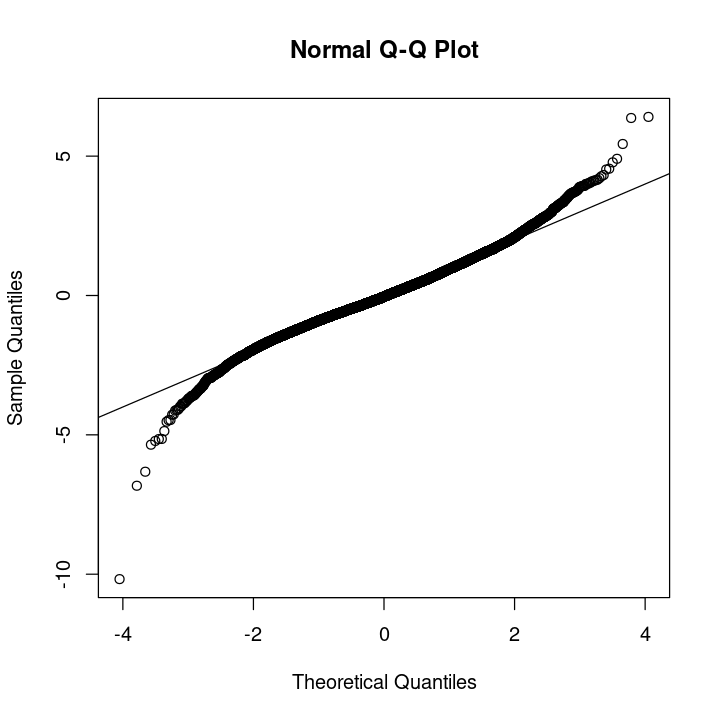

In [291]:
options(repr.plot.width= 6, repr.plot.height= 6)

ans <- qqnorm(scale(residuals(m01, type= "pearson")))
qqline(ans$x, probs = c(0.25, 0.75))


In [292]:
# Get a sense of the uncertainty for the model's sigma.
# (sim is from the arm package.)

m01.sim <- sim(m01, n.sims=3000)


In [293]:
# Sigma is small because of the power transformation 
# on the response variable.

sigma.m01.sim <- sigma.hat(m01.sim)
str(sigma.m01.sim)


 num [1:3000] 1176 1173 1169 1162 1164 ...


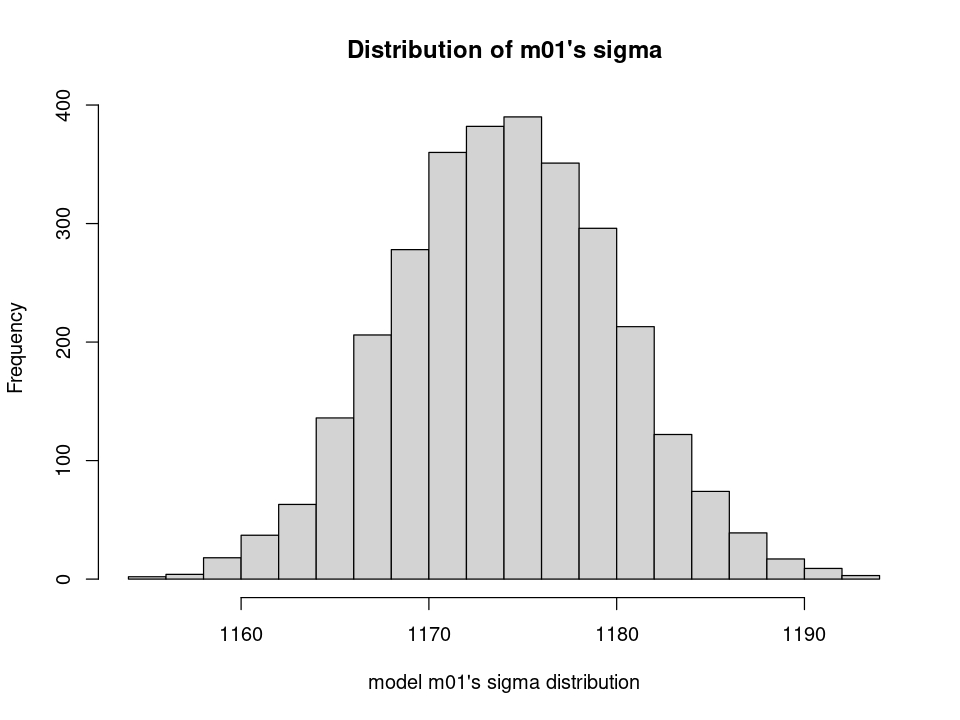

In [294]:
options(repr.plot.width= 8, repr.plot.height= 6)

hist(sigma.m01.sim, breaks=20, main="Distribution of m01's sigma",
     xlab="model m01's sigma distribution")


### Gibbs sampler for imputing censored median house values

In [46]:
# Because of the transformation on the response variable,
# we need to transform our limits.  Here I am setting the 
# upper limit to 495K. 

cap <- 300000
response_var_power <- 0.728
inv_pwr <- 1/response_var_power

C <- cap^response_var_power
C_upper <- (1.65*cap)^response_var_power

censored <- (dat$median_house_value)^response_var_power >= C

# Create some crude starting values.
n.censored <- sum(censored)
z <- ifelse(censored, NA, (dat$median_house_value)^response_var_power)
z[censored] <- runif(n.censored, C, C_upper)


In [47]:
length(censored)
n.censored


[1] 19574

[1] 2833

In [48]:
summary(z[censored])


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   9716   10722   11854   11823   12889   13984 

In [49]:
# Identify the rows that are censored.

rows_censored <- rownames(dat)[censored]
c(head(rows_censored), tail(rows_censored))


[1] "1"     "2"     "3"     "4"     "5"     "104"   "20502" "20503" "20504"
[10] "20505" "20528" "20534"

In [50]:
# Function to draw from a constrained normal distribution.

## CAUTION: response_var_power is global and should be 
## equal to what is used in the m01 model.

rnorm.trunc03 <- function(n, mu, sigma, lo=-Inf, hi=Inf) {
    
    # We need each mu to be >= C.  Otherwise the return 
    # value will be Inf.
    cap <- 300000
    mu02 <- ifelse(mu <= C, (cap + 100)^response_var_power, mu)
    
    p.lo <- pnorm(lo, mu02, sigma)
    p.hi <- pnorm(hi, mu02, sigma)
    u <- runif(n, p.lo, p.hi)
    return(qnorm(u, mu02, sigma))
}


In [300]:
# Create matrix X for the terms in our model.

X <- dat

X$median_income <- X$median_income

X$lat2 <- (X$latitude)^2
X$lat3 <- (X$latitude)^3
X$lat4 <- (X$latitude)^4

X$long_1 <- (X$long_transf)^-0.5
X$long_2 <- (X$long_transf)^-1
X$long_3 <- (X$long_transf)^-1.5

X$pphh1 <-  (X$pop_per_hh)^1.5
X$pphh2 <- (X$pop_per_hh)^3.0

X$housing_median_age <- (X$housing_median_age)^0.15

X$HHdens_by_long <- X$HHdens_ln * X$long_transf
X$HHdens_by_income <- X$HHdens_ln * X$median_income
X$HHdens_3way <- X$HHdens_ln * X$median_income * X$housing_median_age



X <- X[, c("median_income","long_1","long_2","long_3","latitude","lat2",
           "lat3","lat4","pphh1","pphh2", "housing_median_age",
           "HHdens_ln", "HHdens_by_long","HHdens_by_income",
           "HHdens_3way")]
intercept <- rep(1, nrow(dat))

init.colnames <- colnames(X)

X <- as.data.frame(cbind(intercept, X), col.names=c("intercept", init.colnames),
                   row.names=rownames(dat))
dim(X)
colnames(X)


[1] 19574    16

[1] "intercept"          "median_income"      "long_1"            
 [4] "long_2"             "long_3"             "latitude"          
 [7] "lat2"               "lat3"               "lat4"              
[10] "pphh1"              "pphh2"              "housing_median_age"
[13] "HHdens_ln"          "HHdens_by_long"     "HHdens_by_income"  
[16] "HHdens_3way"

In [301]:
# See p.406 (Section 18.5) of Gelman and Hill's book,
# "Data Analysis Using Regression and Multilevel/Hierarchical
# Models".

# Fit a regression using the crude starting values of z.

m01_tst <- lm(z ~ 
             
           I(median_income^1) +
           I(long_transf^-0.5) +
           I(long_transf^-1) +
           I(long_transf^-1.5) +
           latitude +
           I(latitude^2) +
           I(latitude^3) + 
           I(latitude^4) +
           I(pop_per_hh^1.5) +
           I(pop_per_hh^3.0) +
           I(housing_median_age^0.15) +
           HHdens_ln +
           HHdens_ln:long_transf +
           HHdens_ln:median_income +
           HHdens_ln:housing_median_age:median_income,
              
           data= dat)    

# Obtain a sample draw of the model coefficients and of
# parameter sigma.
sim.1 <- sim(m01_tst, n.sims=1)


In [302]:
beta <- coef(sim.1)
dim(beta)
colnames(beta)


[1]  1 16

[1] "(Intercept)"                               
 [2] "I(median_income^1)"                        
 [3] "I(long_transf^-0.5)"                       
 [4] "I(long_transf^-1)"                         
 [5] "I(long_transf^-1.5)"                       
 [6] "latitude"                                  
 [7] "I(latitude^2)"                             
 [8] "I(latitude^3)"                             
 [9] "I(latitude^4)"                             
[10] "I(pop_per_hh^1.5)"                         
[11] "I(pop_per_hh^3)"                           
[12] "I(housing_median_age^0.15)"                
[13] "HHdens_ln"                                 
[14] "HHdens_ln:long_transf"                     
[15] "HHdens_ln:median_income"                   
[16] "HHdens_ln:median_income:housing_median_age"

In [303]:
# Here are means for 6 different normal distributions.

means <- as.matrix(X) %*% t(beta)
length(means)
round(head(as.vector(means)^inv_pwr))


[1] 19574

[1] 349701 361540 273449 232572 194668 200512

In [304]:
# All values should be between 300K and 495K
z.old <- z[censored]
round(head(z.old)^inv_pwr)


[1] 348841 358201 492673 355402 384396 354790

In [305]:
# All values should be between 300K and 495K.
sigma <- sigma.hat(sim.1)
round(sigma, 4)

z.new <- rnorm.trunc03(n.censored, means[censored], sigma, lo=C, hi=C_upper)
round(head(as.vector(z.new)^inv_pwr))


[1] 1575.7

[1] 417280 382061 390299 341831 318321 387359

In [306]:
summary(z.new^inv_pwr)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 300003  323058  348666  357257  383537  494551 

In [307]:
# For the Gibbs sampler, the above is now put into
# a loop.

n <- nrow(dat)
n.chains <- 4
n.iter <- 2000

# We have 16 terms in the model (including the intercept) as
# well as parameter sigma.  Thus, besides storing the imputed
# values, we need to have 17 additional slots.
sims <- array(NA, c(n.iter, n.chains, 17 + n.censored))
dimnames(sims) <- list(NULL, NULL, c(colnames(X), "sigma", 
                                     paste("z[", (1:n)[censored],
                                           "]", sep="")))

start <- Sys.time()
for(m in 1:n.chains) {
    
    # acquire some initial values
    z[censored] <- runif(n.censored, C, C_upper)
    
    for(t in 1:n.iter) {
        
        m01.1 <- lm(z ~ 
                    
           I(median_income^1) +
           I(long_transf^-0.5) +
           I(long_transf^-1) +
           I(long_transf^-1.5) +
           latitude +
           I(latitude^2) +
           I(latitude^3) + 
           I(latitude^4) +
           I(pop_per_hh^1.5) +
           I(pop_per_hh^3.0) +
           I(housing_median_age^0.15) +
           HHdens_ln +
           HHdens_ln:long_transf +
           HHdens_ln:median_income +
           HHdens_ln:housing_median_age:median_income,
                  
           data= dat)   
        
        sim.1 <- sim(m01.1, n.sims=1)
        beta <- coef(sim.1)
        sigma <- sigma.hat(sim.1)
        means <- as.matrix(X) %*% t(beta)
        z[censored] <- rnorm.trunc03(n.censored, means[censored], sigma, lo=C, hi=C_upper)
        stopifnot(sum(z[censored] < Inf) == n.censored)
        sims[t,m,] <- c(beta, sigma, z[censored])
    }
}
stop <- Sys.time()
round(stop - start, 2)
# Time difference of ~5 minutes.


Time difference of 5.17 mins

In [ ]:
# Check for convergence.

# sims.bugs <- R2OpenBUGS::as.bugs.array(sims, n.burnin=1000)
# print(sims.bugs)

# The Rhat value for every parameter and every imputed
# value should be 1.0.


In [308]:
save(sims, file="/home/greg/Documents/stat/sandbox/Pfizer/datasets/housing/sims_raw_hhvals_300Kcap.RData")


In [51]:
load("/home/greg/Documents/stat/sandbox/Pfizer/datasets/housing/sims_raw_hhvals_300Kcap.RData")


In [52]:
# Drop the first 1000 iterations.  That is the burn-in
# period.

sims_adj <- sims[1001:2000, ,]
dim(sims_adj)


[1] 1000    4 2850

In [53]:
sims_adj.bugs <- R2OpenBUGS::as.bugs.array(sims_adj)
# print(sims_adj.bugs)


In [54]:
# Extract the means and stddevs for each of the censored records.
# The means and the stddevs are computed from the 1000 remaining
# iterations.

z_means <- sims_adj.bugs$mean$z
z_sds <- sims_adj.bugs$sd$z
round(head(z_means), 2); round(head(z_sds), 2)


[1] 11132 11263 10803 10794 10776 10789

[1] 943.80 971.30 816.30 808.76 798.13 789.79

In [55]:
summary(z_means)
summary(z_sds)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  10747   10785   10795   10836   10806   13512 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    435     802     809     820     818    1056 

In [56]:
# NOTE that the interquartile range is < 1000.

summary(round(z_means^inv_pwr))


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 344737  346417  346844  348684  347318  472110 

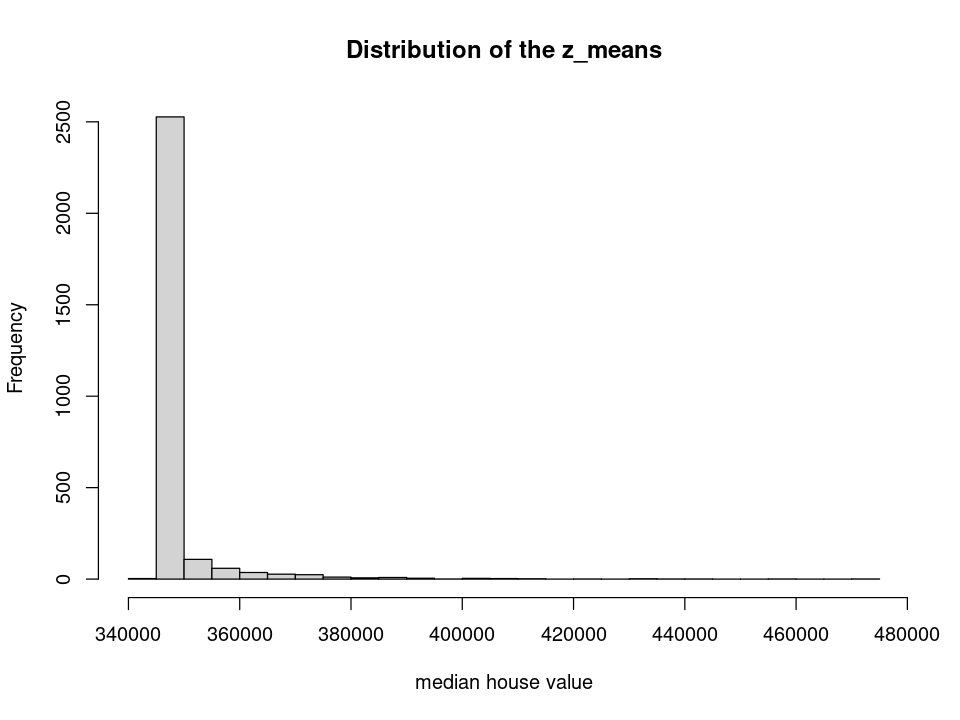

In [57]:
# Distribution of the z_means.

options(repr.plot.width= 8, repr.plot.height= 6)

hist(z_means^inv_pwr, breaks=20, main="Distribution of the z_means",
     xlab="median house value")


In [58]:
rm(sims, sims_adj, sims_adj.bugs)


In [59]:
# Average estimate of the sd.

(sd_estimate <- round((10836 + 820)^inv_pwr) - round(10836^inv_pwr))
# $36,747


[1] 36747

In [46]:
# Here is a fuller summary for the stddevs.

ans <- round((z_means + z_sds)^inv_pwr) - round(z_means^inv_pwr)
summary(ans)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  20999   35859   36220   36758   36619   49196 

In [ ]:
### COMMENTS:

# Based on the prediction from g02, we expect the mean 
# to be about 368K if the upper limit is around 495K.  
# The mean is currently around 355K (see next summary).

# The 95% prediction interval for the 368K prediction
# is [361, 375K].  Notice that the 355K number is not 
# in this interval.


In [60]:
# Get some predictions, using rnorm.trunc03.

set.seed(1931)
z_preds <- round(rnorm.trunc03(n.censored, z_means, z_sds, lo=C, hi=C_upper), 5)
z_preds <- round(z_preds^inv_pwr)
summary(z_preds)

# Notice that the mean is at 355.5K.  We do not expect the mean 
# to be this low because model g02 is a fairly good model 
# and it predicts a mean much closer to 368K.  Also, the 
# hypothesized distribution of Figure 3 has a mean at 369K and
# prior to adjustment had a mean at 375K.


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 300020  331123  351990  355465  375365  492061 

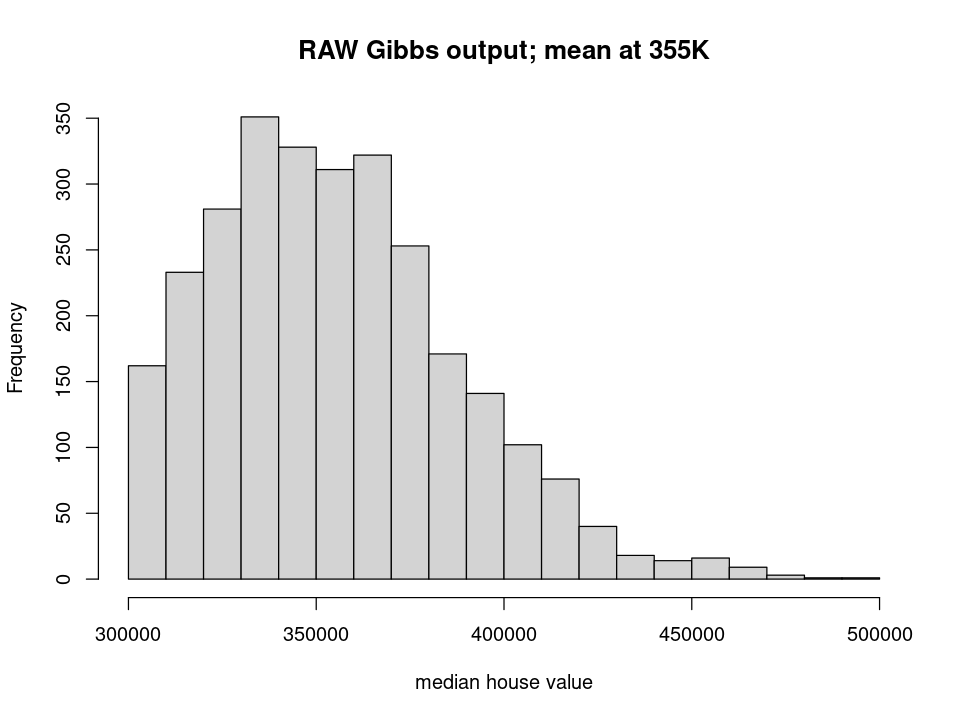

In [61]:
# The shape of the distribution below is not what we 
# hypothesized.  The Gibbs sampler is very constrained
# in the type of shape it can generate; the prediction
# model that it employs assumes that the response variable
# is normally distributed.  We do not see a normal dist-
# ribution below because the Gibbs output is constrained
# by rnorm.trunc03.

options(repr.plot.width= 8, repr.plot.height= 6)

hist(z_preds, breaks=20, main="RAW Gibbs output; mean at 355K",
     xlab="median house value", cex.main= 1.3)


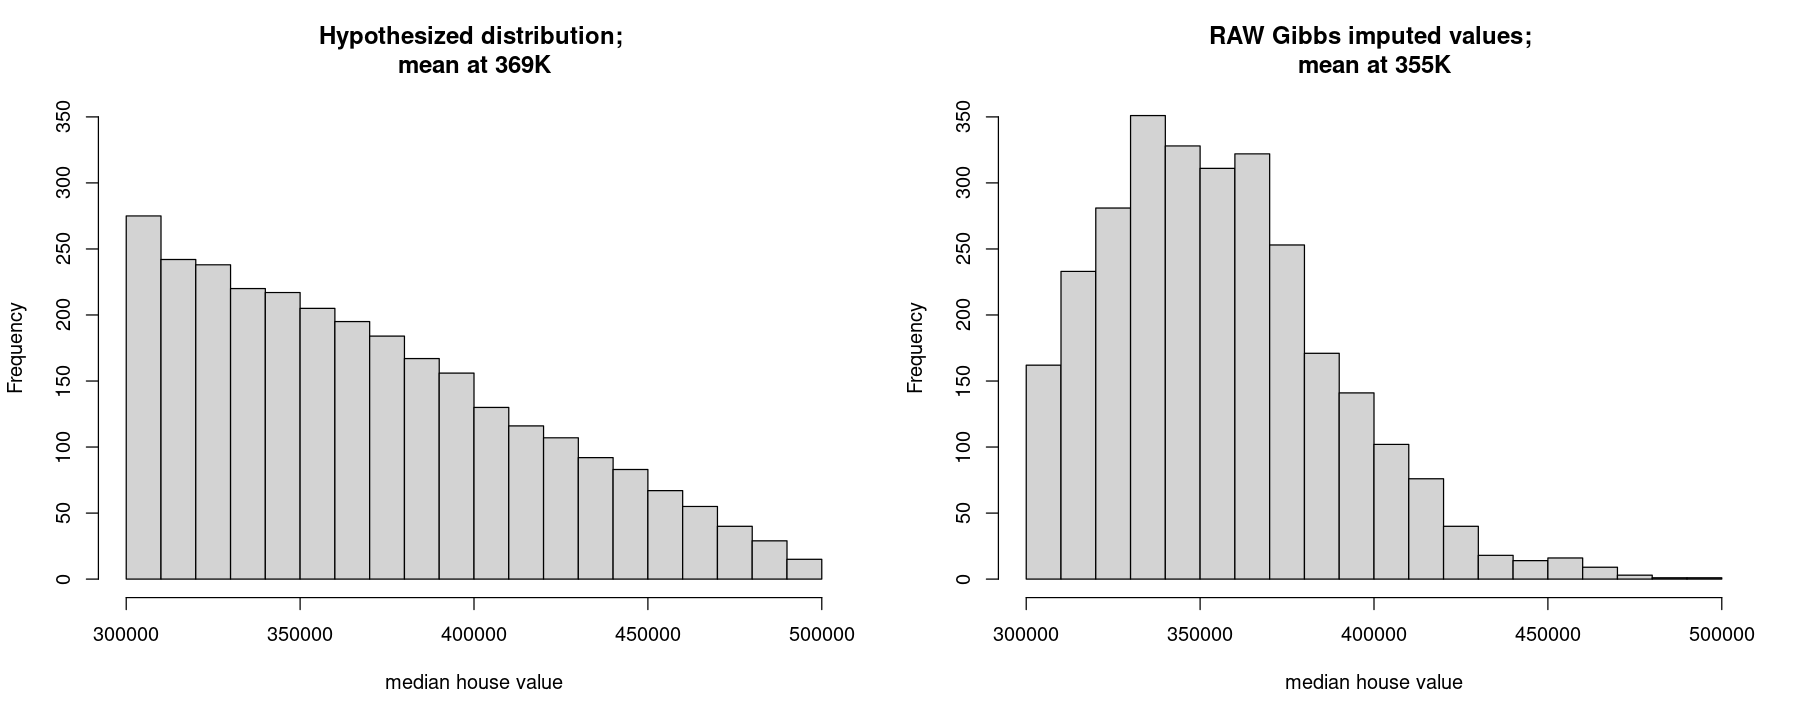

In [321]:
# Compare hypothesized distribution to the above distribution.

options(repr.plot.width= 15, repr.plot.height= 6)

mat <- t(as.matrix(c(1,2)))
layout(mat, widths = rep.int(20, ncol(mat)),
       heights = rep.int(7, nrow(mat)), respect = FALSE)

# Left panel.
hist(imputed_vals_tmp, breaks=20, main="Hypothesized distribution; 
mean at 369K",
     ylim=c(0, 350), xlab="median house value")

# Right panel.
hist(z_preds, breaks=20, main="RAW Gibbs imputed values; 
mean at 355K",
     ylim=c(0, 350), xlab="median house value")


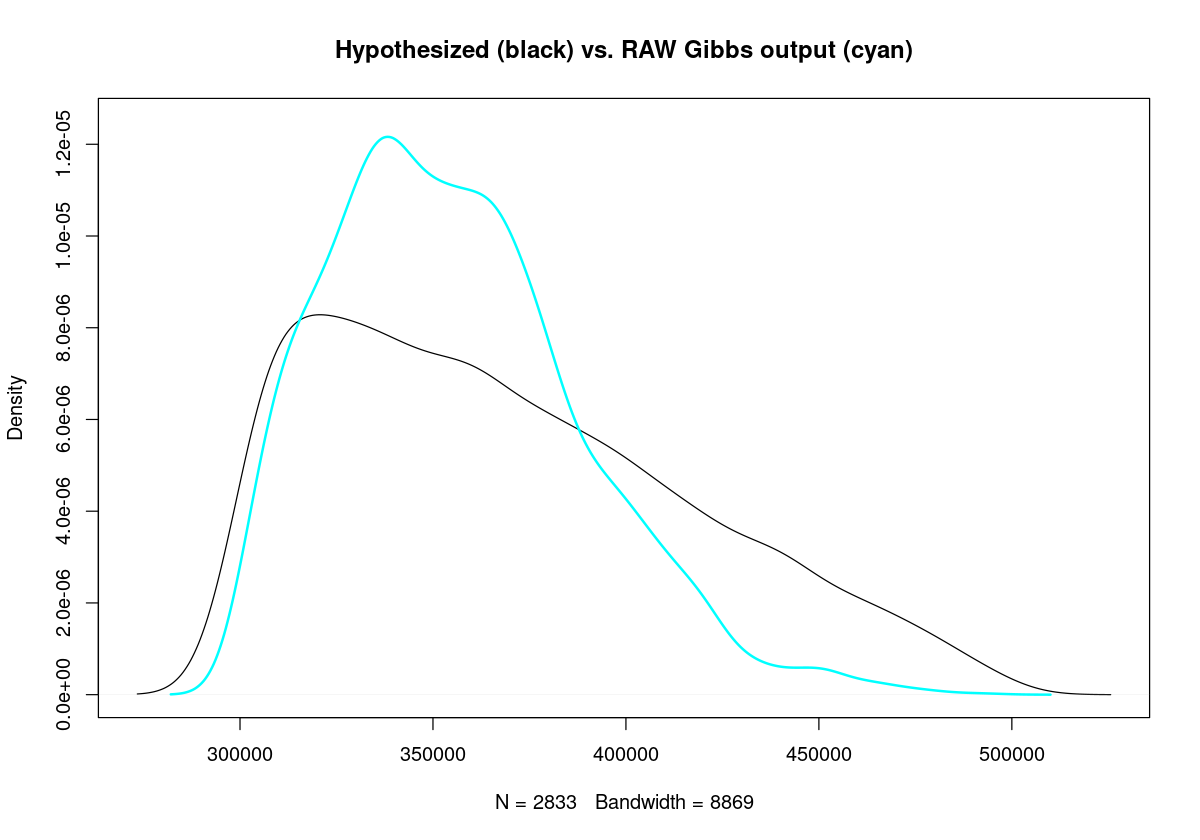

In [66]:
# Compare the density curves.

options(repr.plot.width= 10, repr.plot.height= 7)

fit <- density(imputed_vals_tmp)
plot(fit, ylim=c(0, 1.25e-05), main="Hypothesized (black) vs. RAW Gibbs output (cyan)")

lines(density(z_preds), col= "cyan", lwd=2)


In [67]:
# Assign the raw, imputed values to the censored records of a 
# copy of dat.  Then save out the file so that we can later 
# use it to compare with the adjusted (enhanced) imputed
# values.

newdat_raw <- dat
newdat_raw$median_house_value[censored] <- z_preds
summary(newdat_raw$median_house_value)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  15000  116300  173400  189639  247575  492061 

In [68]:
# Save to disk.

write.csv(newdat_raw,
          file="/home/greg/Documents/stat/Geron_ML/datasets/housing/imputed_median_hhvals_Gibbs_raw.csv",
          row.names=TRUE)


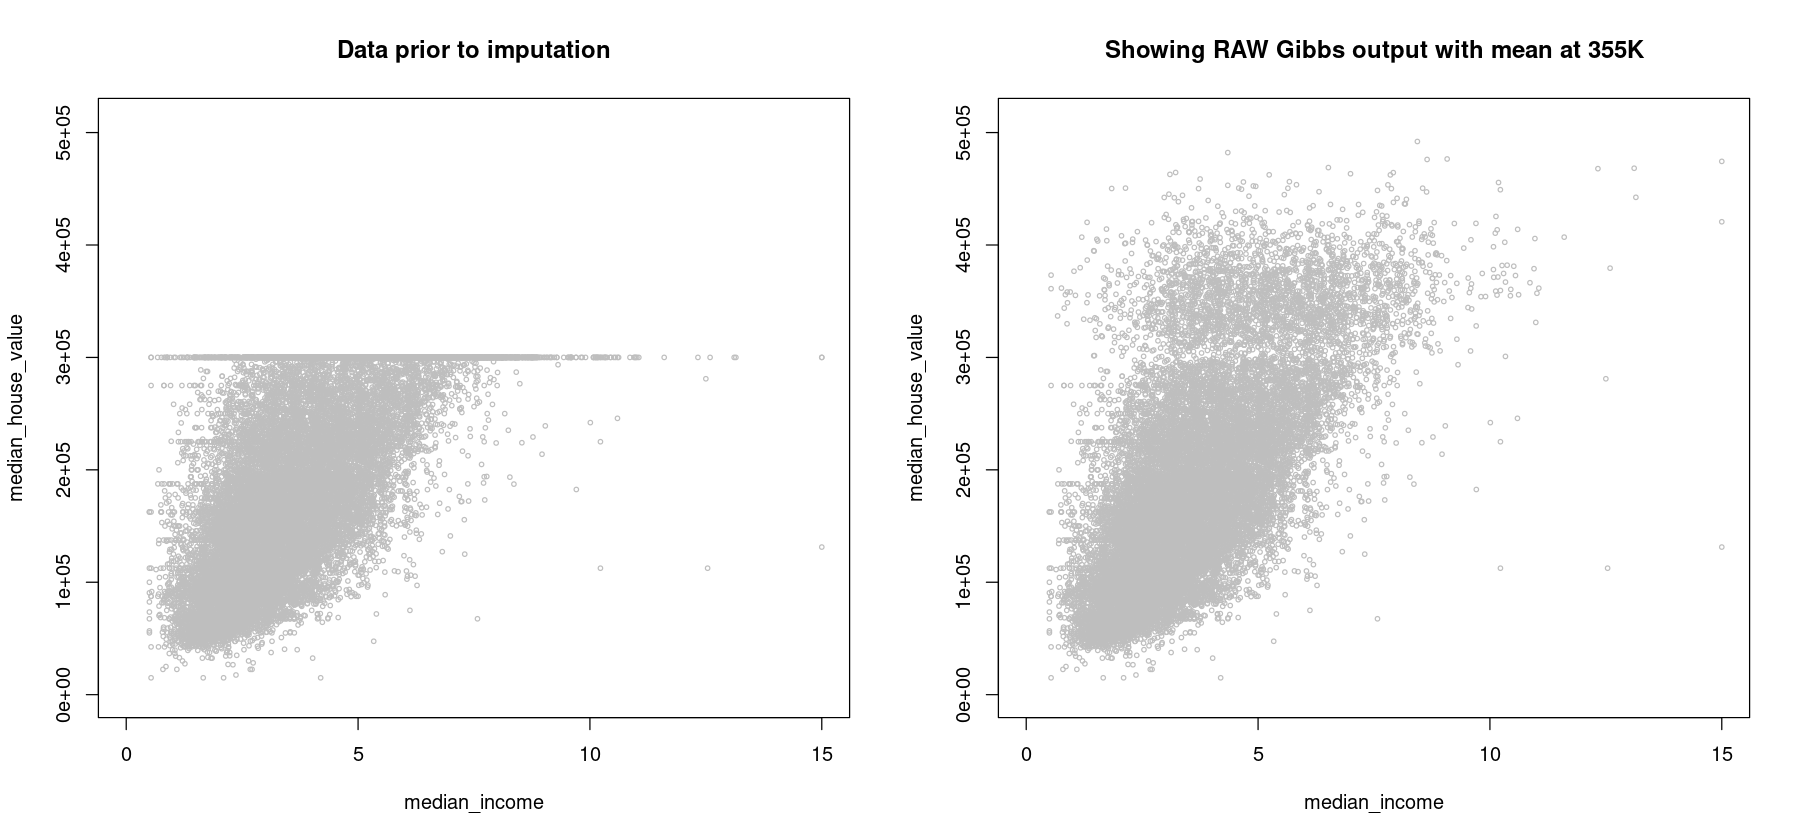

In [325]:
# Plot both before and after, where we use the adjusted values for "after".

options(repr.plot.width= 15, repr.plot.height= 7)

mat <- t(as.matrix(c(1,2)))
layout(mat, widths = rep.int(20, ncol(mat)),
       heights = rep.int(7, nrow(mat)), respect = FALSE)

# layout.show(n = 2)

# plot the "before" scatter
plot(dat$median_income, dat$median_house_value, type= "p", pch=1, cex=0.5, col="grey",
     xlab= "median_income", ylab= "median_house_value", ylim= c(0, 0.51e06), xlim= c(0, 15),
     main= "Data prior to imputation")


# plot the newly predicted values
plot(newdat_raw$median_income, newdat_raw$median_house_value, type= "p", pch=1, cex=0.5, col="grey",
     xlab= "median_income", ylab= "median_house_value", ylim= c(0, 0.51e06), xlim= c(0, 15),
     main= "Showing RAW Gibbs output with mean at 355K")


### House values data: Adjust Gibbs output---Approach 1

In [69]:
# Move the mean over to 368K.

(z_means_bar <- mean(z_means))

z_means_adj <- z_means + (365000^response_var_power - z_means_bar)
summary(z_means_adj)
round(mean(z_means_adj)^inv_pwr)


[1] 10836

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  11114   11153   11162   11203   11173   13879 

[1] 365000

In [70]:
# Get new predictions.  We now have a mean at 368.4K.

set.seed(1933)
z_preds_adj01 <- round(rnorm.trunc03(n.censored, z_means_adj, z_sds, lo=C, hi=C_upper), 2)
summary(z_preds_adj01^inv_pwr)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 300491  342577  365544  368365  391679  494074 

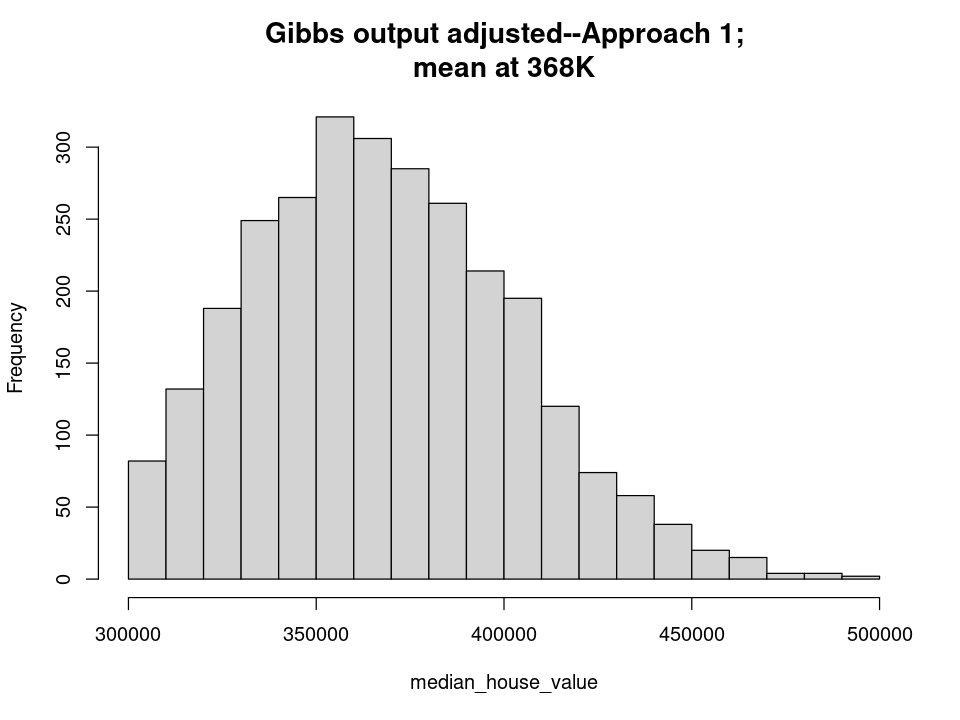

In [71]:
options(repr.plot.width= 8, repr.plot.height= 6)

hist(z_preds_adj01^inv_pwr, breaks=18, 
     main="Gibbs output adjusted--Approach 1;
mean at 368K", xlab="median_house_value", cex.main=1.4)


In [ ]:
### COMMENT:

# The above shape is even further from what we expect to see for
# the distribution of imputed values.  This is because the Gibbs
# output was shifted to the right rather than the left.


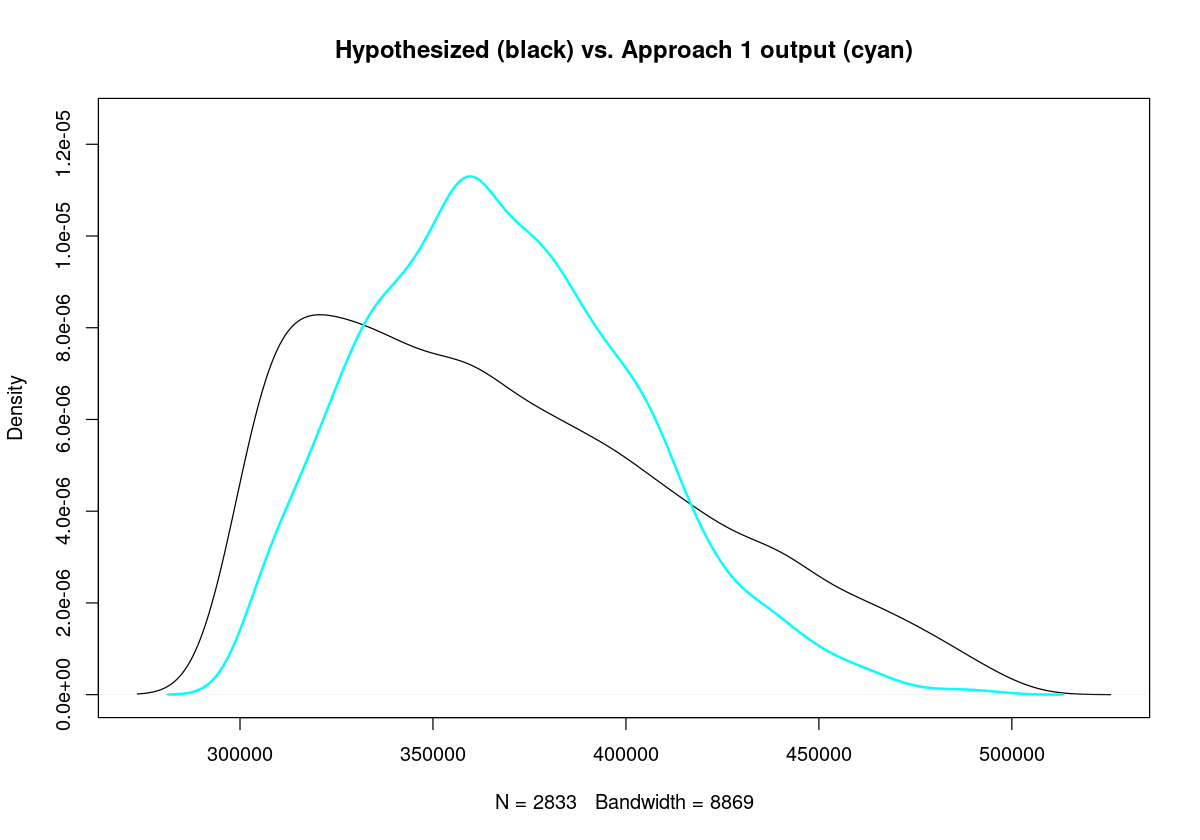

In [74]:
# Compare the density curves.

options(repr.plot.width= 10, repr.plot.height= 7)

fit <- density(imputed_vals_tmp)
plot(fit, ylim=c(0, 1.25e-05), main="Hypothesized (black) vs. Approach 1 output (cyan)")

lines(density(z_preds_adj01^inv_pwr), col= "cyan", lwd=2)


In [75]:
# Assign imputed values and save out.

newdat_adj01 <- dat
newdat_adj01$median_house_value[censored] <- z_preds_adj01^inv_pwr

write.csv(newdat_adj01,
          file="/home/greg/Documents/stat/Geron_ML/datasets/housing/imputed_house_vals_App_C_adj01.csv",
          row.names=TRUE)


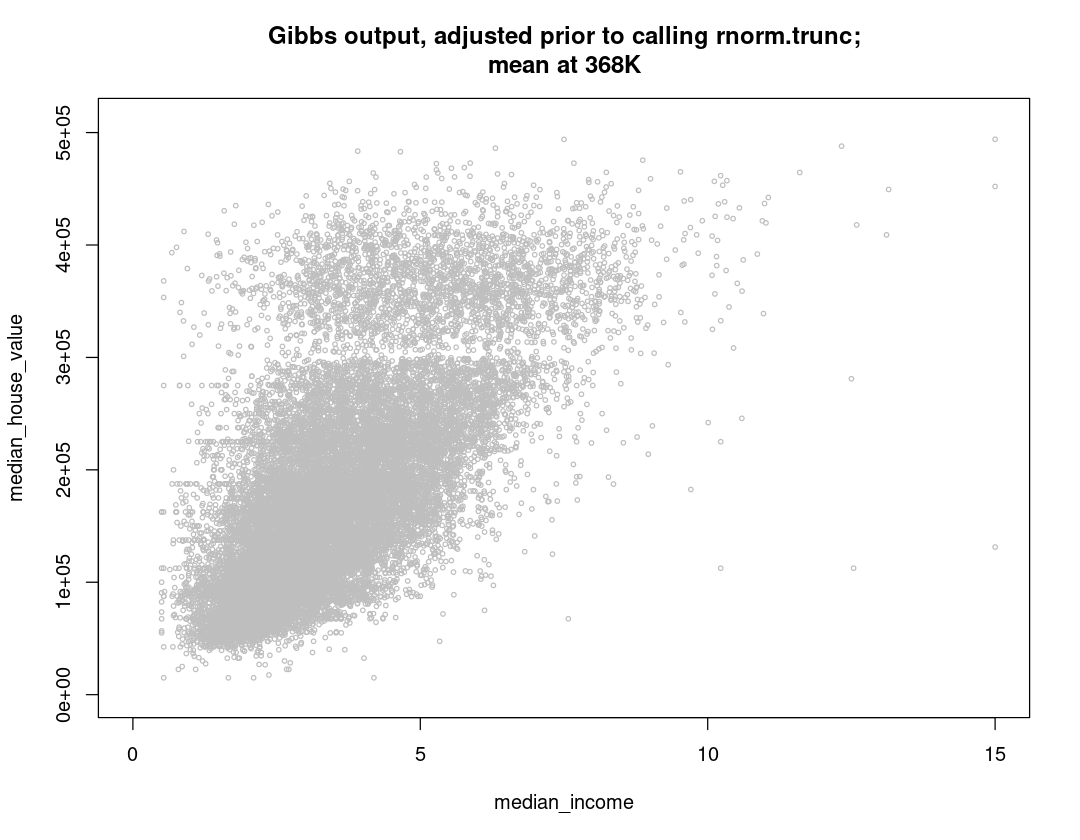

In [333]:
options(repr.plot.width= 9, repr.plot.height= 7)

# plot the newly predicted values
plot(newdat_adj01$median_income, newdat_adj01$median_house_value, type= "p", pch=1, cex=0.5, col="grey",
     xlab= "median_income", ylab= "median_house_value", ylim= c(0, 0.51e06), xlim= c(0, 15),
     main= "Gibbs output, adjusted prior to calling rnorm.trunc;
mean at 368K")


In [ ]:
### COMMENTS:

# If we attempt to reshape the adjusted output we now have so
# that the imputed values have a distribution which looks more like 
# the hypothesized distribution, the resulting predictions will be
# much worse in terms of RSS gain.

# The adjustment just made enlarges the white band we see in the
# above scatterplot.


### House values data: Adjust Gibbs output---Approach 2

In [76]:
# There are 20 10K bins.

print(bins10K_counts)


300K 310K 320K 330K 340K 350K 360K 370K 380K 390K 400K 410K 420K 430K 440K 450K 
 260  248  236  224  214  204  195  185  169  153  134  120  106   94   83   68 
460K 470K 480K 490K 
  55   40   30   15 


In [77]:
# Function which identifies the bin that a given number
# falls into. 

get_bin <- function(val, bin_size=10000) {
    
    return(floor(val/bin_size) * bin_size)
}


In [78]:
# Construct a dataframe which holds predictions for each
# of the z_means and records the probability of the z_mean
# being located at the "predicted" value.

n_preds <- 17000
cap <- 300000

start <- Sys.time()
dfpreds <- rep(NA, n_preds*n.censored*4)
dim(dfpreds) <- c(n_preds*n.censored, 4)
dfpreds <- as.data.frame(dfpreds)
colnames(dfpreds) <- c("rowname","predicted_val","loc_prob","bin")

dfpreds$rowname <- rep(rows_censored, rep(n_preds, n.censored))

stop <- Sys.time()
round(stop - start, 2)
# Time difference of 2.04 secs when n_preds = 20K


Time difference of 2.38 secs

In [79]:
# Get vectors needed for our dataframe.

probs_list <- bins_list <- preds_list <- vector("list", length=n.censored)
names(probs_list) <- names(bins_list) <- names(preds_list) <- rows_censored

start <- Sys.time()
for(i in 1:n.censored) {
    
    cur_mean <- z_means[i]
    cur_sd <- z_sds[i]
    cur_row <- rows_censored[i]
    
    # Get n_preds predictions for this mean.
    mu02 <- ifelse(cur_mean <= C, (cap + 10)^response_var_power, cur_mean)
    p.lo <- pnorm(C, mu02, cur_sd)
    p.hi <- pnorm(C_upper, mu02, cur_sd)
    u <- qnorm(runif(n_preds, p.lo, p.hi), mu02, cur_sd)
    loc_probs <- abs(dnorm(u, mu02, cur_sd, log=TRUE))
    u_transf <- u^inv_pwr
    bin_vector <- as.vector(apply(as.matrix(u_transf), MARGIN=2, FUN=get_bin))
    
    probs_list[[i]] <- loc_probs
    preds_list[[i]] <- u_transf
    bins_list[[i]] <- bin_vector
}
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 5.41 secs when n_preds = 20K


Time difference of 4.74 secs

In [80]:
# Populate the dataframe.

start <- Sys.time()
dfpreds$predicted_val <- as.vector(unlist(preds_list))
dfpreds$loc_prob <- as.vector(unlist(probs_list))
dfpreds$bin <- as.vector(unlist(bins_list))

stop <- Sys.time()
round(stop - start, 2)
# Time difference of 42 secs when n_preds = 15K

dim(dfpreds)
# 48,161,000    4 when n_preds = 17K

head(dfpreds); tail(dfpreds)


Time difference of 45.25 secs

[1] 48161000        4

,rowname,predicted_val,loc_prob,bin
,<chr>,<dbl>,<dbl>,<dbl>
1,1,354234,7.7850,350000
2,1,347476,7.8272,340000
3,1,382678,7.8899,380000
4,1,361406,7.7689,360000
5,1,357452,7.7742,350000
6,1,341006,7.8924,340000


,rowname,predicted_val,loc_prob,bin
,<chr>,<dbl>,<dbl>,<dbl>
48160995,20534,376963,7.9693,370000
48160996,20534,430236,10.2051,430000
48160997,20534,372240,7.8684,370000
48160998,20534,369299,7.8139,360000
48160999,20534,334673,7.6698,330000
48161000,20534,321008,7.8755,320000


In [92]:
rm(probs_list, bins_list, preds_list)


In [81]:
# Order the data in dfpreds so that we can access it
# more quickly.

dfpreds <- dfpreds[order(dfpreds$bin),]


In [82]:
# Find predictions for each of the 20 10K bins.

binvals <- as.numeric(bins10K)
rows_to_exclude <- c()

newpreds <- c()
pred_names <- c()

# The sequence in which we fill the bins makes a difference
# for the RSS gain and even whether all bins will get filled.
seq <- c(20:12, 1:11)

start <- Sys.time()
for(i in seq) {
    
    cur_count <- bins10K_counts[i]
    binval <- binvals[i]
    
    dftmp <- dfpreds[which(dfpreds$bin == binval),]
    
    # Remove the z_means that we have already used.
    dftmp <- dftmp[which(!(dftmp$rowname %in% rows_to_exclude)),]
    
    # For each rowname, we can only have one prediction.
    dftmp <- dftmp[order(dftmp$rowname, dftmp$loc_prob,
                         decreasing=c(FALSE, FALSE)),]
    dftmp <- dftmp[which(!duplicated(dftmp$rowname)),]
    
    # stopifnot(nrow(dftmp) >= cur_count)
    
    # If we get this far, we have enough predictions to draw from
    # to fill the current bin.  Now order the records by the
    # probabilities and then select what we need.
    dftmp <- dftmp[order(dftmp$loc_prob, decreasing=FALSE),]
    dftmp <- dftmp[1:cur_count, c("rowname","predicted_val")]
    
    newpreds <- c(newpreds, dftmp$predicted_val)
    pred_names <- c(pred_names, dftmp$rowname)
    rows_to_exclude <- c(rows_to_exclude, dftmp$rowname)
}
stop <- Sys.time()
round(stop - start, 2)
# Time difference of ~36 secs when n_preds = 17K


Time difference of 35.99 secs

In [83]:
length(newpreds)
length(pred_names)


[1] 2833

[1] 2833

In [84]:
length(unique(pred_names))


[1] 2833

In [85]:
names(newpreds) <- pred_names
print(tail(newpreds))


 10649   6780   5339   4624  17283   8560 
400013 400040 400045 400007 400008 400060 


In [86]:
# Check mean of the distribution.

summary(newpreds)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 309958  329999  360001  368136  400005  490077 

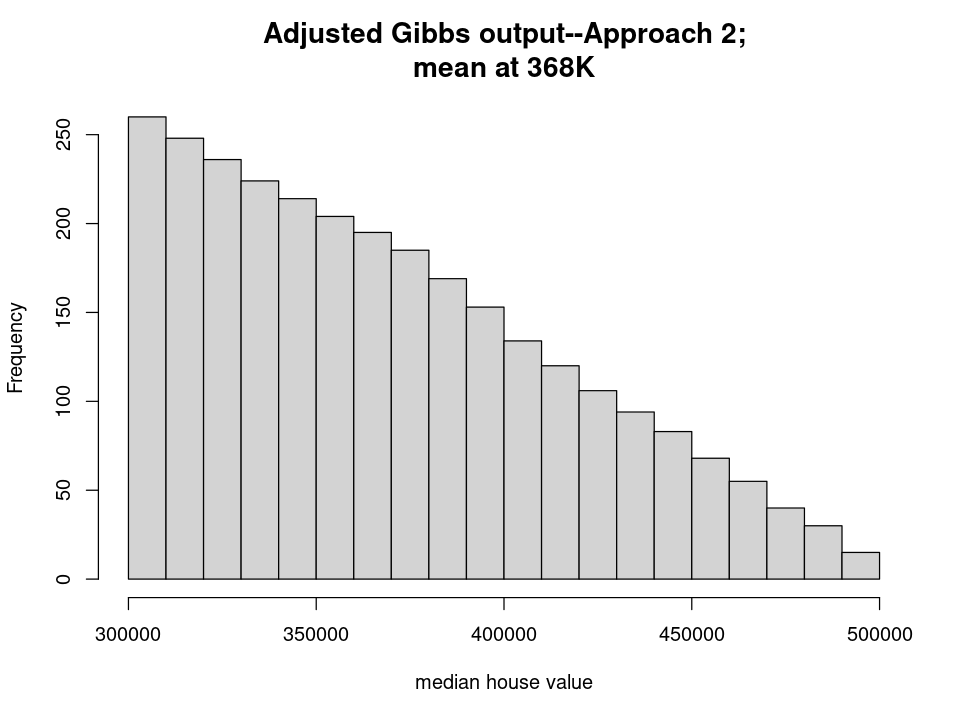

In [87]:
# Check shape of the distribution.

options(repr.plot.width= 8, repr.plot.height= 6)

hist(newpreds, breaks=20, main="Adjusted Gibbs output--Approach 2;
mean at 368K", xlab="median house value", cex.main=1.4)


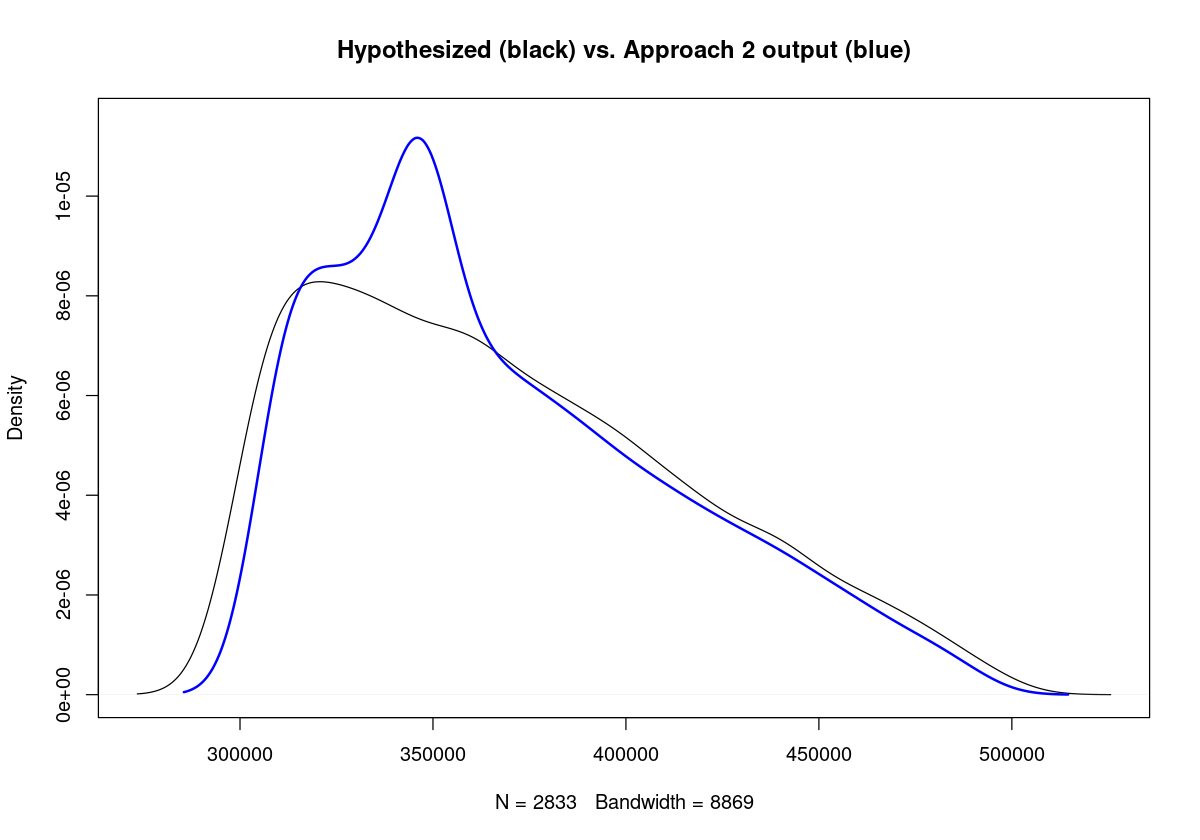

In [88]:
# Compare the density curves.

options(repr.plot.width= 10, repr.plot.height= 7)

fit <- density(imputed_vals_tmp)
plot(fit, ylim=c(0, 1.15e-05), main="Hypothesized (black) vs. Approach 2 output (blue)")

lines(density(newpreds), col= "blue", lwd=2)


In [89]:
# Assign imputed values to the correct records in dat.

newdat_adj02 <- dat
newdat_adj02[rows_censored, c("median_house_value")] <- as.numeric(newpreds[rows_censored])
summary(newdat_adj02$median_house_value)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  15000  116300  173400  191473  247575  490077 

In [90]:
# Save to disk.

write.csv(newdat_adj02,
          file="/home/greg/Documents/stat/Geron_ML/datasets/housing/imputed_house_vals_App_C_adj02.csv",
          row.names=TRUE)


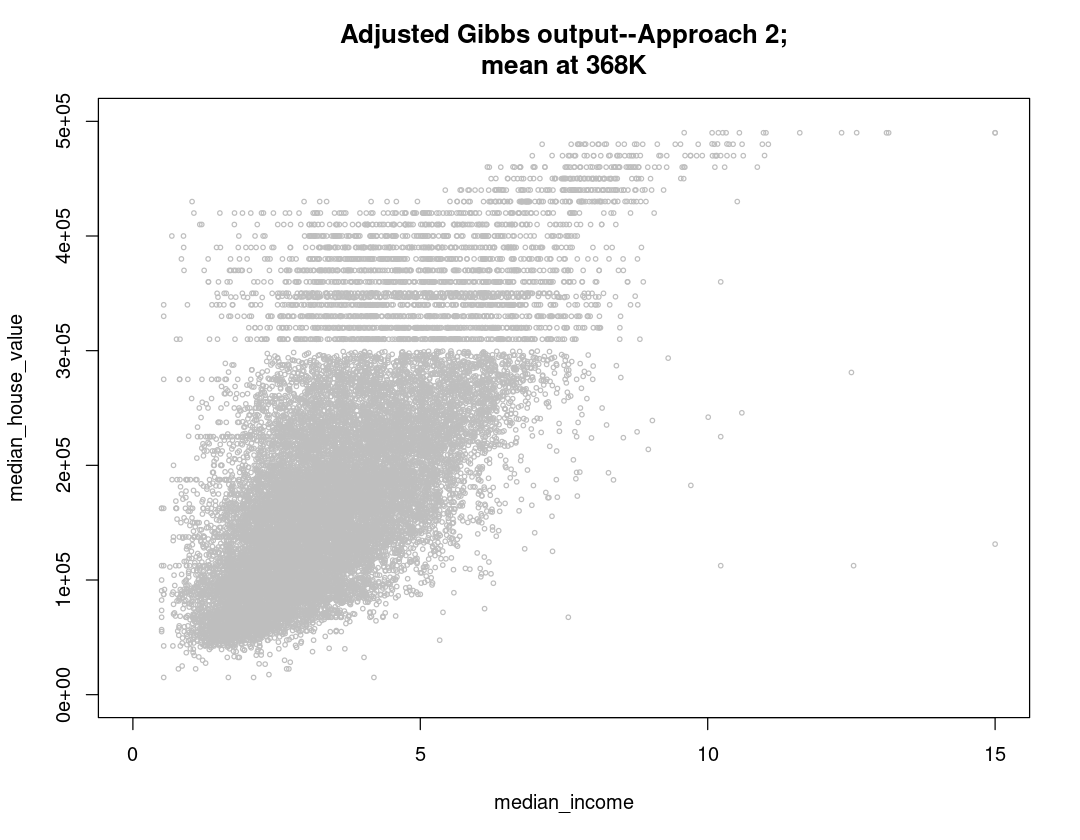

In [91]:
options(repr.plot.width= 9, repr.plot.height= 7)

# plot the newly predicted values
plot(newdat_adj02$median_income, newdat_adj02$median_house_value, type= "p", pch=1, cex=0.5, col="grey",
     xlab= "median_income", ylab= "median_house_value", ylim= c(0, 0.50e06), xlim= c(0, 15),
     main= "Adjusted Gibbs output--Approach 2;
mean at 368K", cex.main=1.3)


In [ ]:
### COMMENTS:

# We can eliminate the appearance of the bands with some 
# jittering.  The bands appear because I am choosing 
# predictions in each bin which have the highest probability
# of appearing in the bin.  If I were to do complete random
# sampling from each bin, the RSS gain score would drop
# dramatically.  The bands can also be eliminated by making
# the bins smaller (in this instance we need 2.5K bins),
# but with smaller bins we get a smaller RSS gain.  If I use
# 15K bins rather than the 10K bins above, I will see on 
# average a bit higher RSS gain.  However, the larger the 
# bin size, the harder it is to approximate the expected shape.


In [106]:
# Jitter the predictions.

set.seed(8641)
newpreds_jitt <- jitter(newpreds, amount=6000)
summary(newpreds_jitt)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 304069  333843  356070  368121  396875  494752 

In [107]:
# Assign imputed values to the correct records in dat.

newdat_adj02jitt <- dat
newdat_adj02jitt[rows_censored, c("median_house_value")] <- as.numeric(newpreds_jitt[rows_censored])
summary(newdat_adj02jitt$median_house_value)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  15000  116300  173400  191471  247575  494752 

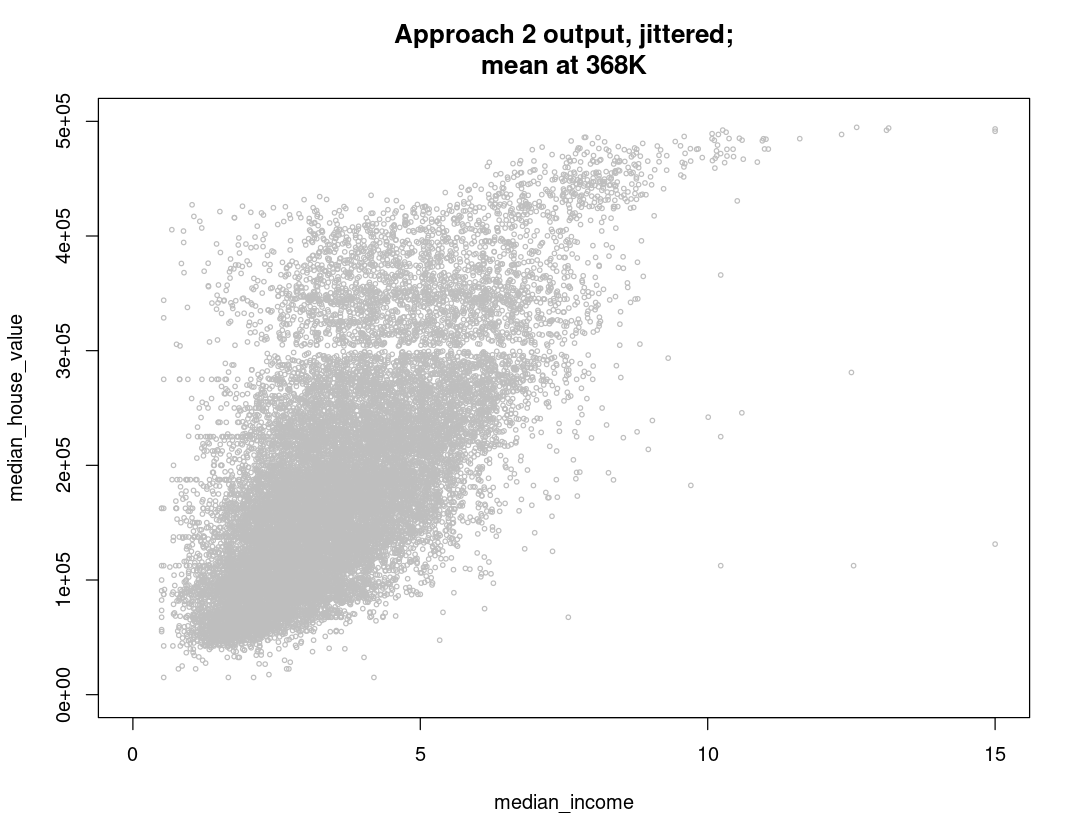

In [108]:
options(repr.plot.width= 9, repr.plot.height= 7)

# plot the newly predicted values
plot(newdat_adj02jitt$median_income, newdat_adj02jitt$median_house_value, 
     type= "p", pch=1, cex=0.5, col="grey",
     xlab= "median_income", ylab= "median_house_value", 
     ylim= c(0, 0.50e06), xlim= c(0, 15),
     main= "Approach 2 output, jittered;
mean at 368K", cex.main=1.3)


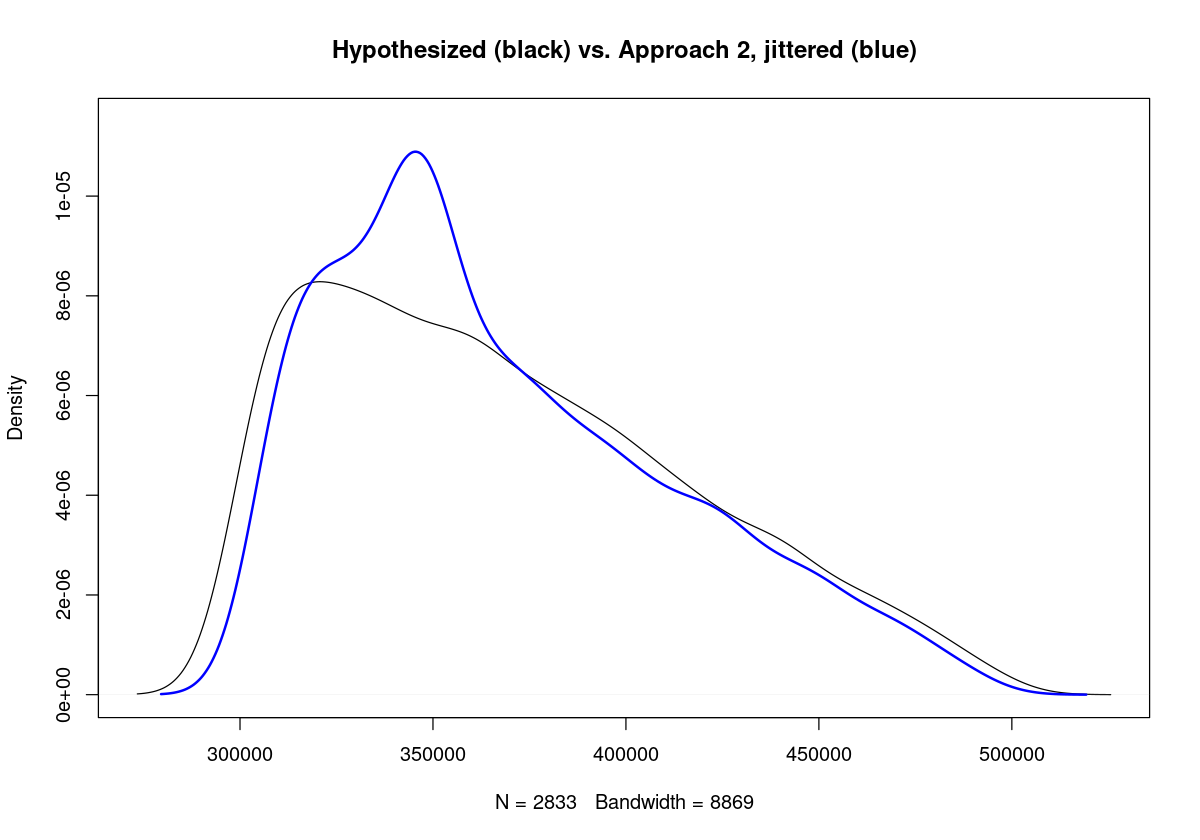

In [109]:
# Compare the density curves.

options(repr.plot.width= 10, repr.plot.height= 7)

fit <- density(imputed_vals_tmp)
plot(fit, ylim=c(0, 1.15e-05), main="Hypothesized (black) vs. Approach 2, jittered (blue)")

lines(density(newpreds_jitt), col= "blue", lwd=2)


In [110]:
# Free up some memory.

rm(dfpreds)


## Get RSS scores and look at actual distribution

### The distribution of the actual, unobserved (until now) values

In [111]:
# Compute the mean of the actual, unobserved values in the
# range of imputation.

dim(dat_noCap)
round(mean(dat_noCap[which(dat_noCap$median_house_value >= 300000),]$median_house_value))
# 368.4K


[1] 19574     7

[1] 368400

In [112]:
# Extract the unobserved, actual values.

unobserved_vals <- dat_noCap[which(dat_noCap$median_house_value >= 300000),]$median_house_value
length(unobserved_vals)


[1] 2833

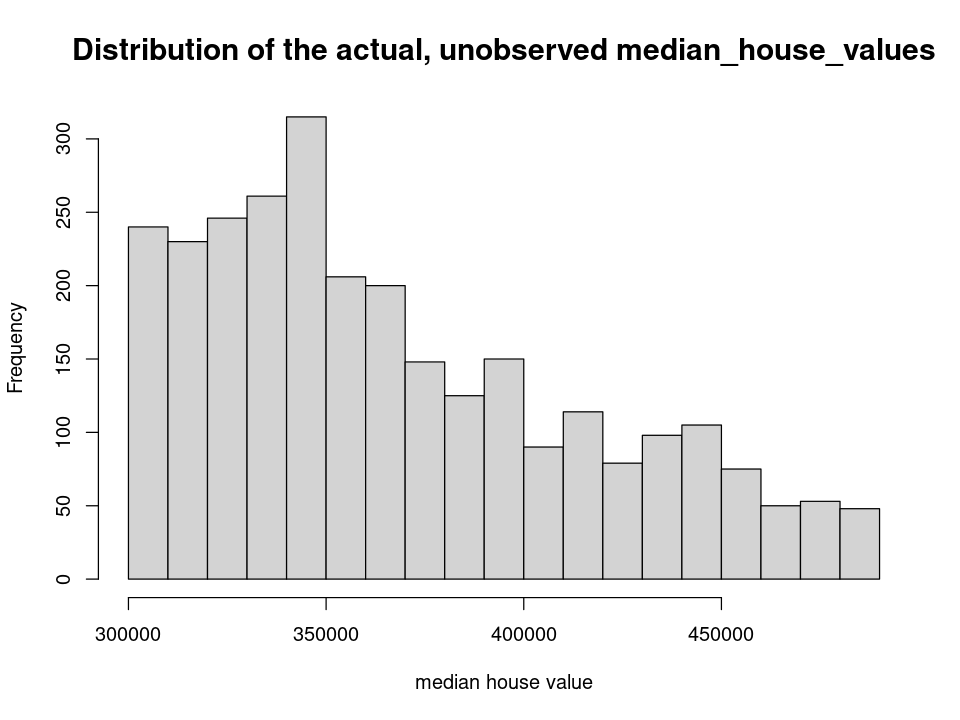

In [113]:
options(repr.plot.width= 8, repr.plot.height= 6)

hist(unobserved_vals, breaks=20, main="Distribution of the actual, unobserved median_house_values",
     xlab="median house value", cex.main=1.5)

# Notice that the shape below is somewhere between that of 
# our hypothetical distribution and that of the raw Gibbs
# output.  This means that the RSS gain score for the 
# raw Gibbs output will be higher relative to the corresponding
# scores for Approach 1 and Approach 2 than what we saw in
# Section 1 above.


### Comments

The mean of the actual, unobserved values happens to be within \\$1000 of where model g02 predicted it to be and within \\$2000 of the mean of our hypothesized distribution.  Keep in mind that the g02 prediction depends to a degree on the hypothesized distribution.  Also, we would not have gotten such a good prediction without using a window-size of 210K.  We determine the window size to use by making sure that the model's 95\% prediction interval covers the prediction given by the hypothesized distribution. 


                                     * * * * *

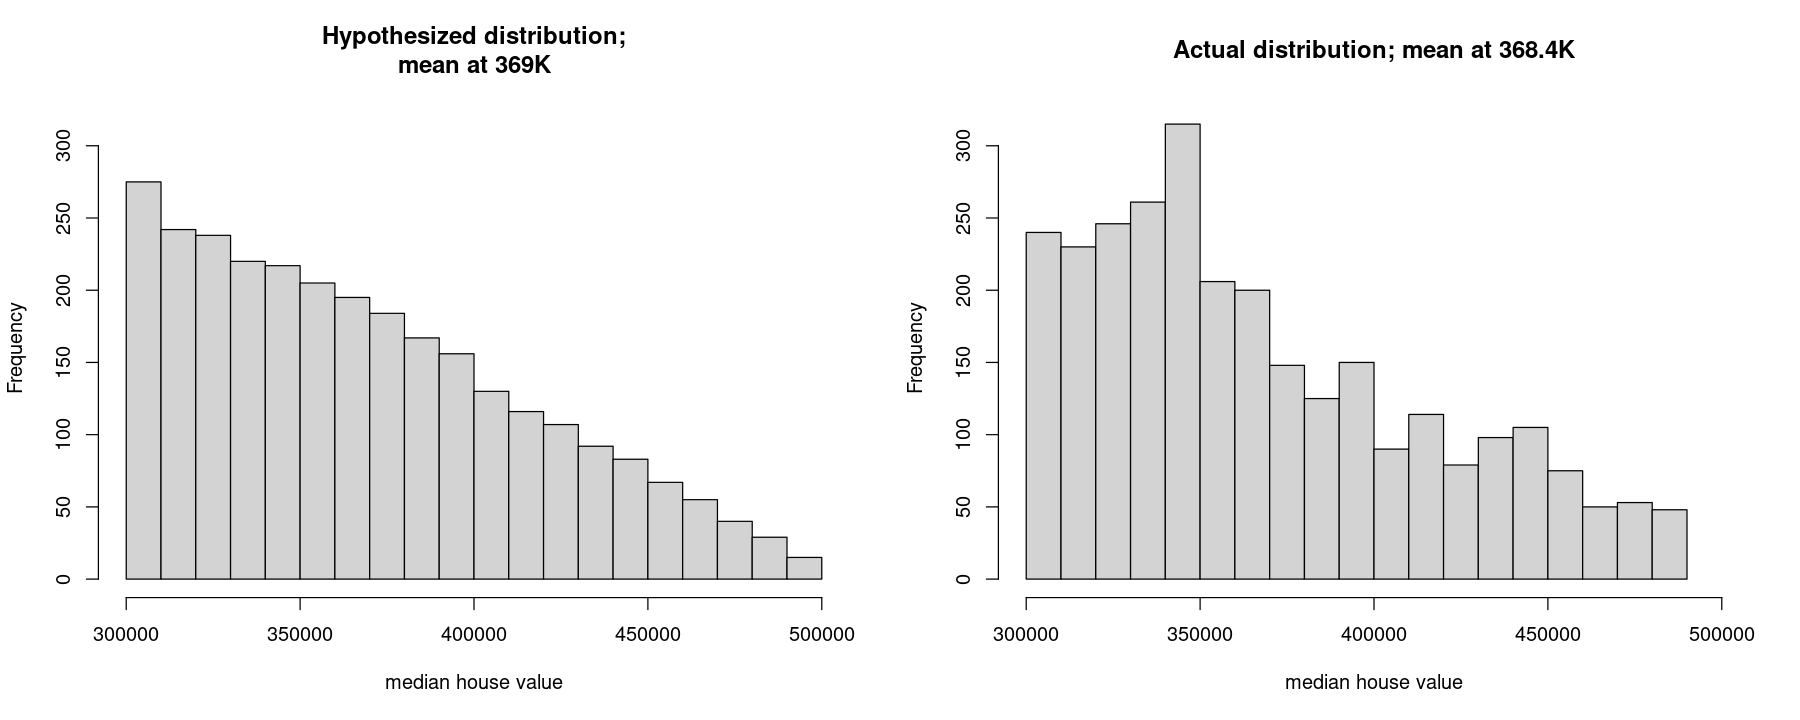

In [114]:
# Compare the above distribution with the hypothesized distribution.

options(repr.plot.width= 15, repr.plot.height= 6)

mat <- t(as.matrix(c(1,2)))
layout(mat, widths = rep.int(20, ncol(mat)),
       heights = rep.int(7, nrow(mat)), respect = FALSE)

# Left panel.
hist(imputed_vals_tmp, breaks=20, main="Hypothesized distribution;
mean at 369K",
     ylim=c(0, 320), xlim=c(3e05, 5e05), xlab="median house value")

# Right panel.
hist(unobserved_vals, breaks=20, main="Actual distribution; mean at 368.4K",
     ylim=c(0, 320), xlim=c(3e05, 5e05), xlab="median house value")


In [115]:
actual_vals <- unobserved_vals
names(actual_vals) <- rownames(dat_noCap[which(dat_noCap$median_house_value >= 300000),])


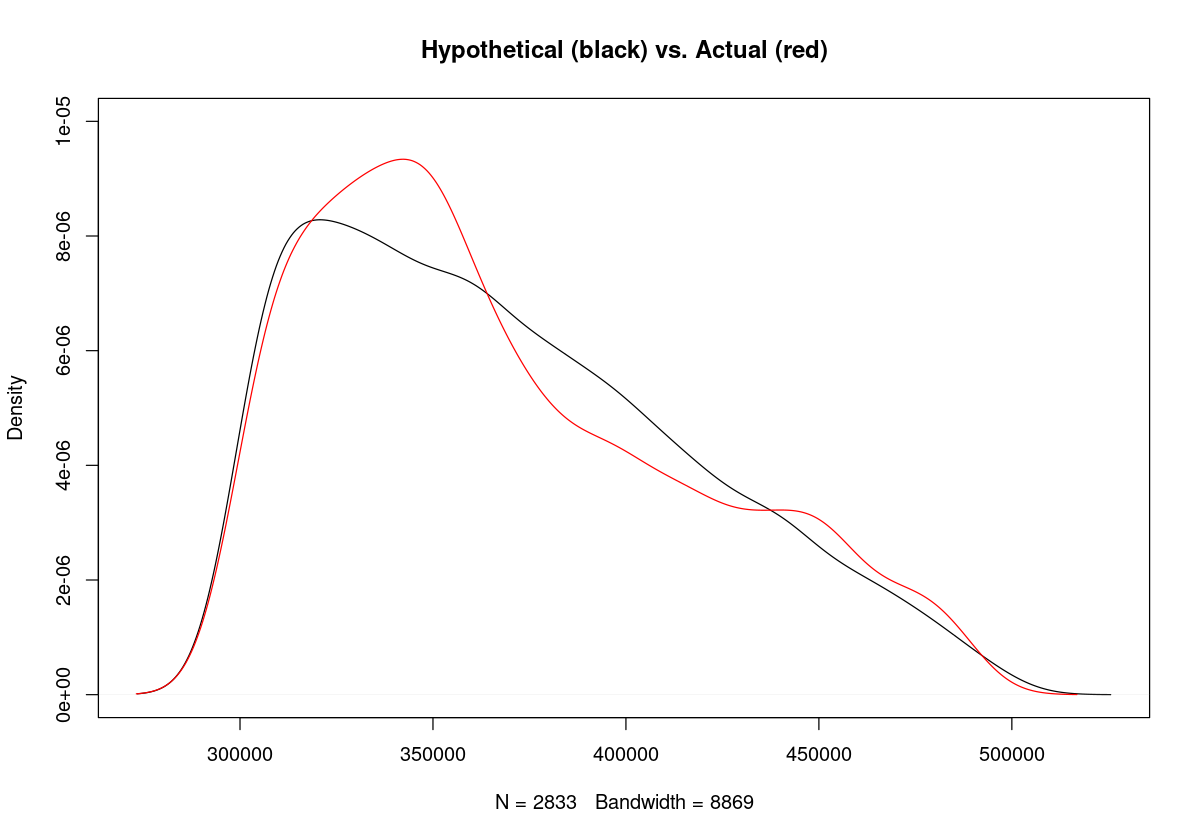

In [116]:
# Create single plot of overlaid densities.

options(repr.plot.width= 10, repr.plot.height= 7)

fit <- density(imputed_vals_tmp)
plot(fit, ylim=c(0, 10e-06), main="Hypothetical (black) vs. Actual (red)")

lines(density(unobserved_vals), col= "red")



### Compute the RSS gain for the original Gibbs output

RSS gain = 1 - \[RSS for predicted values / RSS for capped values\]


In [117]:
# Compute the RSS for the imputed values.

gibbs_raw_rss <- round(sum((actual_vals[rows_censored] - newdat_raw[rows_censored,]$median_house_value)^2))
paste0("RSS score for the unadjusted, raw Gibbs output: ", as.character(gibbs_raw_rss))


[1] "RSS score for the unadjusted, raw Gibbs output: 9830888236395"

In [118]:
# Compute the RSS for the capped values.

cap_rss <- round(sum((actual_vals[rows_censored] - 300000)^2))


In [119]:
# Compute the RSS gain for the original Gibbs output.
# This is a measure of how much we have reduced the noise
# in the capped values.

# RSS gain = 1 - [RSS for predicted values / RSS for capped values]

(gibbs_raw_RSSgain <- round(1 - gibbs_raw_rss/cap_rss, 4))
# 0.5083


[1] 0.5083

### Compute the RSS gain for the adjusted output---Approach 1

In [120]:
# Compute the RSS for the imputed values.

adj01_rss <- round(sum((actual_vals[rows_censored] - newdat_adj01[rows_censored,]$median_house_value)^2))
paste0("RSS score for adjusted Gibbs output--Approach 1: ", as.character(adj01_rss))


[1] "RSS score for adjusted Gibbs output--Approach 1: 9857355623622"

In [121]:
# Compute the RSS gain.

(adj01_RSSgain <- round(1 - adj01_rss/cap_rss, 4))
# 0.5070


[1] 0.507

### Compute the RSS gain when all imputed values are set to the predicted mean of 368K

Because our prediction for the mean is almost spot-on, this gain will be quite high.

In [122]:
# Compute the RSS for these imputed values.

predicted_mean_rss <- round(sum((actual_vals[rows_censored] - 368000)^2))


In [123]:
# Compute the RSS gain.

(predicted_mean_RSSgain <- round(1 - predicted_mean_rss/cap_rss, 4))
# 0.6629


[1] 0.6629

In [ ]:
### COMMENT:

# If we measure by RSS alone, our current best set of imputed 
# values is one where all are set to the predicted mean.  This 
# has to do in part with the fact that our prediction for the
# mean is so good.


### Compute the RSS gain for the adjusted Gibbs output---Approach 2

In [124]:
adj02_rss <- round(sum((actual_vals[rows_censored] - as.numeric(newpreds[rows_censored]))^2))
paste0("RSS score for Approach 2 output: ", as.character(adj02_rss))


[1] "RSS score for Approach 2 output: 9953467541793"

In [125]:
# n_preds = 17K; bin size = 10K.

(adj02_RSSgain <- round(1 - adj02_rss/cap_rss, 4))
# 0.5022


[1] 0.5022

In [ ]:
### COMMENT:

# Approach 2 gives us the shape we expect to see and the
# mean we expect to see, but the RSS gain takes a slight hit.


In [126]:
# Here is the RSS gain for Approach 2 when the output is
# jittered.  (Bin size = 10K.)

adj02jitt_rss <- round(sum((actual_vals[rows_censored] - as.numeric(newpreds_jitt[rows_censored]))^2))
paste0("RSS score for Approach 2 output, jittered: ", as.character(adj02jitt_rss))


[1] "RSS score for Approach 2 output, jittered: 9973798627748"

In [127]:
# n_preds = 17K; bin size = 10K.  Output jittered.

(adj02jitt_RSSgain <- round(1 - adj02jitt_rss/cap_rss, 4))
# 0.5011


[1] 0.5011

## Compute Approach 2 scores when 12.5K bins are used

We should be able to increase the Approach 2 score by increasing the size of the bin.  We do not want to increase the bin size too much because the larger the bin, the less control we have over the shape of the output.

In [128]:
# Create 12.5K-sized bins by first creating 2.5K bins.
# It is easiest to first convert to 5K bins.

bins5K <- seq(300000, 495000, by= 5000)
bins5K_names <- paste(as.character(bins5K/1000), "K", sep="")
names(bins5K) <- bins5K_names
length(bins5K)


[1] 40

In [129]:
# The following loop divides each 10K bin count up 
# into two 5K bin counts.

bins5K_counts <- rep(NA, length(bins5K))

index <- 1
for(i in 1:length(bins10K)) {
    
    curbin_count <- as.numeric(bins10K_counts[i])
    mid <- round(curbin_count/2)
    incr <- round(0.025 * mid)
    high <- mid + incr
    low <- curbin_count - (high)
    
    bins5K_counts[index] <- high
    bins5K_counts[index + 1] <- low
    index <- index + 2
}
names(bins5K_counts) <- bins5K_names
print(bins5K_counts)
sum(bins5K_counts)
sum(bins5K_counts)== 2833


300K 305K 310K 315K 320K 325K 330K 335K 340K 345K 350K 355K 360K 365K 370K 375K 
 133  127  127  121  121  115  115  109  110  104  105   99  100   95   94   91 
380K 385K 390K 395K 400K 405K 410K 415K 420K 425K 430K 435K 440K 445K 450K 455K 
  86   83   78   75   69   65   62   58   54   52   48   46   43   40   35   33 
460K 465K 470K 475K 480K 485K 490K 495K 
  29   26   20   20   15   15    8    7 


[1] 2833

[1] TRUE

In [130]:
bins2.5K <- seq(300000, 497500, by= 2500)
bins2.5K_names <- paste(as.character(bins2.5K/1000), "K", sep="")
names(bins2.5K) <- bins2.5K_names
length(bins2.5K)


[1] 80

In [131]:
# Now divide up each 5K bin.

bins2.5K_counts <- rep(NA, length(bins2.5K))

index <- 1
for(i in 1:length(bins5K)) {
    
    curbin_count <- as.numeric(bins5K_counts[i])
    high <- ceiling(curbin_count/2)
    low <- curbin_count - (high)
    
    bins2.5K_counts[index] <- high
    bins2.5K_counts[index + 1] <- low
    index <- index + 2
}
names(bins2.5K_counts) <- bins2.5K_names
print(bins2.5K_counts)
sum(bins2.5K_counts)
sum(bins2.5K_counts)== 2833


  300K 302.5K   305K 307.5K   310K 312.5K   315K 317.5K   320K 322.5K   325K 
    67     66     64     63     64     63     61     60     61     60     58 
327.5K   330K 332.5K   335K 337.5K   340K 342.5K   345K 347.5K   350K 352.5K 
    57     58     57     55     54     55     55     52     52     53     52 
  355K 357.5K   360K 362.5K   365K 367.5K   370K 372.5K   375K 377.5K   380K 
    50     49     50     50     48     47     47     47     46     45     43 
382.5K   385K 387.5K   390K 392.5K   395K 397.5K   400K 402.5K   405K 407.5K 
    43     42     41     39     39     38     37     35     34     33     32 
  410K 412.5K   415K 417.5K   420K 422.5K   425K 427.5K   430K 432.5K   435K 
    31     31     29     29     27     27     26     26     24     24     23 
437.5K   440K 442.5K   445K 447.5K   450K 452.5K   455K 457.5K   460K 462.5K 
    23     22     21     20     20     18     17     17     16     15     14 
  465K 467.5K   470K 472.5K   475K 477.5K   480K 482.5K   485K 4

[1] 2833

[1] TRUE

In [132]:
bins12.5K <- seq(300000, 487500, by= 12500)
bins12.5K_names <- paste(as.character(bins12.5K/1000), "K", sep="")
names(bins12.5K) <- bins12.5K_names
length(bins12.5K)


[1] 16

In [133]:
# Now combine the small bins into larger bins.

bins12.5K_counts <- rep(NA, length(bins12.5K))

index <- 1
for(i in 1:length(bins12.5K)) {
    
    bins12.5K_counts[i] <- sum(bins2.5K_counts[index:(index + 4)])
    index <- index + 5
}
names(bins12.5K_counts) <- bins12.5K_names
print(bins12.5K_counts)
sum(bins12.5K_counts)
sum(bins12.5K_counts)== 2833


  300K 312.5K   325K 337.5K   350K 362.5K   375K 387.5K   400K 412.5K   425K 
   324    305    285    268    254    239    219    194    165    143    123 
437.5K   450K 462.5K   475K 487.5K 
   106     83     60     43     22 


[1] 2833

[1] TRUE

In [134]:
# Check the mean of this new hypothetical distribution.

series <- seq(from=(300000 + 6250), to=(487500 + 6250), by=12500)
vals <- rep(series, as.numeric(bins12.5K_counts))
round(mean(vals))
# 369,227


[1] 369227

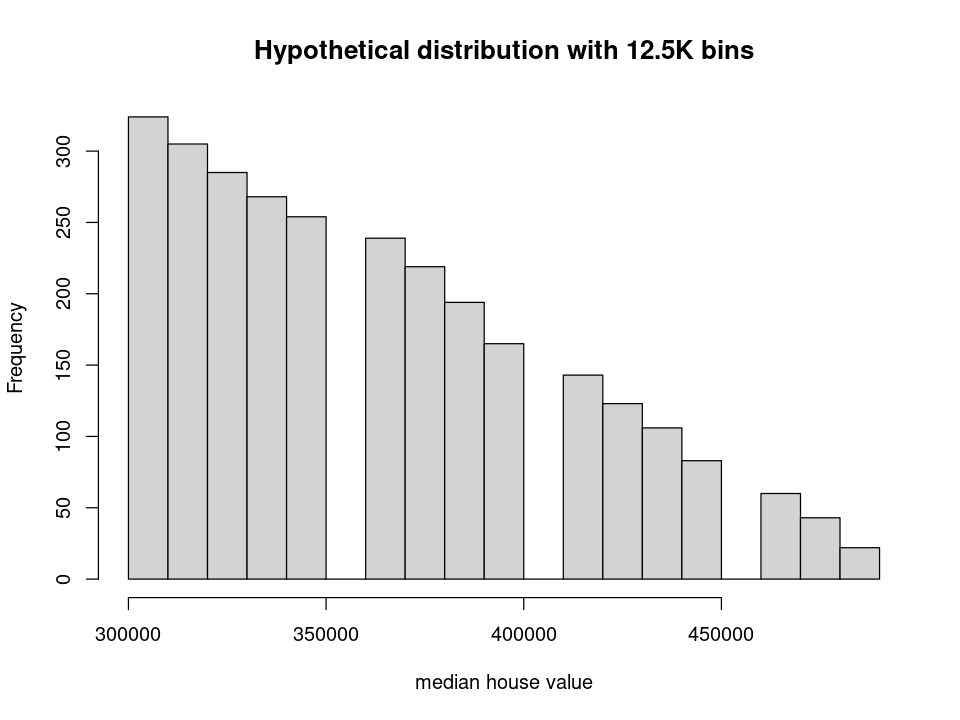

In [135]:
# Check the shape of the distribution.

# The hist() function struggles with this set of values.
# We would have counts where the absent bars are if I
# had constructed vals using runif.

options(repr.plot.width= 8, repr.plot.height= 6)

series <- seq(from=300000, to=487500, by=12500)
vals <- rep(series, as.numeric(bins12.5K_counts))

hist(vals, breaks=14, main="Hypothetical distribution with 12.5K bins",
     xlab="median house value", cex.main=1.3)


In [136]:
# Function which identifies the bin that a given number
# falls into. 

get_bin <- function(val, bin_size=12500) {
    
    return(floor(val/bin_size) * bin_size)
}


In [137]:
# Construct a dataframe which holds predictions for each
# of the z_means and records the probability of the z_mean
# being located at the "predicted" value.

n_preds <- 20000
cap <- 300000

start <- Sys.time()
dfpreds <- rep(NA, n_preds*n.censored*4)
dim(dfpreds) <- c(n_preds*n.censored, 4)
dfpreds <- as.data.frame(dfpreds)
colnames(dfpreds) <- c("rowname","predicted_val","loc_prob","bin")

dfpreds$rowname <- rep(rows_censored, rep(n_preds, n.censored))

stop <- Sys.time()
round(stop - start, 2)
# Time difference of 2.04 secs when n_preds = 20K


Time difference of 1.87 secs

In [138]:
# Get vectors needed for our dataframe.

probs_list <- bins_list <- preds_list <- vector("list", length=n.censored)
names(probs_list) <- names(bins_list) <- names(preds_list) <- rows_censored

start <- Sys.time()
for(i in 1:n.censored) {
    
    cur_mean <- z_means[i]
    cur_sd <- z_sds[i]
    cur_row <- rows_censored[i]
    
    # Get n_preds predictions for this mean.
    mu02 <- ifelse(cur_mean <= C, (cap + 10)^response_var_power, cur_mean)
    p.lo <- pnorm(C, mu02, cur_sd)
    p.hi <- pnorm(C_upper, mu02, cur_sd)
    u <- qnorm(runif(n_preds, p.lo, p.hi), mu02, cur_sd)
    loc_probs <- abs(dnorm(u, mu02, cur_sd, log=TRUE))
    u_transf <- u^inv_pwr
    bin_vector <- as.vector(apply(as.matrix(u_transf), MARGIN=2, FUN=get_bin))
    
    probs_list[[i]] <- loc_probs
    preds_list[[i]] <- u_transf
    bins_list[[i]] <- bin_vector
}
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 5.41 secs when n_preds = 20K


Time difference of 5.58 secs

In [139]:
# Populate the dataframe.

start <- Sys.time()
dfpreds$predicted_val <- as.vector(unlist(preds_list))
dfpreds$loc_prob <- as.vector(unlist(probs_list))
dfpreds$bin <- as.vector(unlist(bins_list))

stop <- Sys.time()
round(stop - start, 2)
# Time difference of 42 secs when n_preds = 15K

dim(dfpreds)
# 48,161,000    4 when n_preds = 17K

head(dfpreds); tail(dfpreds)


Time difference of 43.87 secs

[1] 56660000        4

,rowname,predicted_val,loc_prob,bin
,<chr>,<dbl>,<dbl>,<dbl>
1,1,401572,8.2020,400000
2,1,363755,7.7699,362500
3,1,322523,8.2166,312500
4,1,304817,8.7254,300000
5,1,394972,8.0716,387500
6,1,422990,8.7789,412500


,rowname,predicted_val,loc_prob,bin
,<chr>,<dbl>,<dbl>,<dbl>
56659995,20534,389580,8.3187,387500
56659996,20534,359001,7.6743,350000
56659997,20534,337823,7.6440,337500
56659998,20534,301952,8.4246,300000
56659999,20534,377452,7.9807,375000
56660000,20534,323398,7.8284,312500


In [140]:
rm(probs_list, bins_list, preds_list)


In [141]:
# Order the data in dfpreds so that we can access it
# more quickly.

dfpreds <- dfpreds[order(dfpreds$bin),]


In [142]:
# Find predictions for each of the 16 12.5K bins.

rows_to_exclude <- c()
newpreds <- c()
pred_names <- c()

seq <- c(16:9, 1:8)
binvals <- as.numeric(bins12.5K)

start <- Sys.time()
for(i in seq) {
    
    cur_count <- bins12.5K_counts[i]
    binval <- binvals[i]
    
    dftmp <- dfpreds[which(dfpreds$bin == binval),]
    
    # Remove the z_means that we have already used.
    dftmp <- dftmp[which(!(dftmp$rowname %in% rows_to_exclude)),]
    
    # For each rowname, we can only have one prediction.
    dftmp <- dftmp[order(dftmp$rowname, dftmp$loc_prob,
                         decreasing=c(FALSE, FALSE)),]
    dftmp <- dftmp[which(!duplicated(dftmp$rowname)),]
    
    # stopifnot(nrow(dftmp) >= cur_count)
    
    # If we get this far, we have enough predictions to draw from
    # to fill the current bin.  Now order the records by the
    # probabilities and then select what we need.
    dftmp <- dftmp[order(dftmp$loc_prob, decreasing=FALSE),]
    dftmp <- dftmp[1:cur_count, c("rowname","predicted_val")]
    
    newpreds <- c(newpreds, dftmp$predicted_val)
    pred_names <- c(pred_names, dftmp$rowname)
    rows_to_exclude <- c(rows_to_exclude, dftmp$rowname)
}
stop <- Sys.time()
round(stop - start, 2)
# Time difference of ~36 secs when n_preds = 17K


Time difference of 40.24 secs

In [143]:
length(newpreds)
length(pred_names)


[1] 2833

[1] 2833

In [144]:
length(unique(pred_names))


[1] 2833

In [145]:
names(newpreds) <- pred_names
print(tail(newpreds))


  4738   6780  10649   5841   4624   8560 
387500 387502 387521 387507 387512 387509 


In [146]:
# Check mean of the distribution.

summary(newpreds)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 312466  337495  350009  367911  400003  487592 

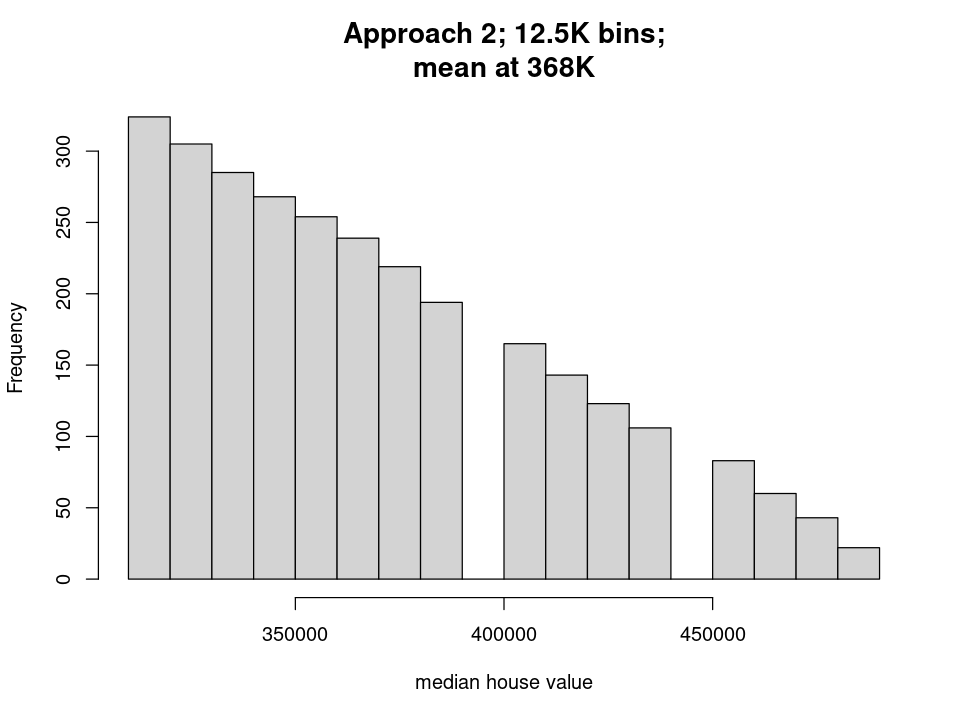

In [147]:
# Check shape of the distribution.

options(repr.plot.width= 8, repr.plot.height= 6)

hist(newpreds, breaks=20, main="Approach 2; 12.5K bins;
mean at 368K", xlab="median house value", cex.main=1.4)


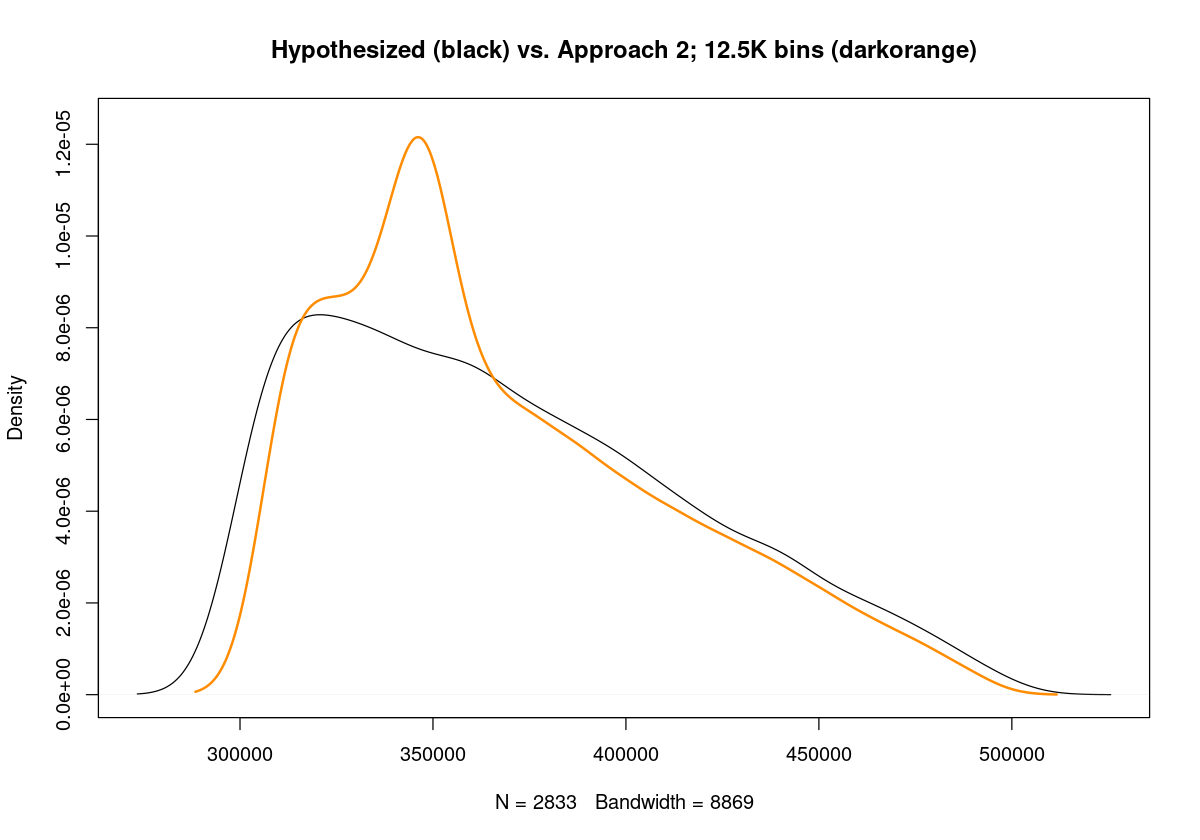

In [149]:
# Compare the density curves.

options(repr.plot.width= 10, repr.plot.height= 7)

fit <- density(imputed_vals_tmp)
plot(fit, ylim=c(0, 1.25e-05), main="Hypothesized (black) vs. Approach 2; 12.5K bins (darkorange)")

lines(density(newpreds), col= "darkorange", lwd=2)


In [150]:
# Compute the RSS gain.  n_preds = 20K; bin size = 12.5K.

adj02b_rss <- round(sum((actual_vals[rows_censored] - newpreds[rows_censored])^2))
round(1 - adj02b_rss/cap_rss, 4)
# 0.5101


[1] 0.5101

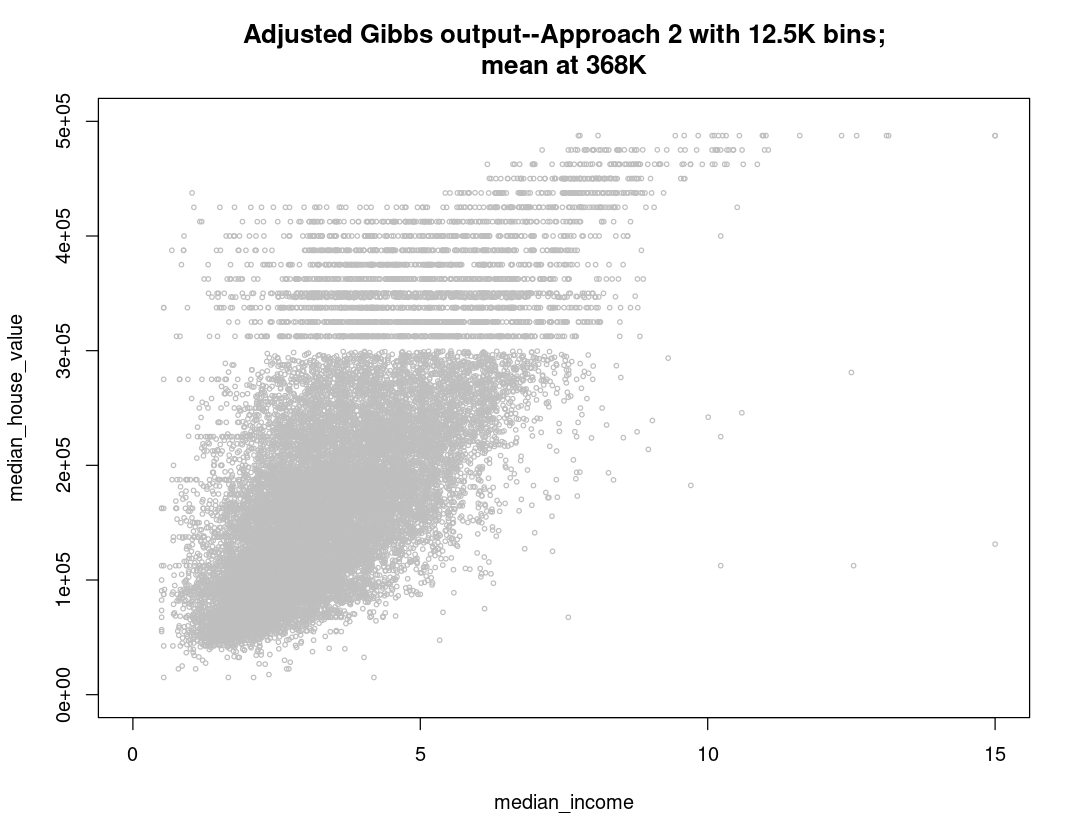

In [152]:
options(repr.plot.width= 9, repr.plot.height= 7)

newdat_adj03 <- dat
newdat_adj03[rows_censored, c("median_house_value")] <- as.numeric(newpreds[rows_censored])

# plot the newly predicted values
plot(newdat_adj03$median_income, newdat_adj03$median_house_value, type= "p", pch=1, cex=0.5, col="grey",
     xlab= "median_income", ylab= "median_house_value", ylim= c(0, 0.50e06), xlim= c(0, 15),
     main= "Adjusted Gibbs output--Approach 2 with 12.5K bins;
mean at 368K", cex.main=1.3)


In [154]:
# Jitter the values a bit to remove the band effects.

newpreds_adj03 <- round(jitter(newpreds, amount=6000))
summary(newpreds_adj03)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 306554  334553  354716  367801  396246  493205 

In [155]:
# Compute RSS gain with jittered data.
# n_preds = 20K; bin size = 12.5K.

adj03_rss <- round(sum((actual_vals[rows_censored] - newpreds_adj03[rows_censored])^2))
round(1 - adj03_rss/cap_rss, 4)
# 0.5080


[1] 0.508

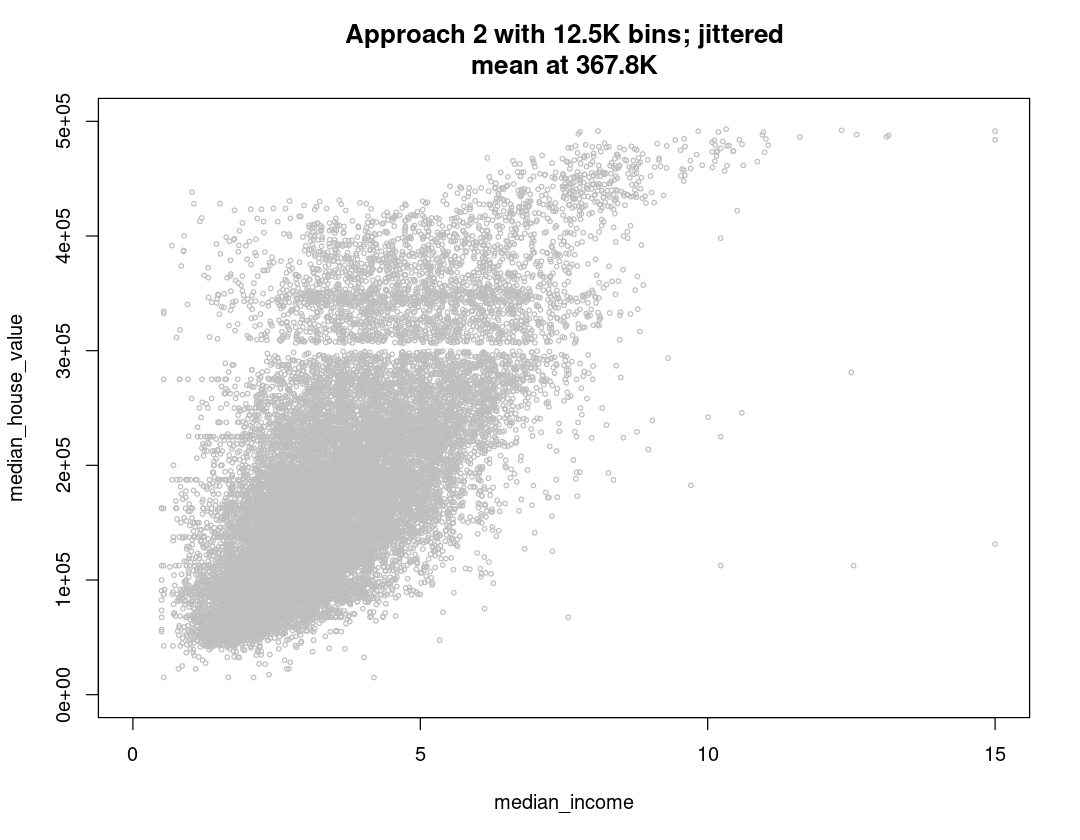

In [156]:
options(repr.plot.width= 9, repr.plot.height= 7)

newdat_adj03jitt <- dat
newdat_adj03jitt[rows_censored, c("median_house_value")] <- as.numeric(newpreds_adj03[rows_censored])

# plot the newly predicted values
plot(newdat_adj03jitt$median_income, newdat_adj03jitt$median_house_value, type= "p", pch=1, cex=0.5, col="grey",
     xlab= "median_income", ylab= "median_house_value", ylim= c(0, 0.50e06), xlim= c(0, 15),
     main= "Approach 2 with 12.5K bins; jittered
mean at 367.8K", cex.main=1.3)


In [ ]:
### COMMENTS:

# As expected, the 12.5K bins yield a better RSS gain than
# the 10K bins.  The score increased by 0.9 percentage points,
# which is not insignificant.


## House values data: Compute more exact RSS scores for each of the 3 methods

Note that the scores here are much higher than those in Section 1 because the Gibbs output is from a model with a much higher R-squared.

### Get RSS scores for the raw Gibbs output

In [157]:
n <- 500
set.seed(4331)
seeds <- sample(10000:99999, n, replace=FALSE)

raw_rss_scores <- rep(NA, n)

for(i in 1:n) {
    
    set.seed(seeds[i])
    z_preds <- round((rnorm.trunc03(n.censored, z_means, z_sds, lo=C, hi=C_upper))^inv_pwr, 1)
    # z_preds is already in the order of rows_censored
    raw_rss <- round(sum((actual_vals[rows_censored] - z_preds)^2))
    raw_rss_scores[i] <- round(1 - raw_rss/cap_rss, 4)
}

round(mean(raw_rss_scores), 4)
round(sd(raw_rss_scores), 4)
# Average RSS gain is: 0.5127
# Standard deviation for the estimate: 0.0091


[1] 0.5127

[1] 0.0091

### Get RSS scores for Approach 1

With the adj01 output, we have the mean we expect but are nowhere near the shape we expect.

In [158]:
n <- 500
set.seed(4331)
seeds <- sample(10000:99999, n, replace=FALSE)

adj01_rss_scores <- rep(NA, n)

z_means_adj <- z_means + (365000^response_var_power - mean(z_means))

for(i in 1:n) {
    
    set.seed(seeds[i])
    z_preds_adj01 <- round((rnorm.trunc03(n.censored, z_means_adj, z_sds, lo=C, hi=C_upper))^inv_pwr, 1)
    
    # z_preds is already in the order of rows_censored
    adj01_rss <- round(sum((actual_vals[rows_censored] - z_preds_adj01)^2))
    adj01_rss_scores[i] <- round(1 - adj01_rss/cap_rss, 4)
}

round(mean(adj01_rss_scores), 4)
round(sd(adj01_rss_scores), 4)
# Average RSS gain is: 0.5145
# Standard deviation for the estimate is: 0.0098


[1] 0.5145

[1] 0.0098

### Get RSS score for Approach 2

In [159]:
## NOTE: What follows is the score for the jittered Approach 2 output.
## The corresponding score for the unjittered output is the 0.5101
## that we saw above.

n <- 500
set.seed(4331)
seeds <- sample(10000:99999, n, replace=FALSE)

adj03_rss_scores <- rep(NA, n)

# Note the use of the previous newpreds and pred_names.
start <- Sys.time()
for(j in 1:n) {
    
    # Jitter the predictions.
    set.seed(seeds[j])
    preds_adj03 <- jitter(newpreds, amount=6000)
    names(preds_adj03) <- pred_names
    
    adj03_rss <- round(sum((actual_vals[rows_censored] - preds_adj03[rows_censored])^2))
    adj03_rss_scores[j] <- round(1 - adj03_rss/cap_rss, 4)
}
stop <- Sys.time()
round(stop - start, 2)

round(mean(adj03_rss_scores), 4)
round(sd(adj03_rss_scores), 4)
# 0.5085
# stddev: 0.0011


Time difference of 0.17 secs

[1] 0.5085

[1] 0.0011

In [ ]:
### COMMENTS:

# With Approach 2 we can come very close to the expected shape,
# have output with the expected mean, and avoid undermining the
# RSS gain we see with the raw Gibbs output.


# Final Comments for Appendix C

Approach 1 adjusts the Gibbs output so that the mean is where we expect it to be.  While this adjustment will also change the distribution of the imputed values, it will not necessarily bring it more into line with the shape we expect to see. 
 
Approach 2 adjusts the Gibbs output so that the mean is where we expect it to be and the shape is close to what we expect to see.    

This appendix examined RSS scores for Approach 1, Approach 2, and the raw Gibbs output.  We looked at scores for two different censored variables.  In one instance, the Approach 2 adjustment to the raw Gibbs output significantly increased the RSS gain.  In the other instance, the adjustment did not undermine the RSS gain we saw for the raw Gibbs output.  In a real-case imputation we will never know the RSS scores.  But the above tests can tell us what is likely to happen to RSS in a real-case imputation. 

If we have a high degree of confidence in our hypothesized distribution (for which we can get partial confirmation using the model-based prediction for the mean), and if the raw Gibbs output does not do a good job approximating this distribution, we may want to resort to either Approach 1 or Approach 2.  Approach 2 is not better than Approach 1 if the latter does a fairly good job of approximating the shape we expect to see (as was the case for housing_median_age in Appendix A).  Because Approach 2 is more "invasive", it poses a greater risk than Approach 1 of adversely affecting the RSS of the raw Gibbs output.  In fact, if our prediction for the mean is accurate, and the mean is where the mode is, Approach 1 will almost certainly improve upon the unadjusted output's RSS score.  The assumptions for Approach 2 are stronger because they are about both mean and shape, and this is why there is a risk of hurting the RSS score. 


Whether we choose Approach 1 over Approach 2, or simply stick with the raw Gibbs output, will depend on what criteria are most important to us and the degree of confidence we have in our prediction for the mean and in our belief about the shape of the output.  If we have a high degree of confidence in our prediction for the mean and the mean of the Gibbs output is far from this, we should choose Approach 1 at a minimum.  If we also have a high degree of confidence in our belief regarding the shape, and if application of Approach 1 does not yield a shape close to the expected shape, we should probably make use of Approach 2.  Running tests as I have done here in Appendix C on artificially censored data to see what the outputs are and the RSS scores can certainly help us when choosing between the three methods.
